In [37]:
from utils.processing import load_file, clean_text
import numpy as np
import yaml
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [38]:
clean_text

<function utils.processing.clean_text(text: str) -> str>

In [39]:
with open("config/config.yaml", 'r') as ymlfile:
    config = yaml.safe_load(ymlfile)
    
LABEL_NAMES = config['LABEL_NAMES'][0]

In [40]:
dev_df, _ = load_file("data/development.csv", sep=",", dtype = {"id": str, "page_rank": int, "label": int})
dev_df_original = dev_df.copy()

  Development set: 79,997 samples, 7 features


In [41]:
dev_df['category'] = dev_df['label'].apply(lambda x: LABEL_NAMES[x])

### Category distribution

Text(74.44444444444444, 0.5, 'Count')

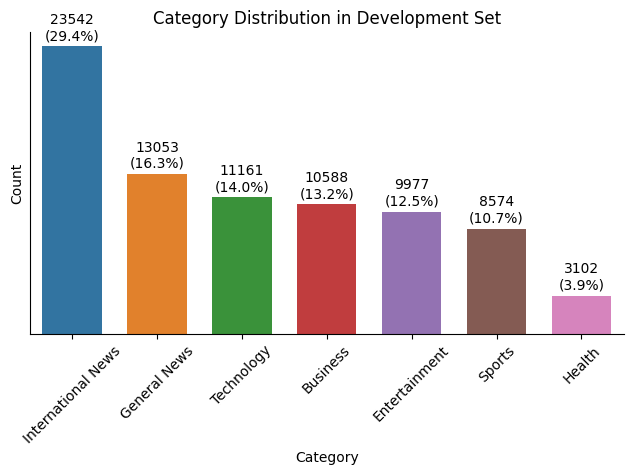

In [42]:

category_counts = dev_df['category'].value_counts()
percentages = (category_counts / category_counts.sum()) * 100
categories = category_counts.index




ax = sns.barplot(x=categories, y=category_counts.values, hue=categories, width=0.7)
plt.xticks(rotation=45)

for p, count, perc in zip(ax.patches, category_counts, percentages):
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 300,
            f'{count}\n({perc:.1f}%)',
            ha="center", va="bottom")
    
    
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.yaxis.set_ticks([])

plt.tight_layout()
plt.title('Category Distribution in Development Set')
plt.xlabel('Category')
plt.ylabel('Count')

### Page Rank distributions among categories

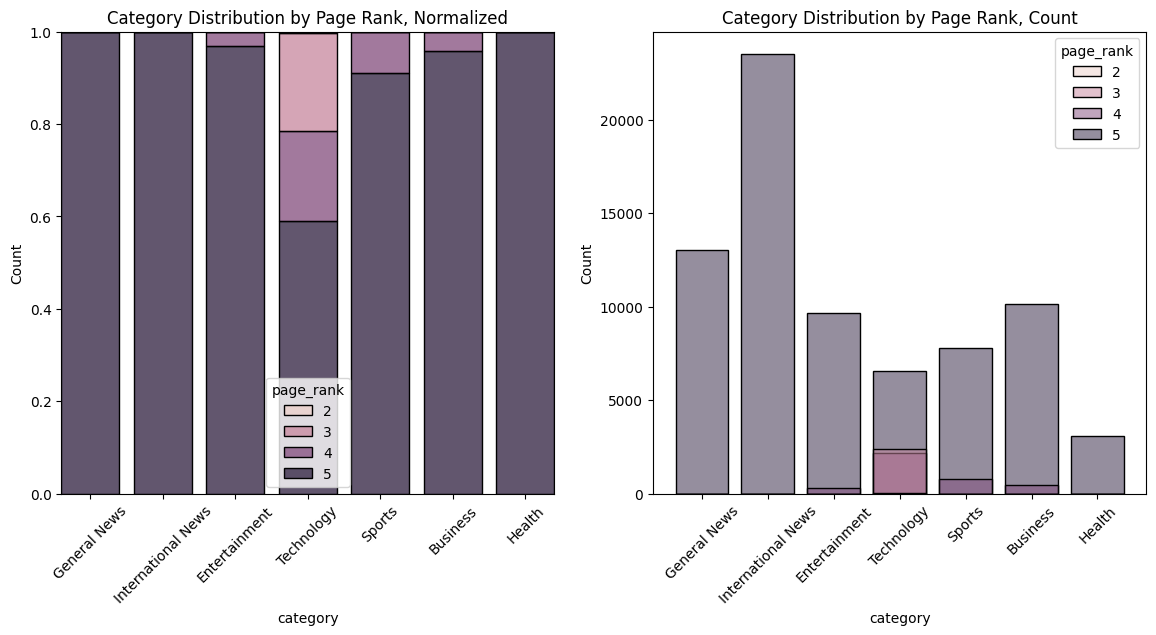

In [43]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,6))

sns.histplot(data=dev_df, x='category', hue='page_rank', shrink = 0.8, multiple='fill', ax=ax1)
ax1.set_title('Category Distribution by Page Rank, Normalized')
ax1.tick_params(axis='x', rotation=45)


sns.histplot(data=dev_df, x='category', hue='page_rank', shrink = 0.8, ax=ax2)
ax2.set_title('Category Distribution by Page Rank, Count')
ax2.tick_params(axis='x', rotation=45)




### Timestamp distribution

In [44]:
dev_df['timestamp_new'] = pd.to_datetime(dev_df['timestamp'], errors='coerce')

In [45]:
dev_df['timestamp_new'].isna().sum()

np.int64(27750)

In [46]:
dev_df['timestamp_new'].info()

<class 'pandas.Series'>
RangeIndex: 79997 entries, 0 to 79996
Series name: timestamp_new
Non-Null Count  Dtype         
--------------  -----         
52247 non-null  datetime64[us]
dtypes: datetime64[us](1)
memory usage: 625.1 KB


In [47]:
dev_df['timestamp_new'].value_counts()

timestamp_new
2007-02-12 12:39:51    2
2007-06-22 18:43:49    2
2007-07-24 01:27:26    2
2007-02-01 07:14:50    2
2004-08-19 05:40:57    2
                      ..
2005-02-11 04:34:15    1
2007-12-15 13:19:48    1
2007-06-25 07:08:21    1
2008-01-23 11:39:35    1
2007-10-24 17:15:44    1
Name: count, Length: 52182, dtype: int64

In [48]:
dev_df['year'] = dev_df['timestamp_new'].dt.year.astype('Int32')
dev_df['month'] = dev_df['timestamp_new'].dt.month.astype('Int32')
dev_df['day'] = dev_df['timestamp_new'].dt.day.astype('Int32')
dev_df['hour'] = dev_df['timestamp_new'].dt.hour.astype('Int32')
dev_df['weekday'] = dev_df['timestamp_new'].dt.weekday.astype('Int32')
dev_df['week'] = dev_df['timestamp_new'].dt.isocalendar().week.astype('Int32')

#### Distribution of NaT among the categories

Text(74.44444444444444, 0.5, 'Count')

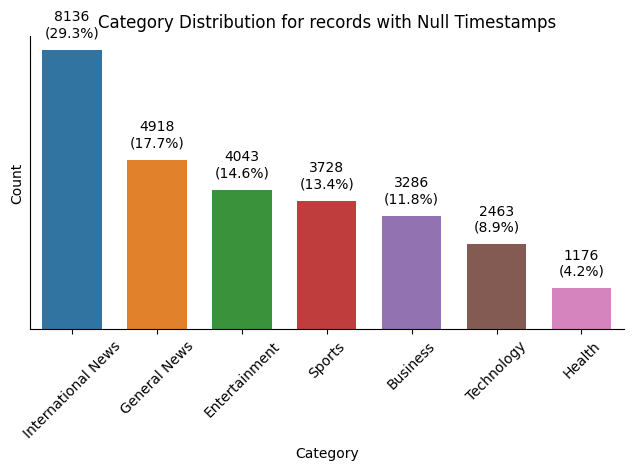

In [49]:

dev_df_null_timestamp = dev_df[dev_df['timestamp_new'].isna()]

category_counts = dev_df_null_timestamp['category'].value_counts()
percentages = (category_counts / category_counts.sum()) * 100
categories = category_counts.index




ax = sns.barplot(x=categories, y=category_counts.values,  hue = categories, width=0.7)
plt.xticks(rotation=45)

for p, count, perc in zip(ax.patches, category_counts, percentages):
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 300,
            f'{count}\n({perc:.1f}%)',
            ha="center", va="bottom")
    
    
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.yaxis.set_ticks([])

plt.tight_layout()
plt.title('Category Distribution for records with Null Timestamps')
plt.xlabel('Category')
plt.ylabel('Count')

#### Heatmaps of timestamp (year, month, ...) vs category

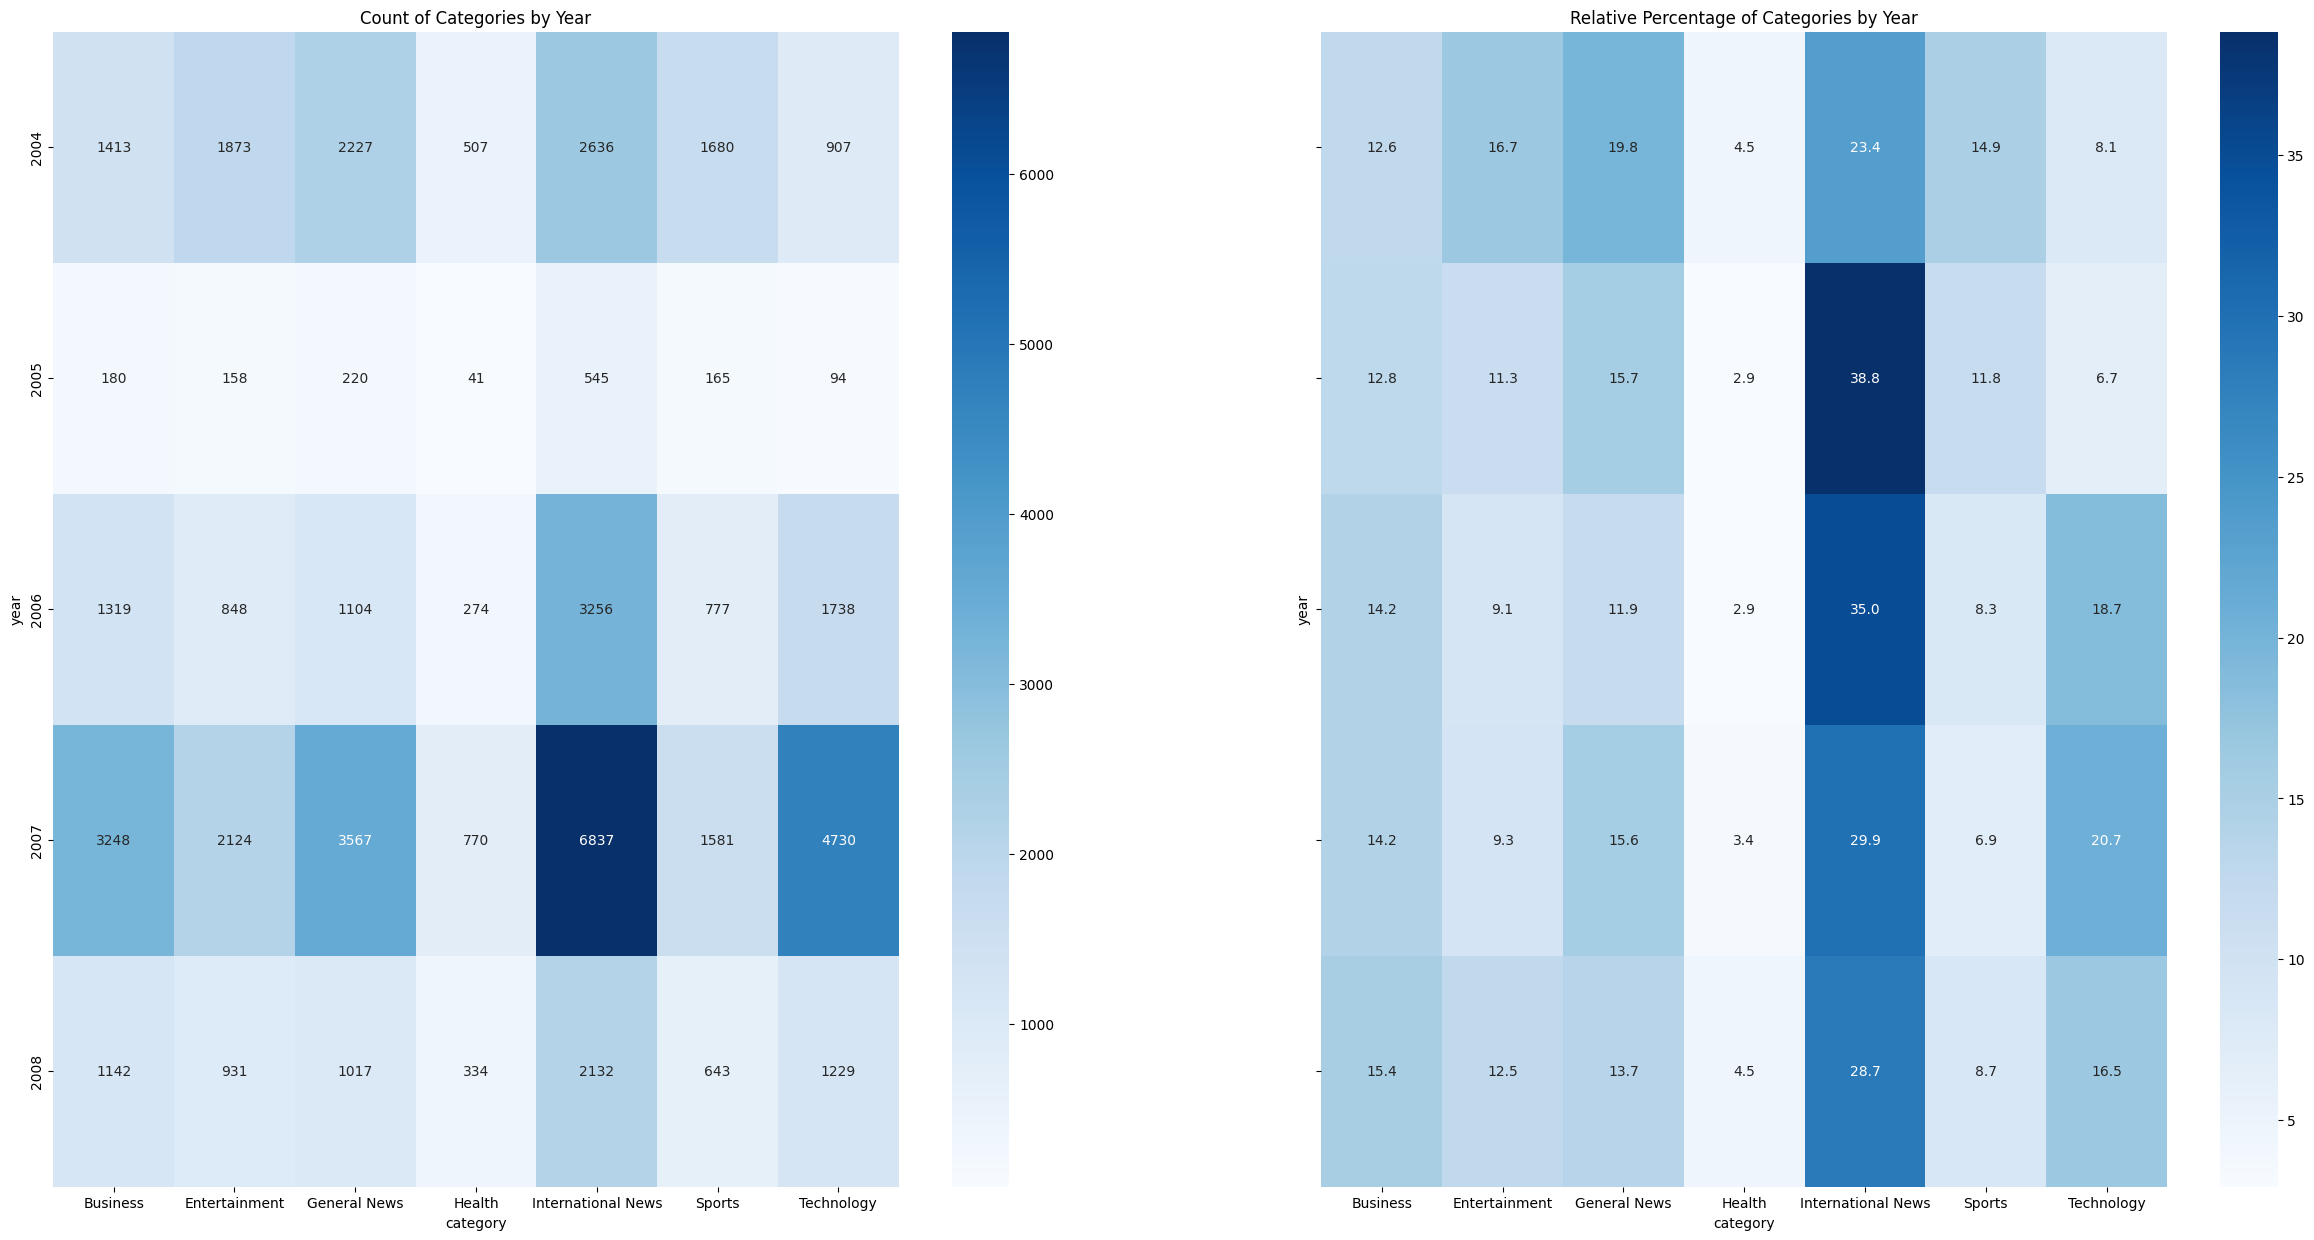

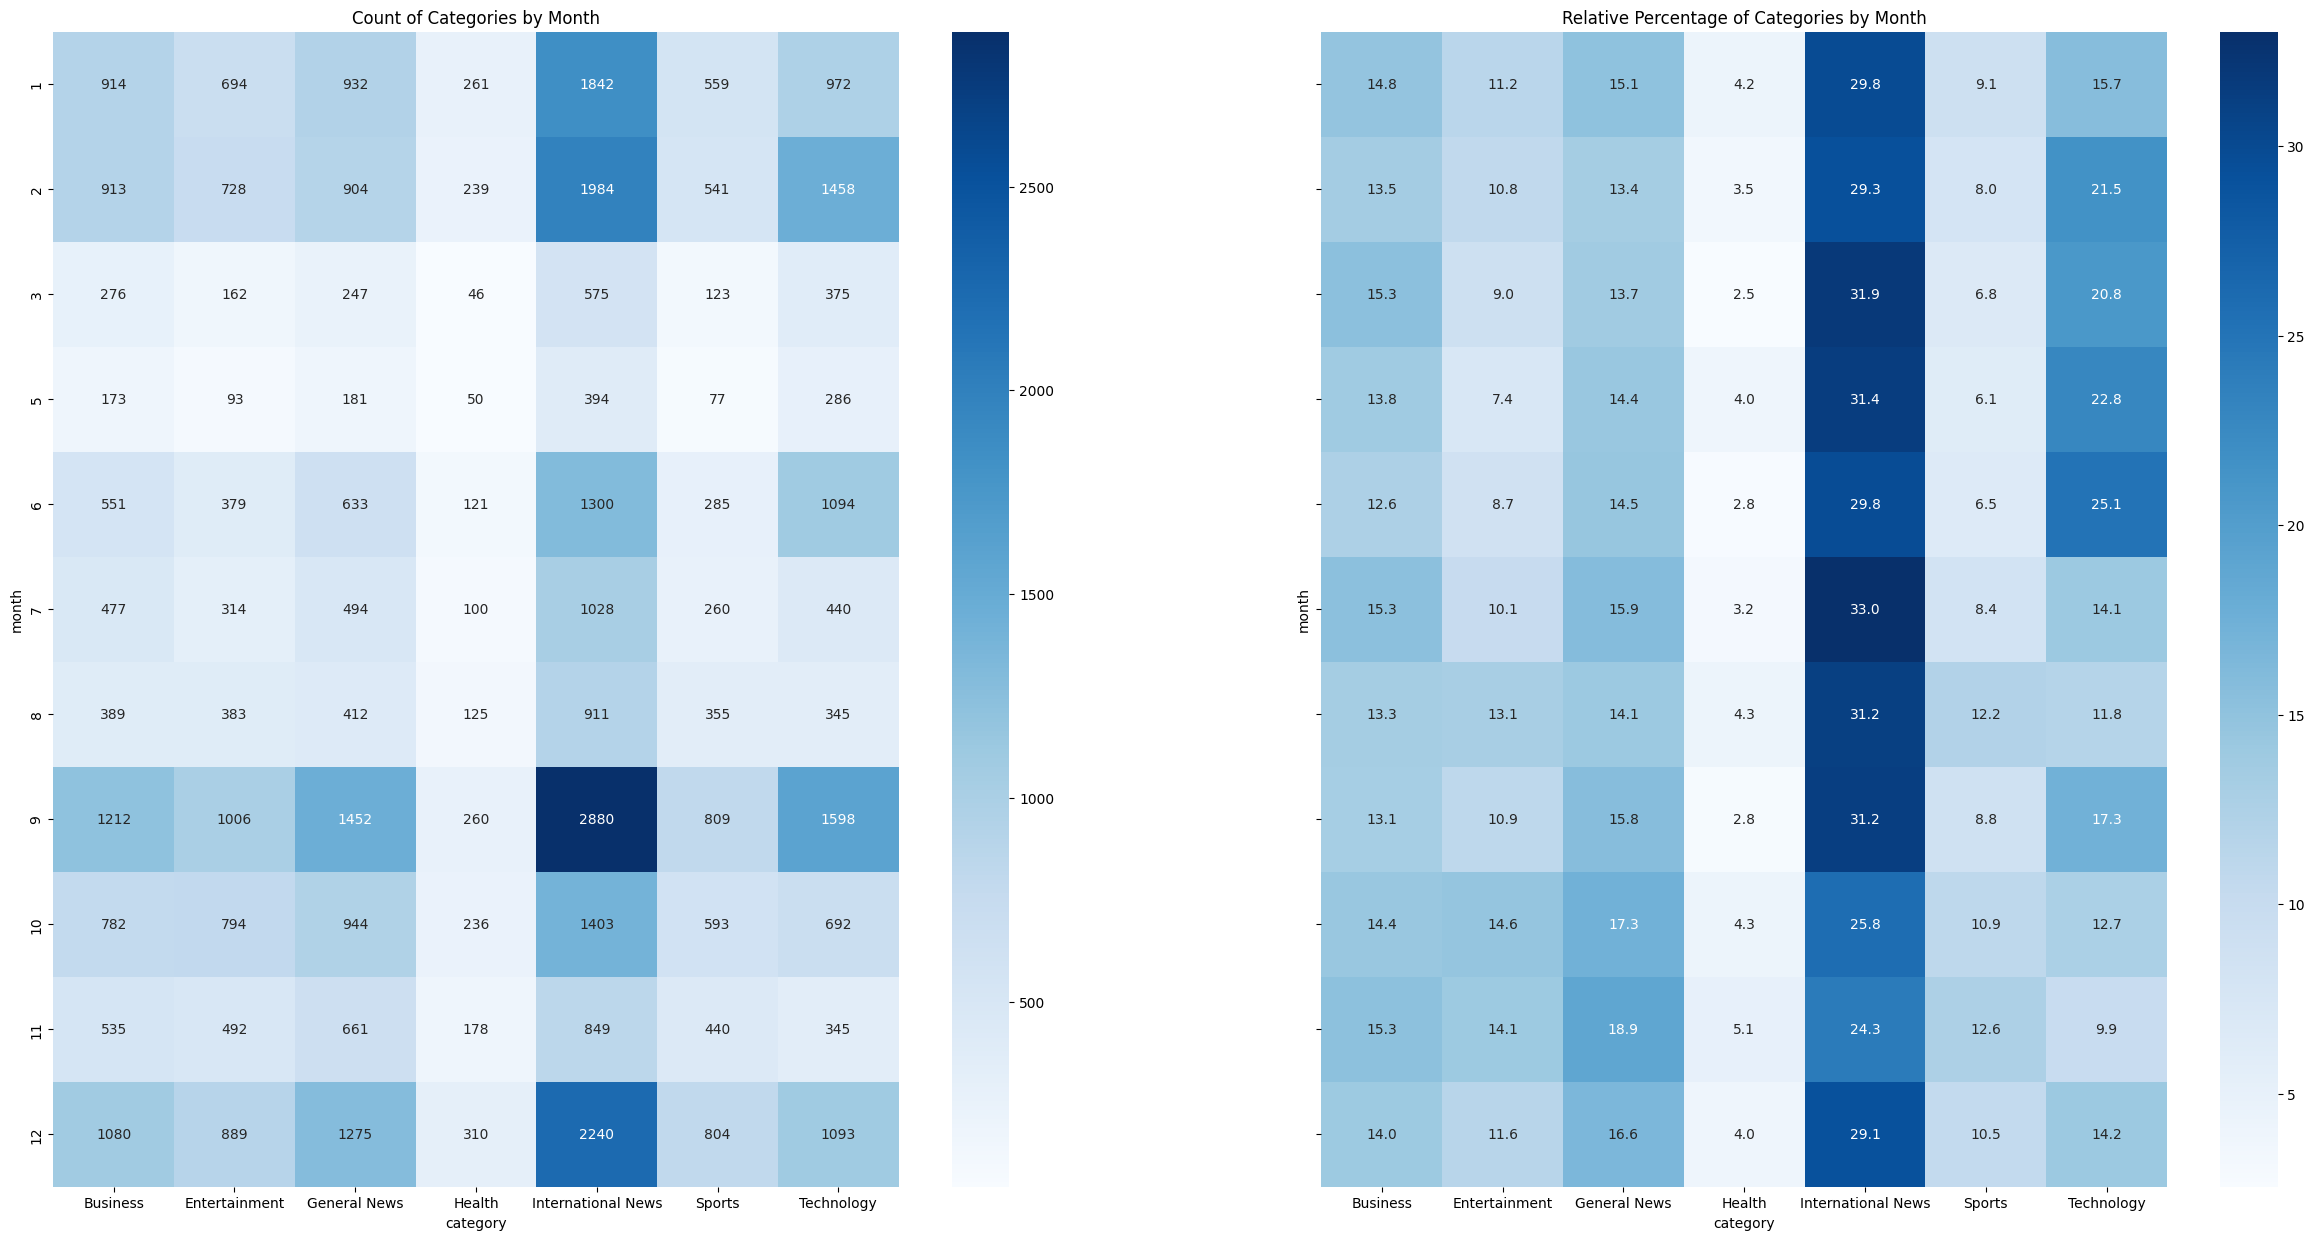

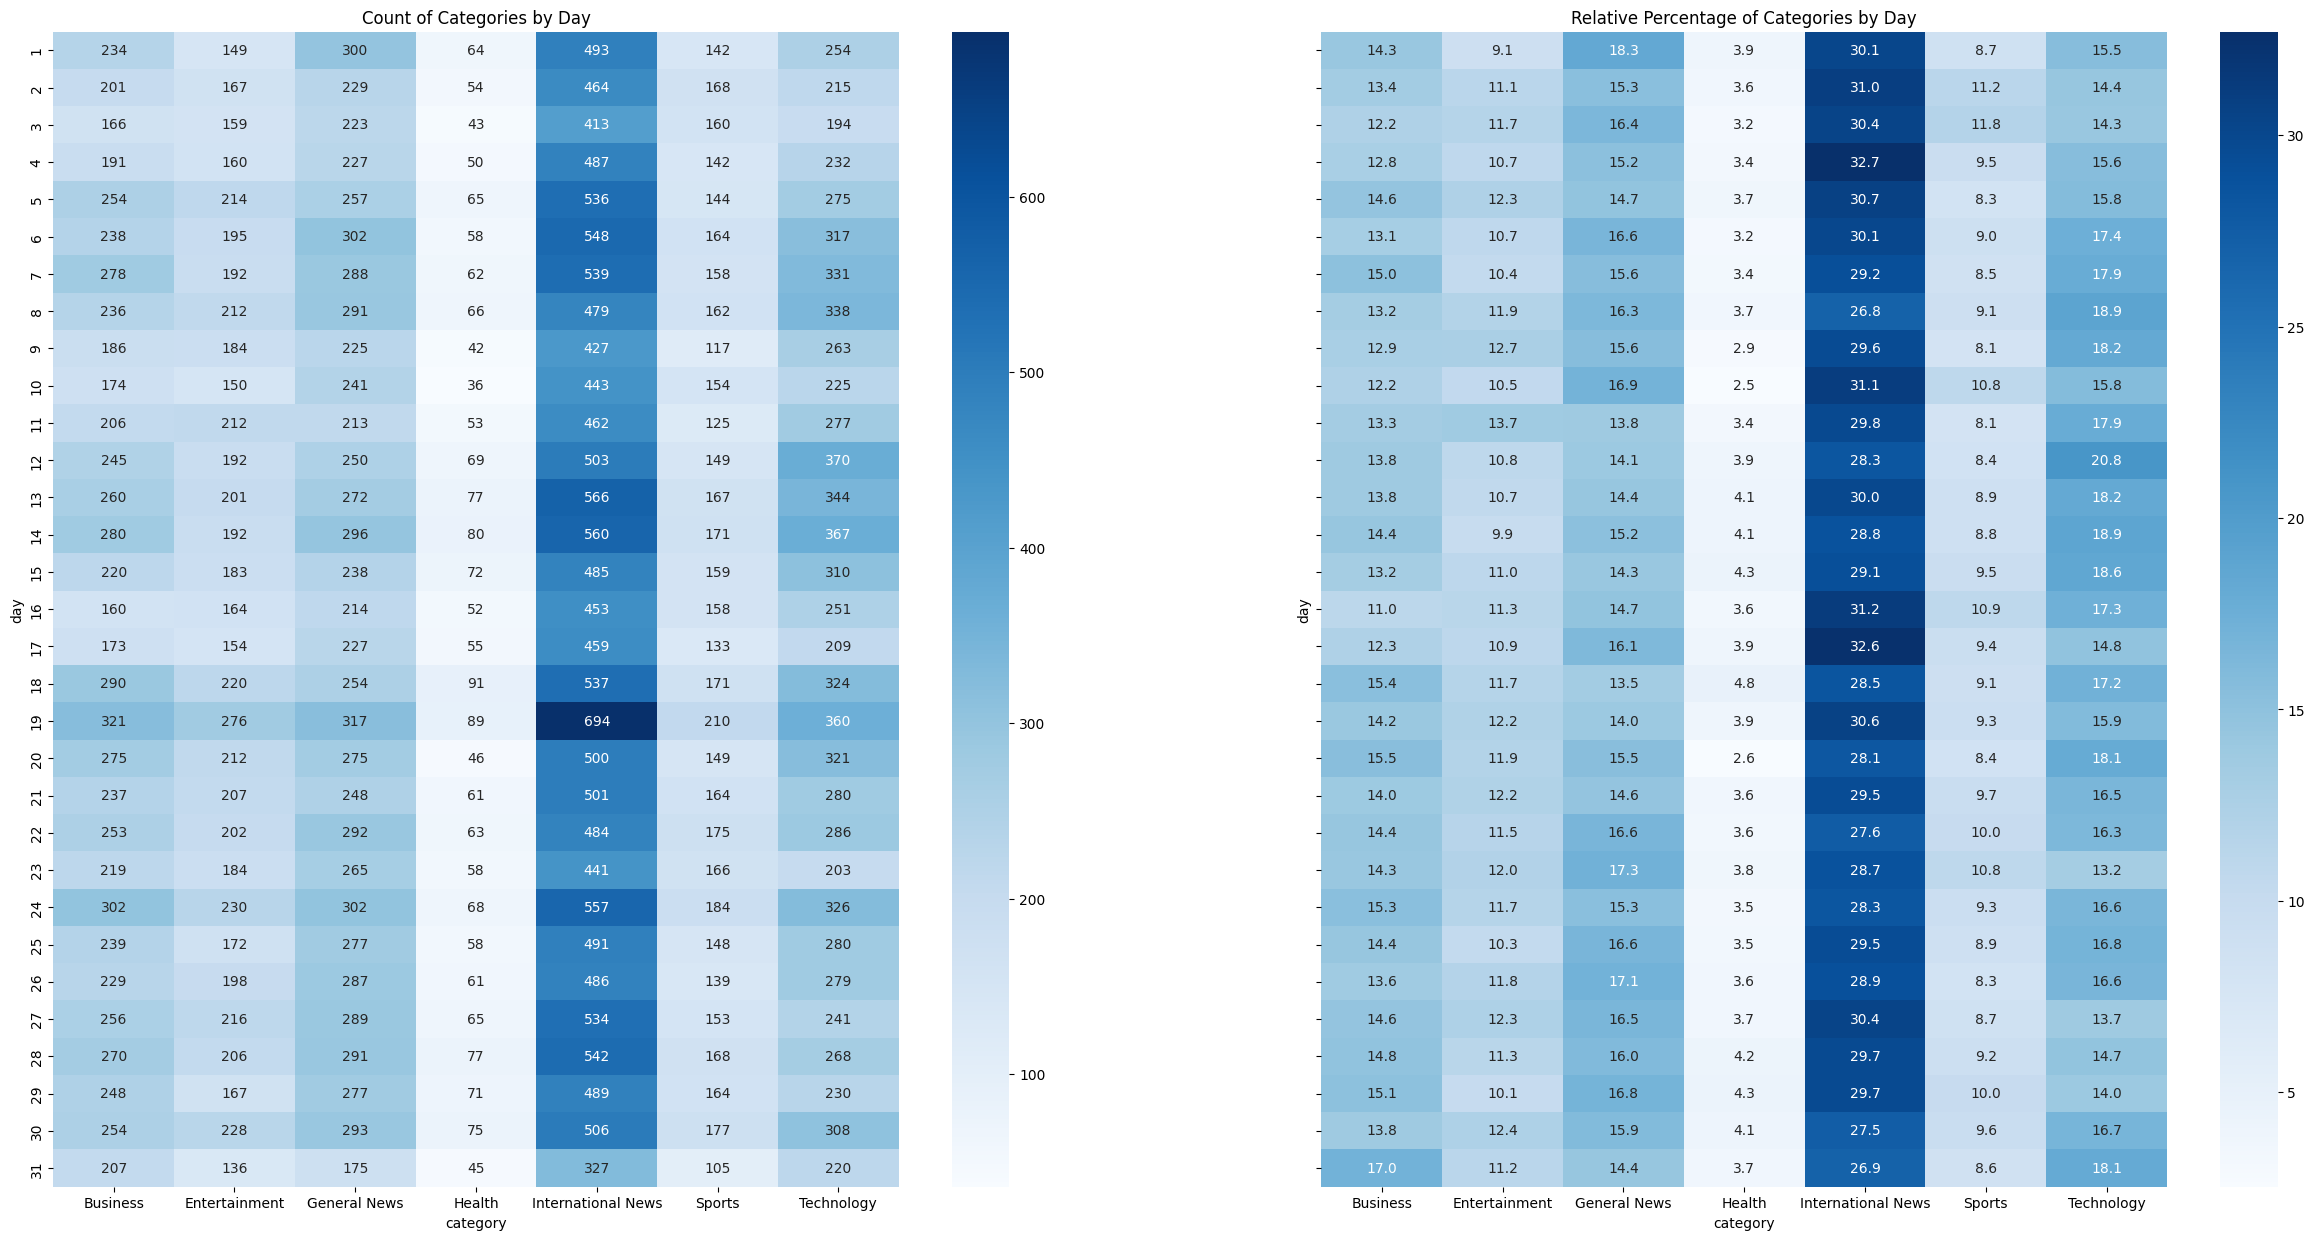

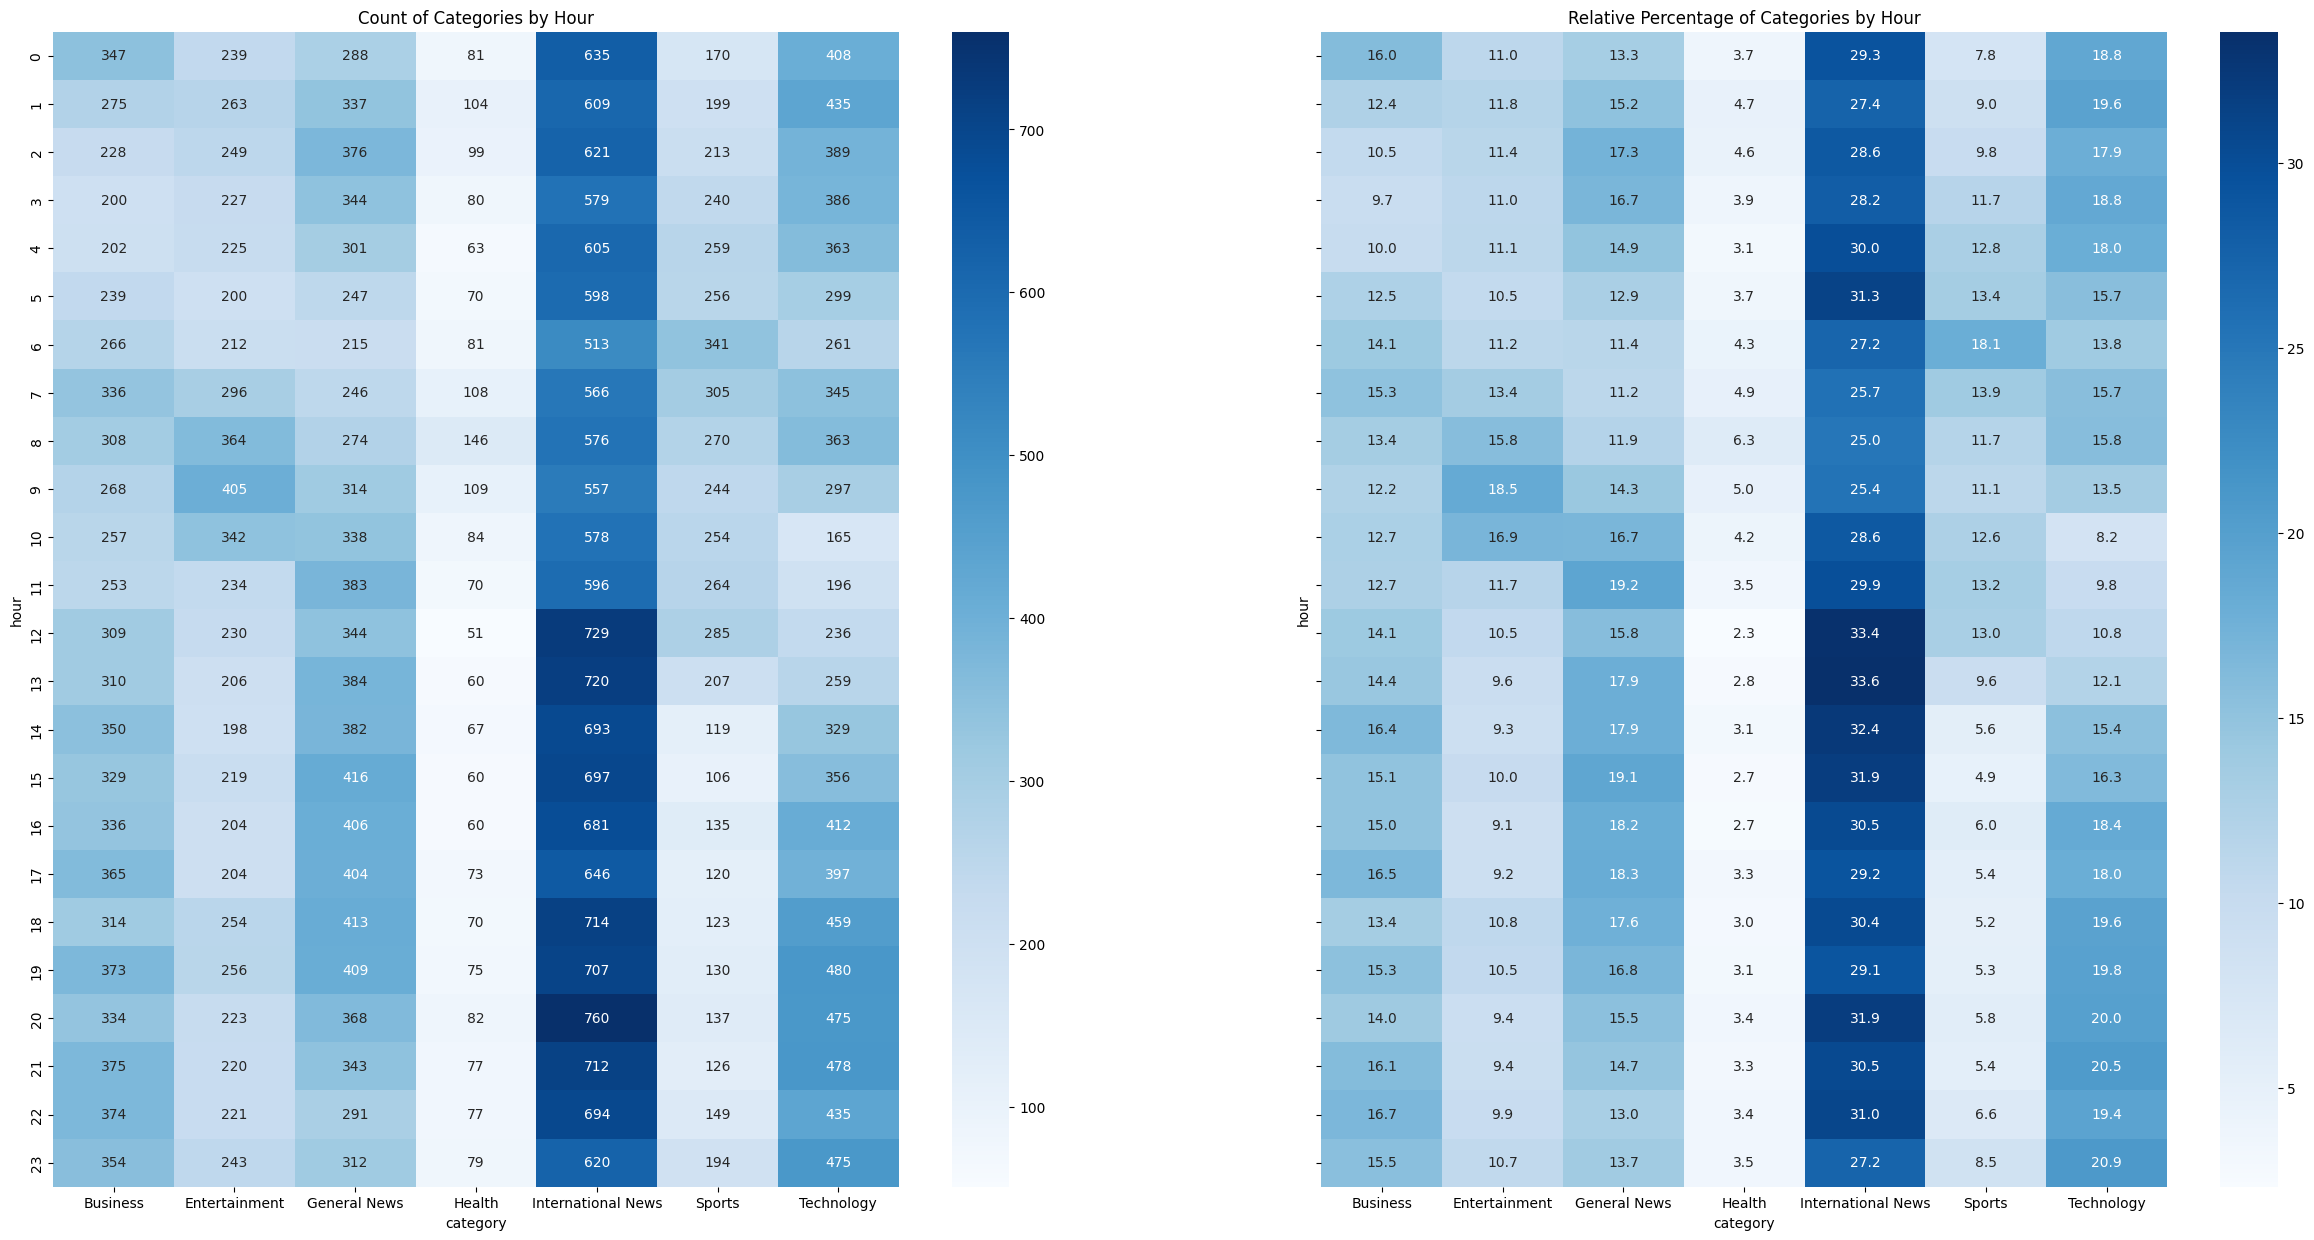

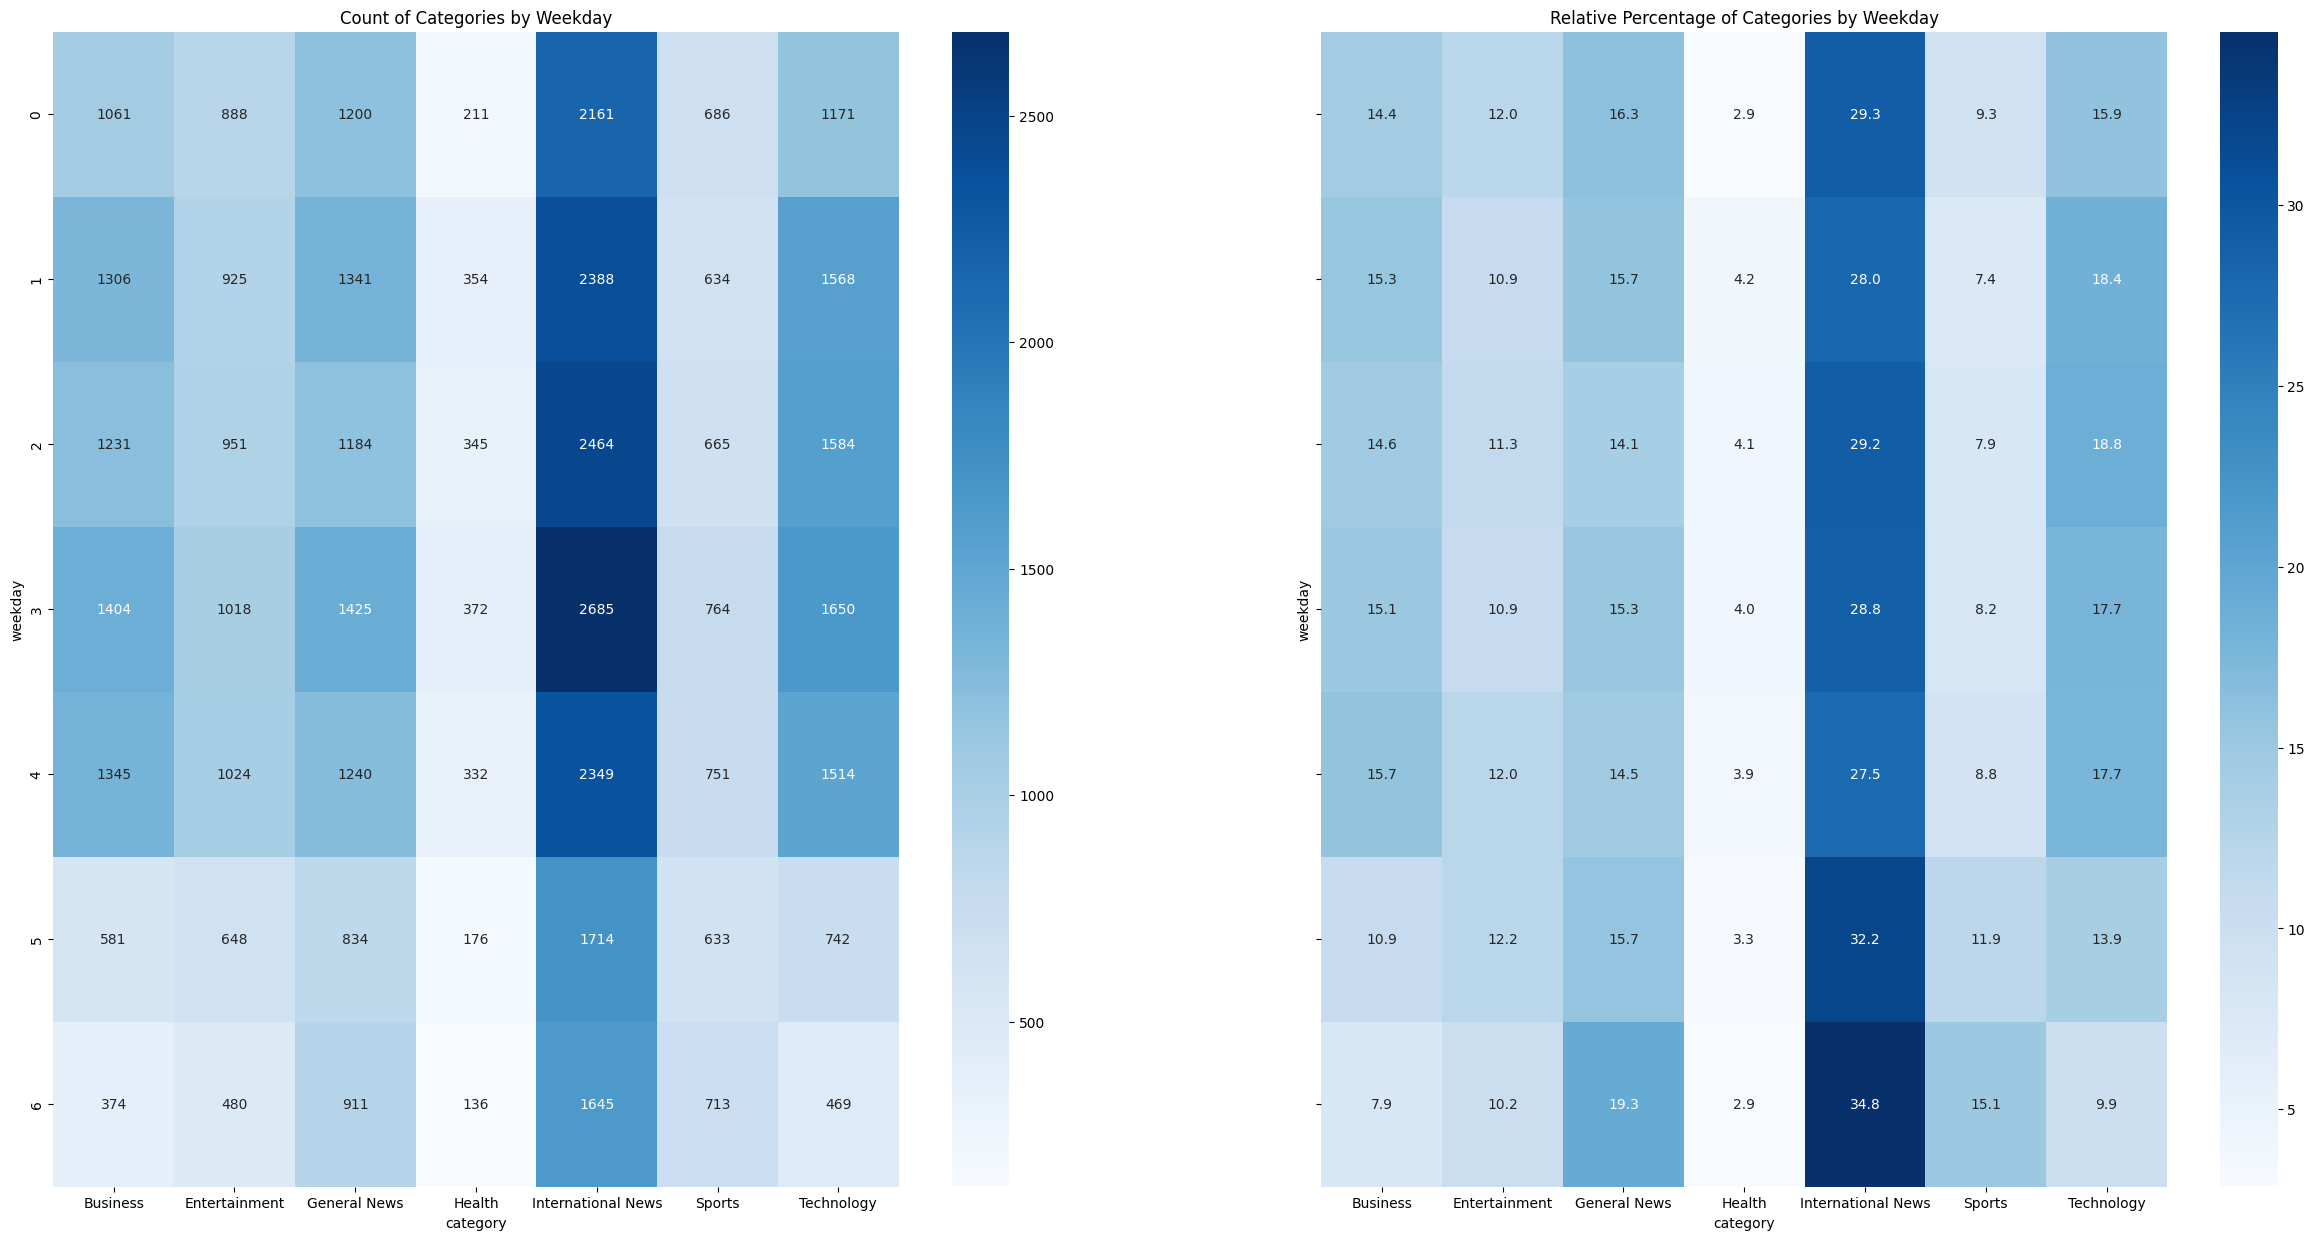

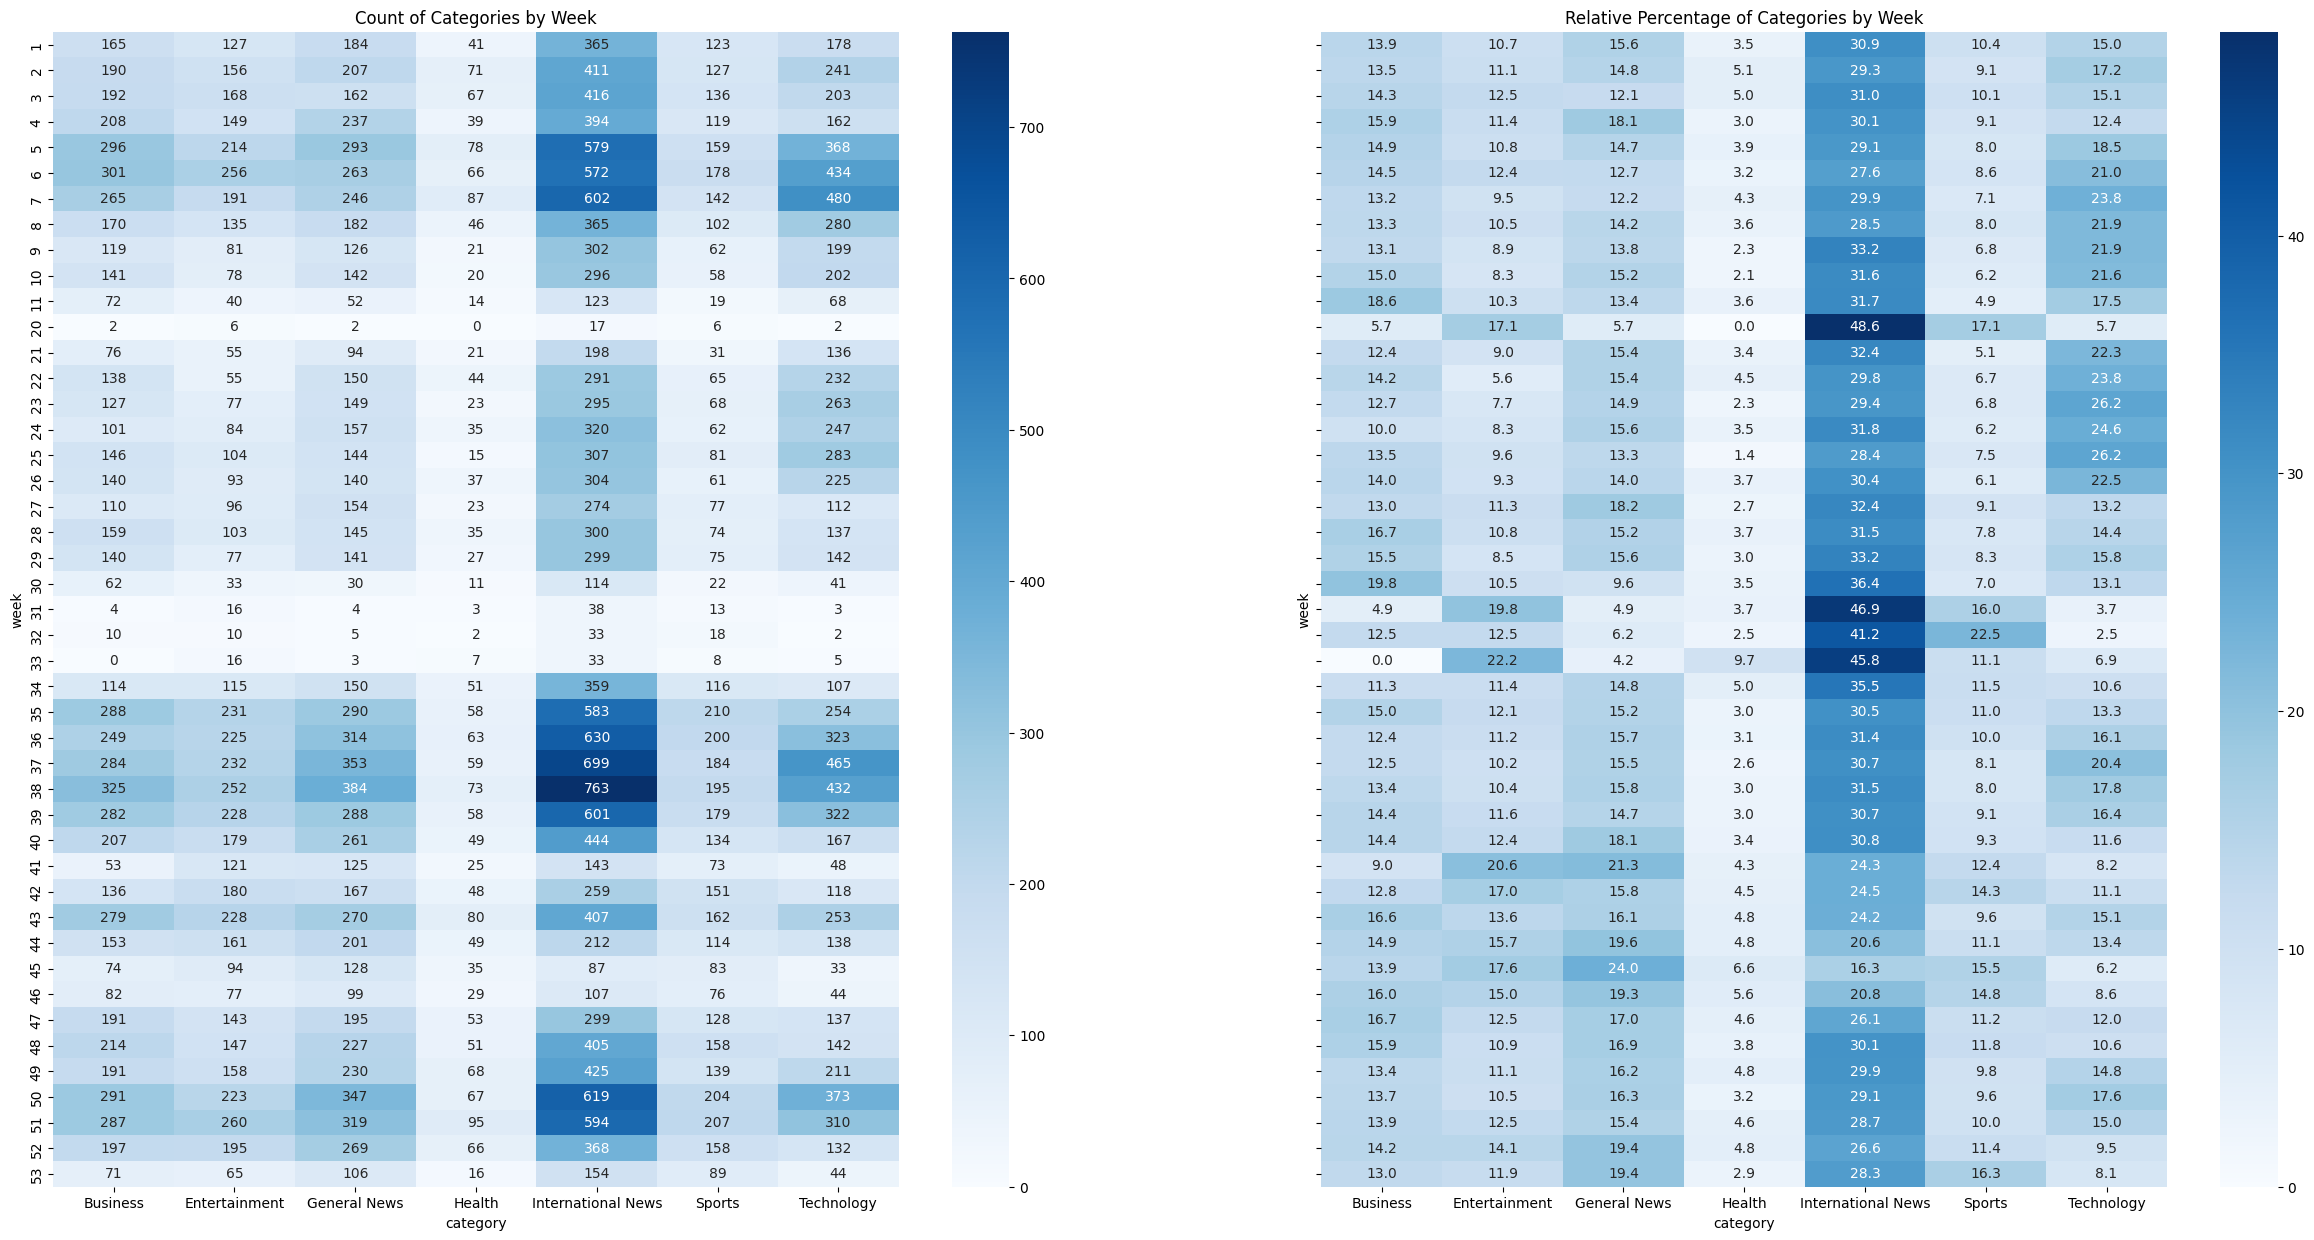

In [50]:
for col in ['year', 'month', 'day', 'hour', 'weekday', 'week']:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 15), sharey=True)
    
    matrix = dev_df.groupby([col, 'category']).size().unstack(fill_value=0)
    relative_matrix = (matrix.T / matrix.sum(axis=1)).T * 100
    
    sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', ax=ax1)
    sns.heatmap(relative_matrix, annot=True, fmt='.1f', cmap='Blues', ax=ax2)
    
    ax1.set_title(f'Count of Categories by {col.capitalize()}')
    ax2.set_title(f'Relative Percentage of Categories by {col.capitalize()}')
   


#### Hetmaps of the top 5 sources per category vs timestamp (year, month, ...)

Text(0.5, 1.0, 'Relative Percentage of Categories by Week for Top 5 Sources per category')

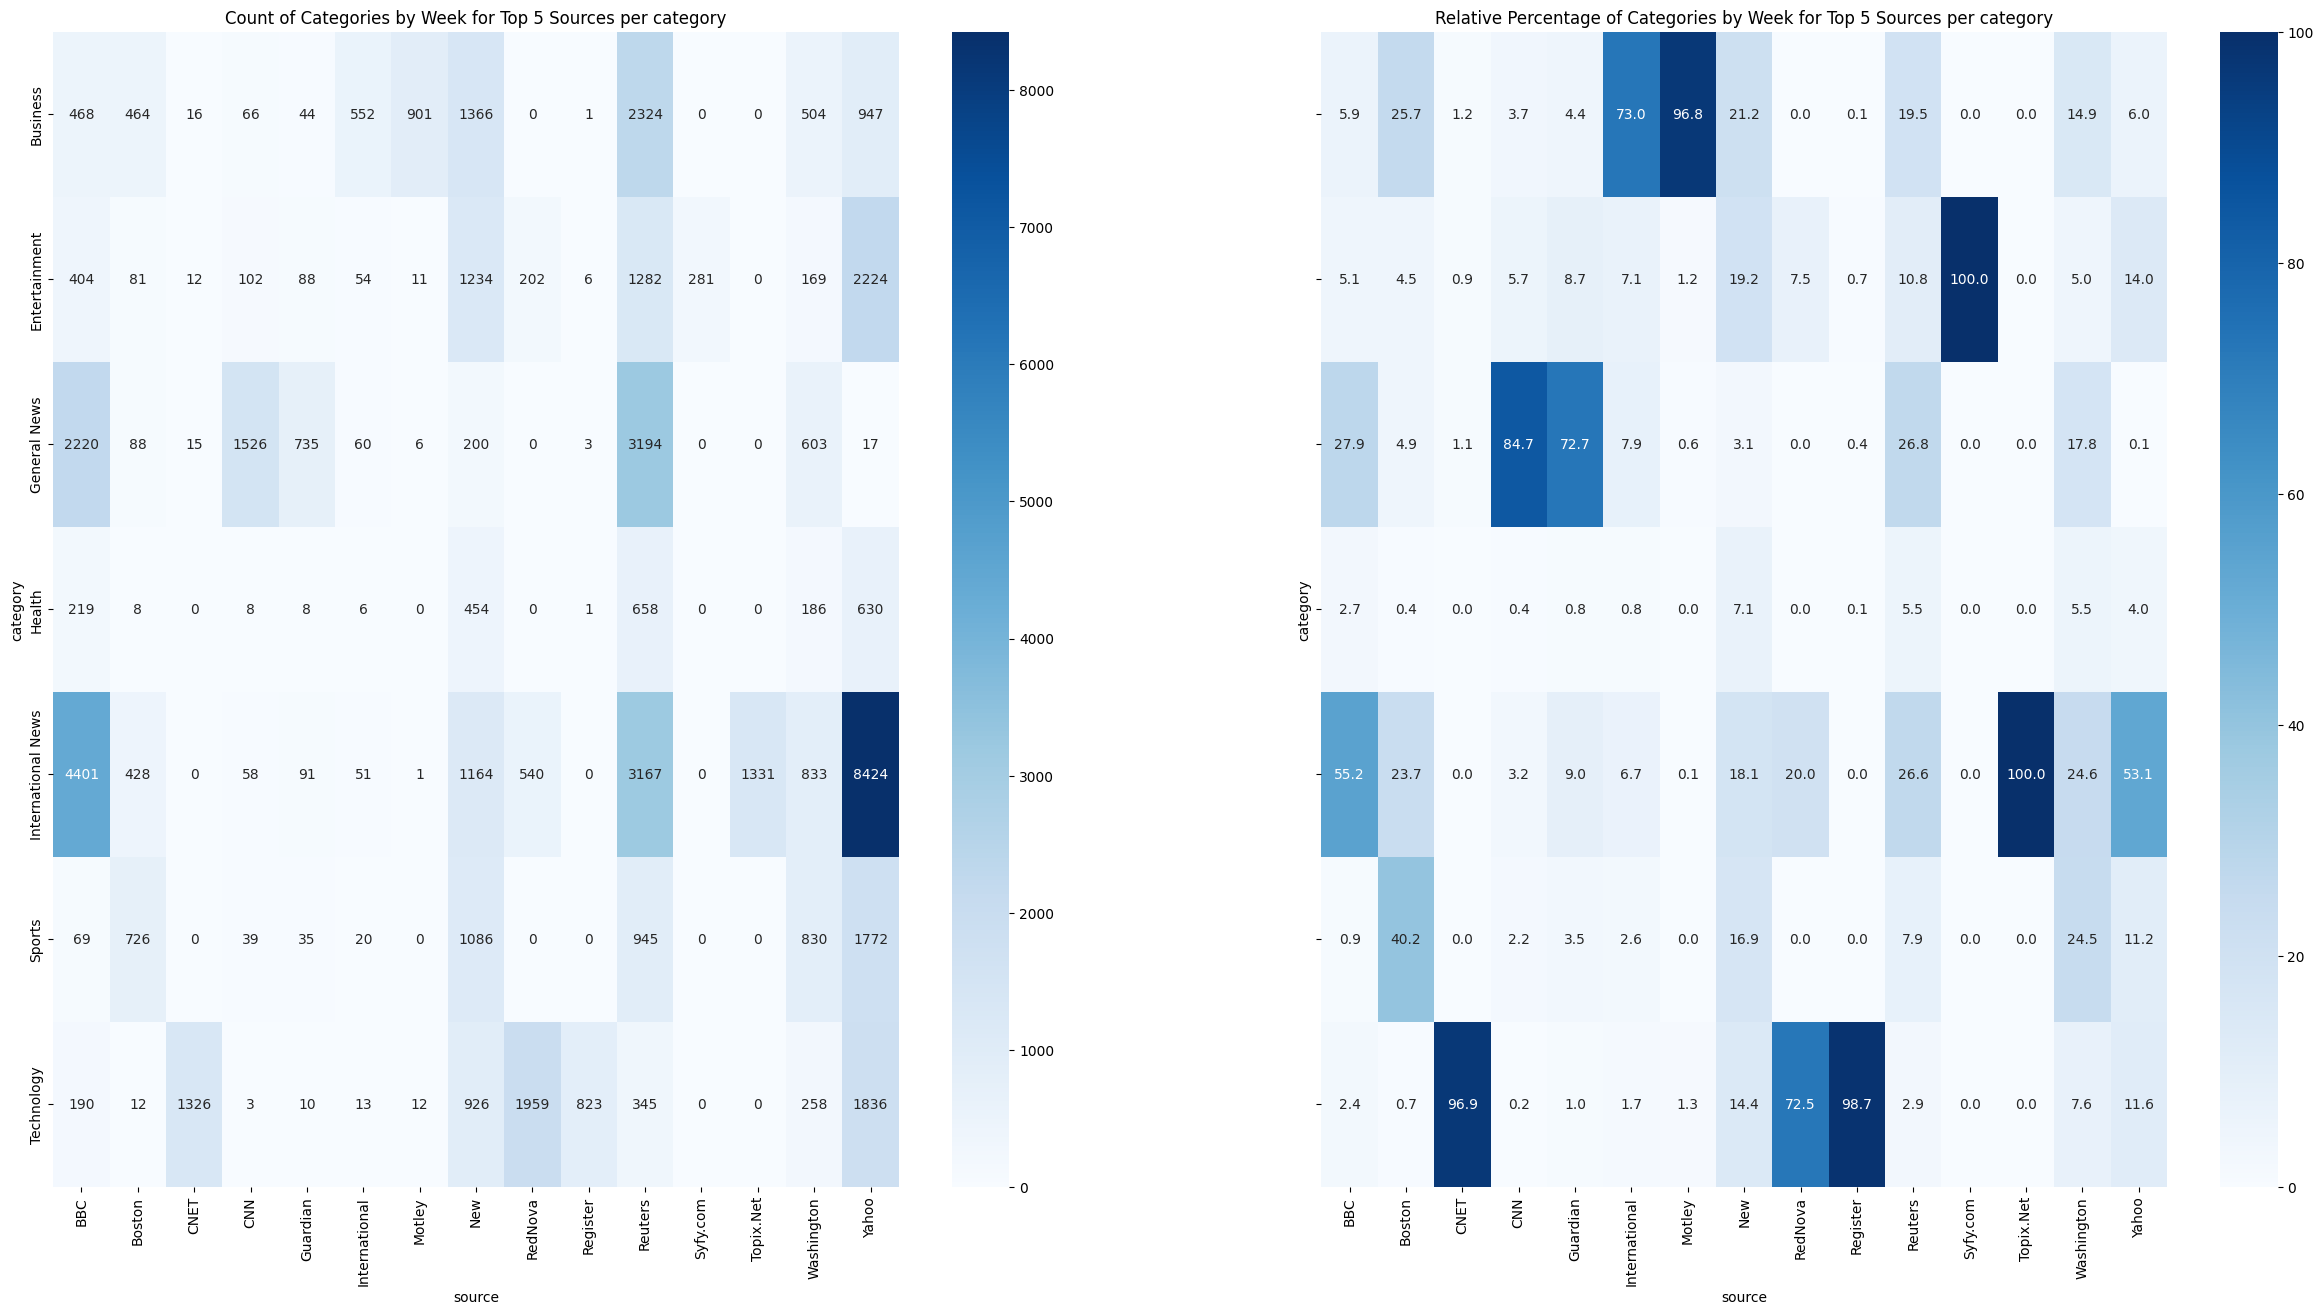

In [51]:
grouped = dev_df.groupby(by = ['category', 'source']).size()
top_5_sources = grouped.groupby(level=0, group_keys=False).nlargest(5)


top_5_sources = top_5_sources.reset_index(name='count')['source'].unique()

top_5_sources


dev_df_top_sources = dev_df[dev_df['source'].isin(top_5_sources)]


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 15), sharey=True)
matrix = dev_df_top_sources.groupby(['category', 'source']).size().unstack(fill_value=0)
relative_matrix = (matrix / matrix.sum(axis=0)) * 100
    
sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', ax=ax1)
sns.heatmap(relative_matrix, annot=True, fmt='.1f', cmap='Blues', ax=ax2)
    
ax1.set_title(f'Count of Categories by {col.capitalize()} for Top 5 Sources per category')
ax2.set_title(f'Relative Percentage of Categories by {col.capitalize()} for Top 5 Sources per category')



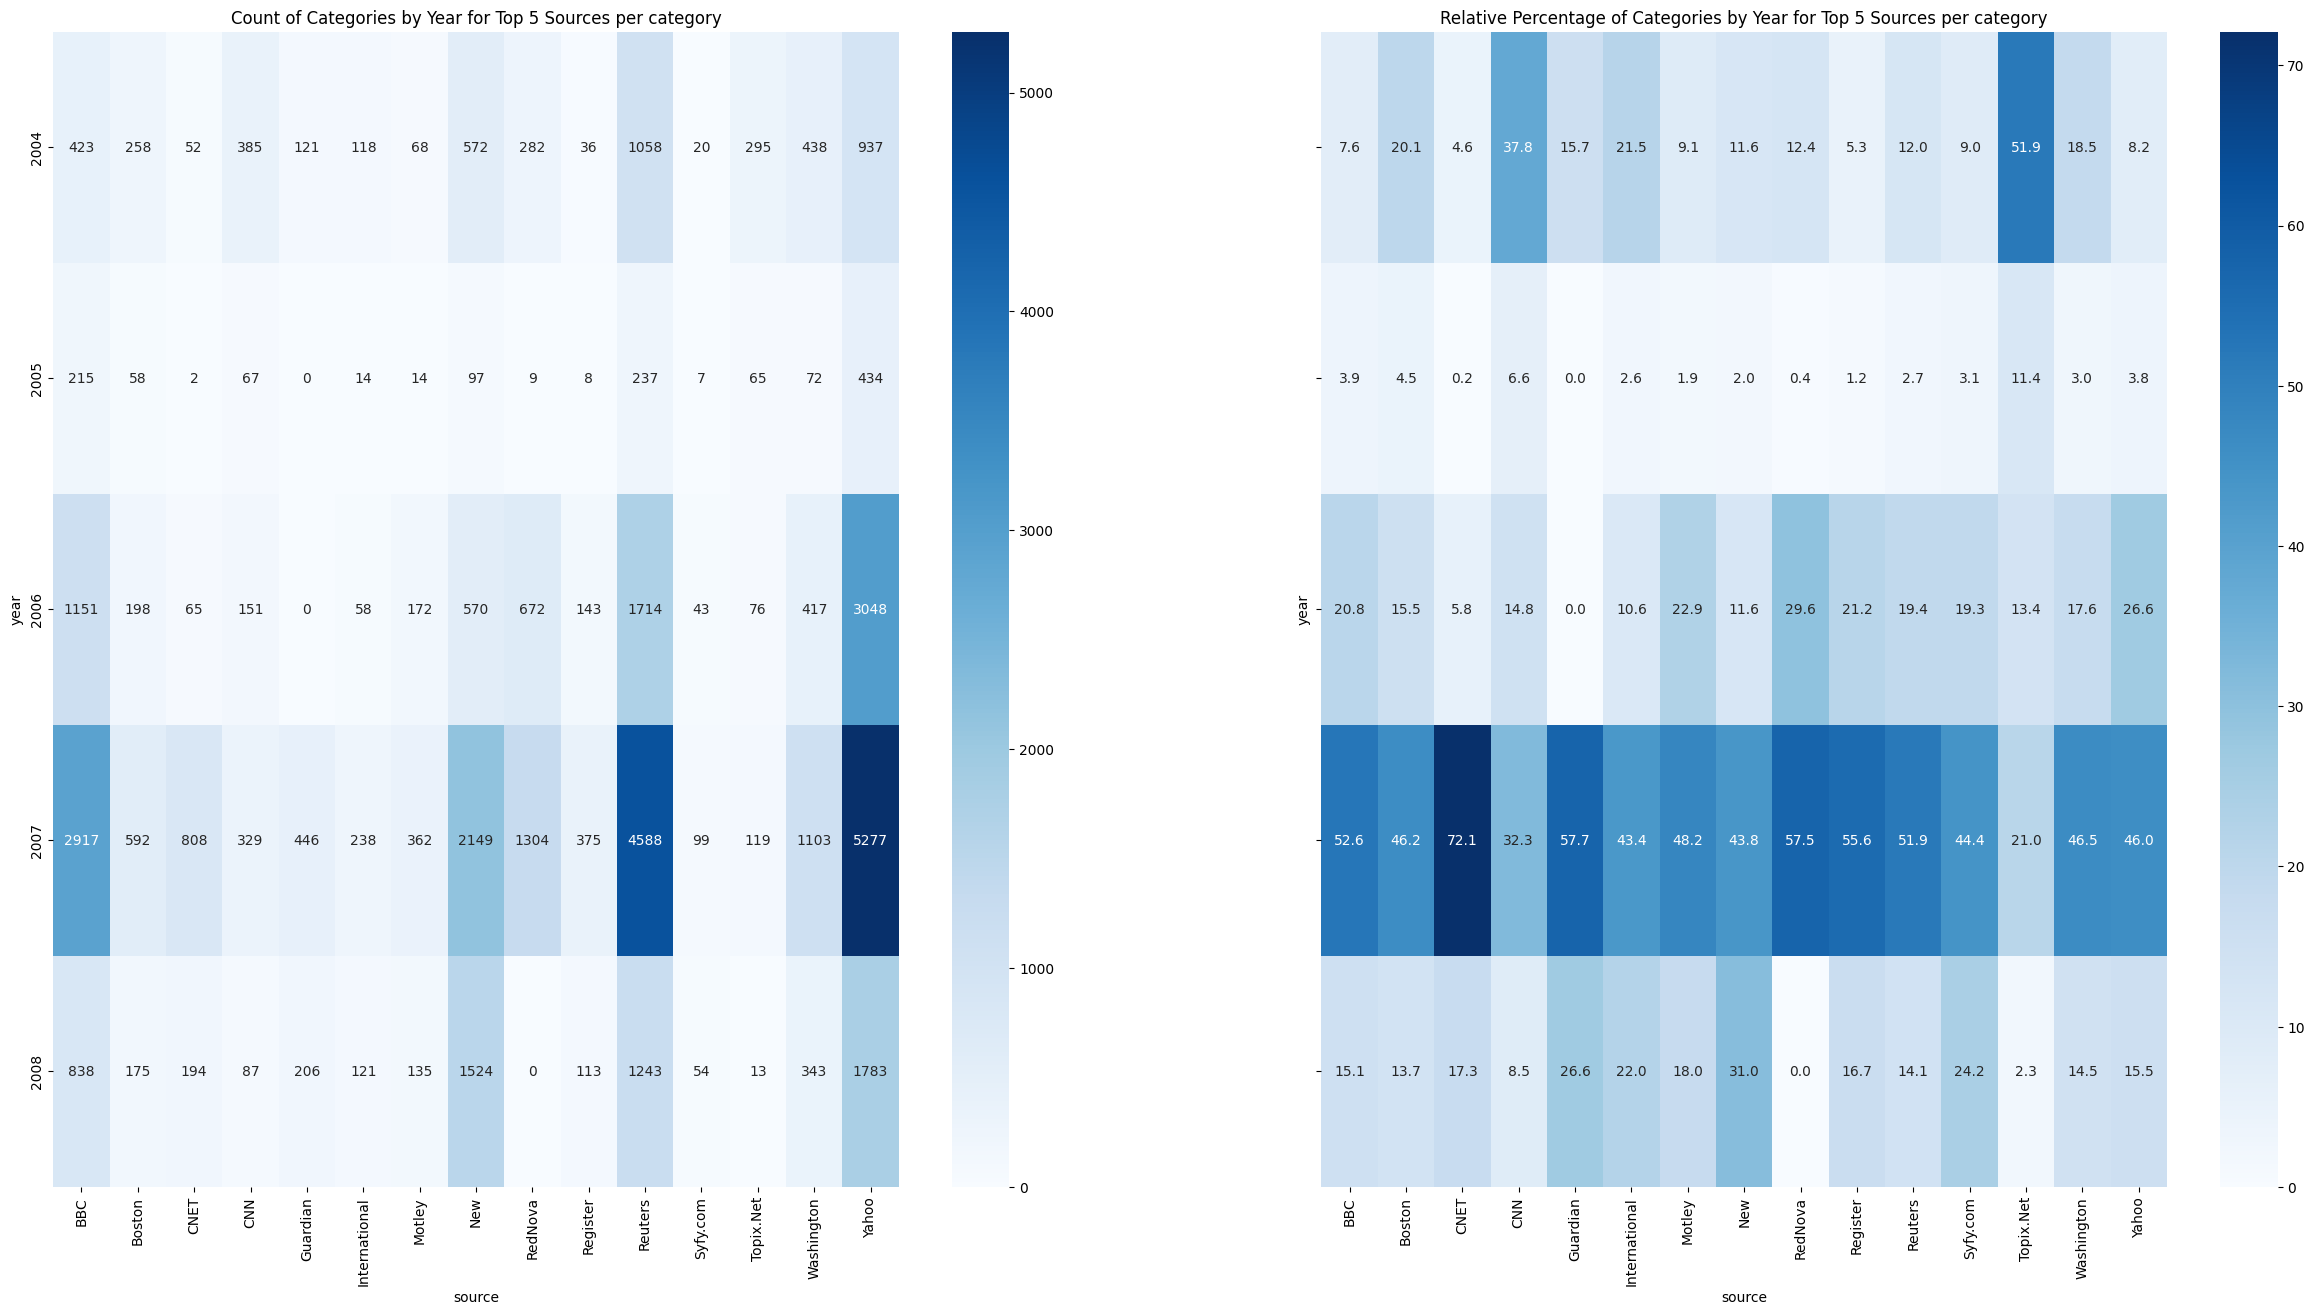

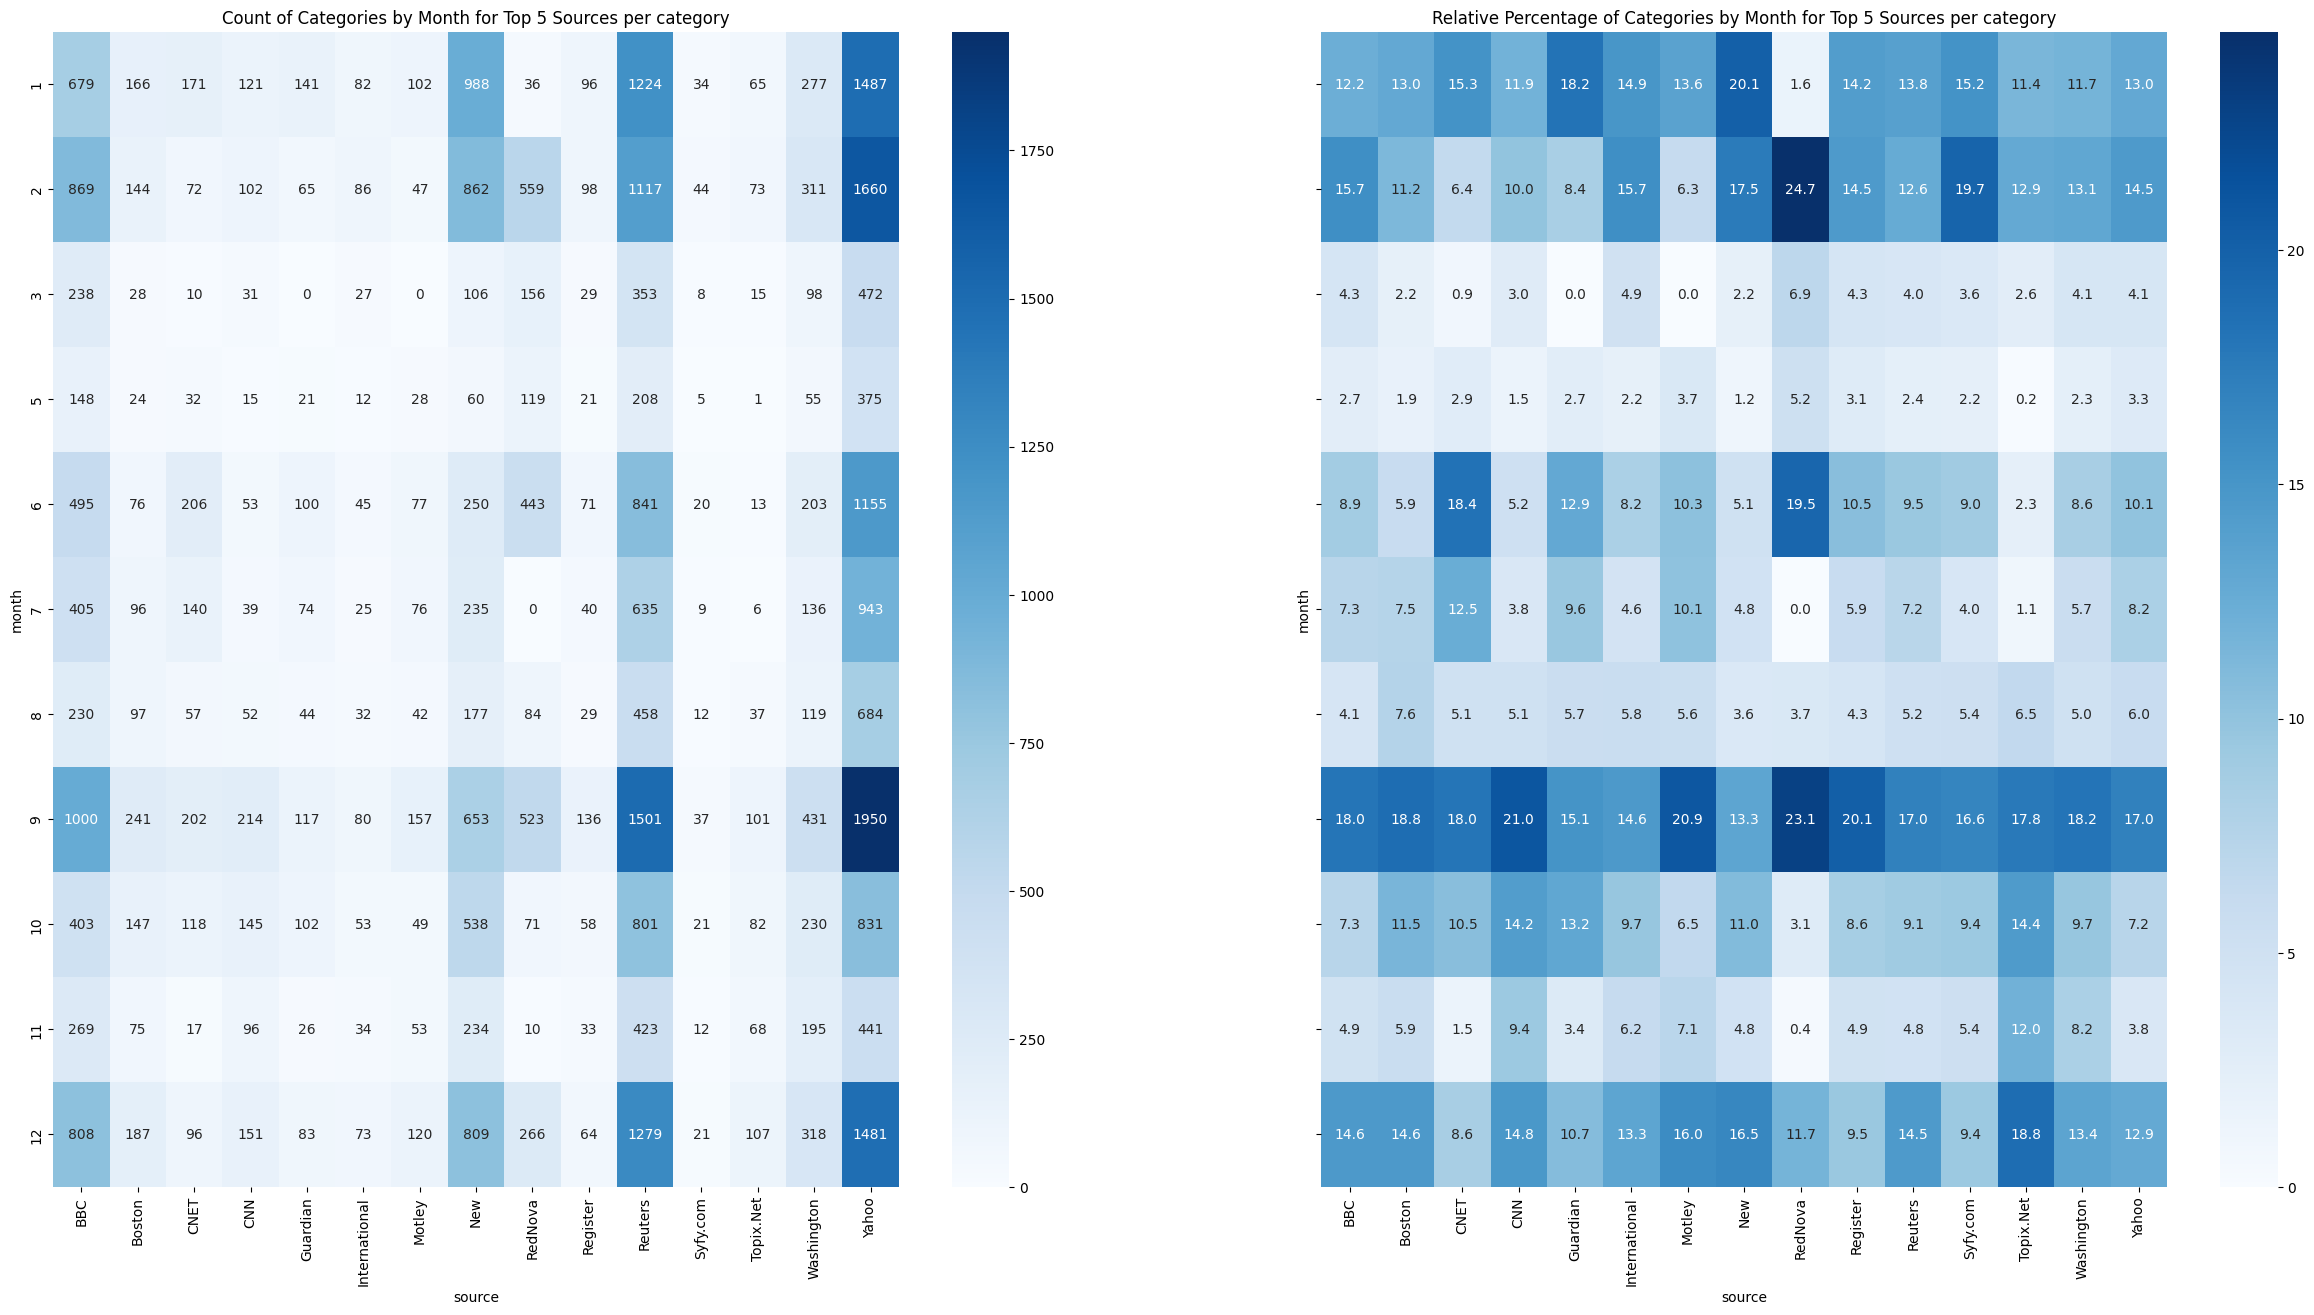

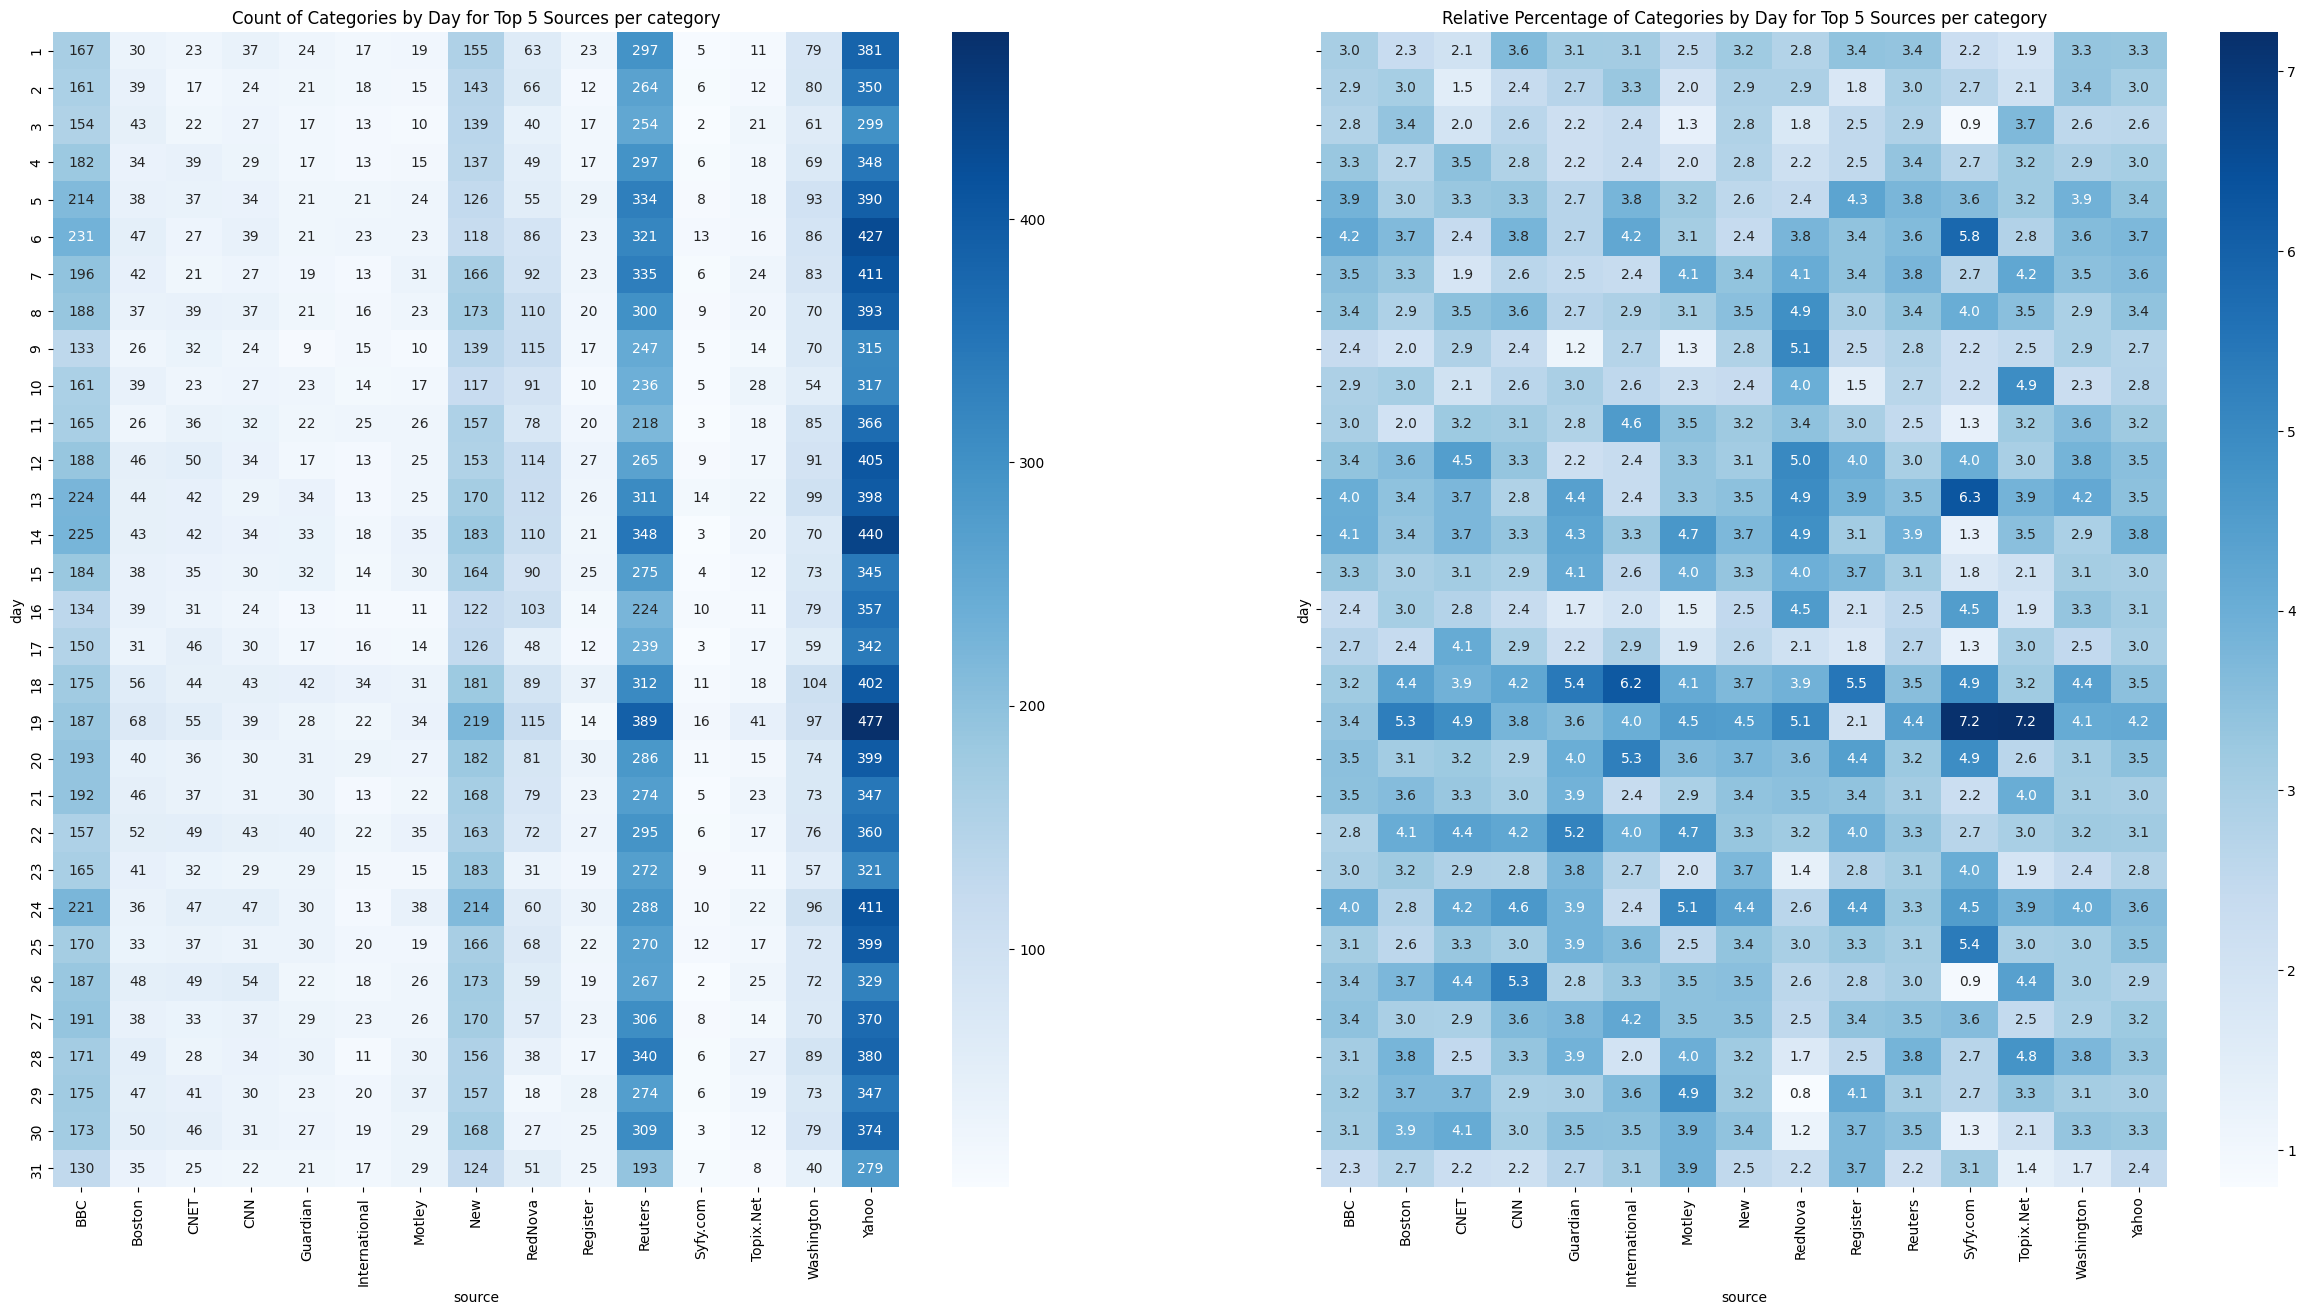

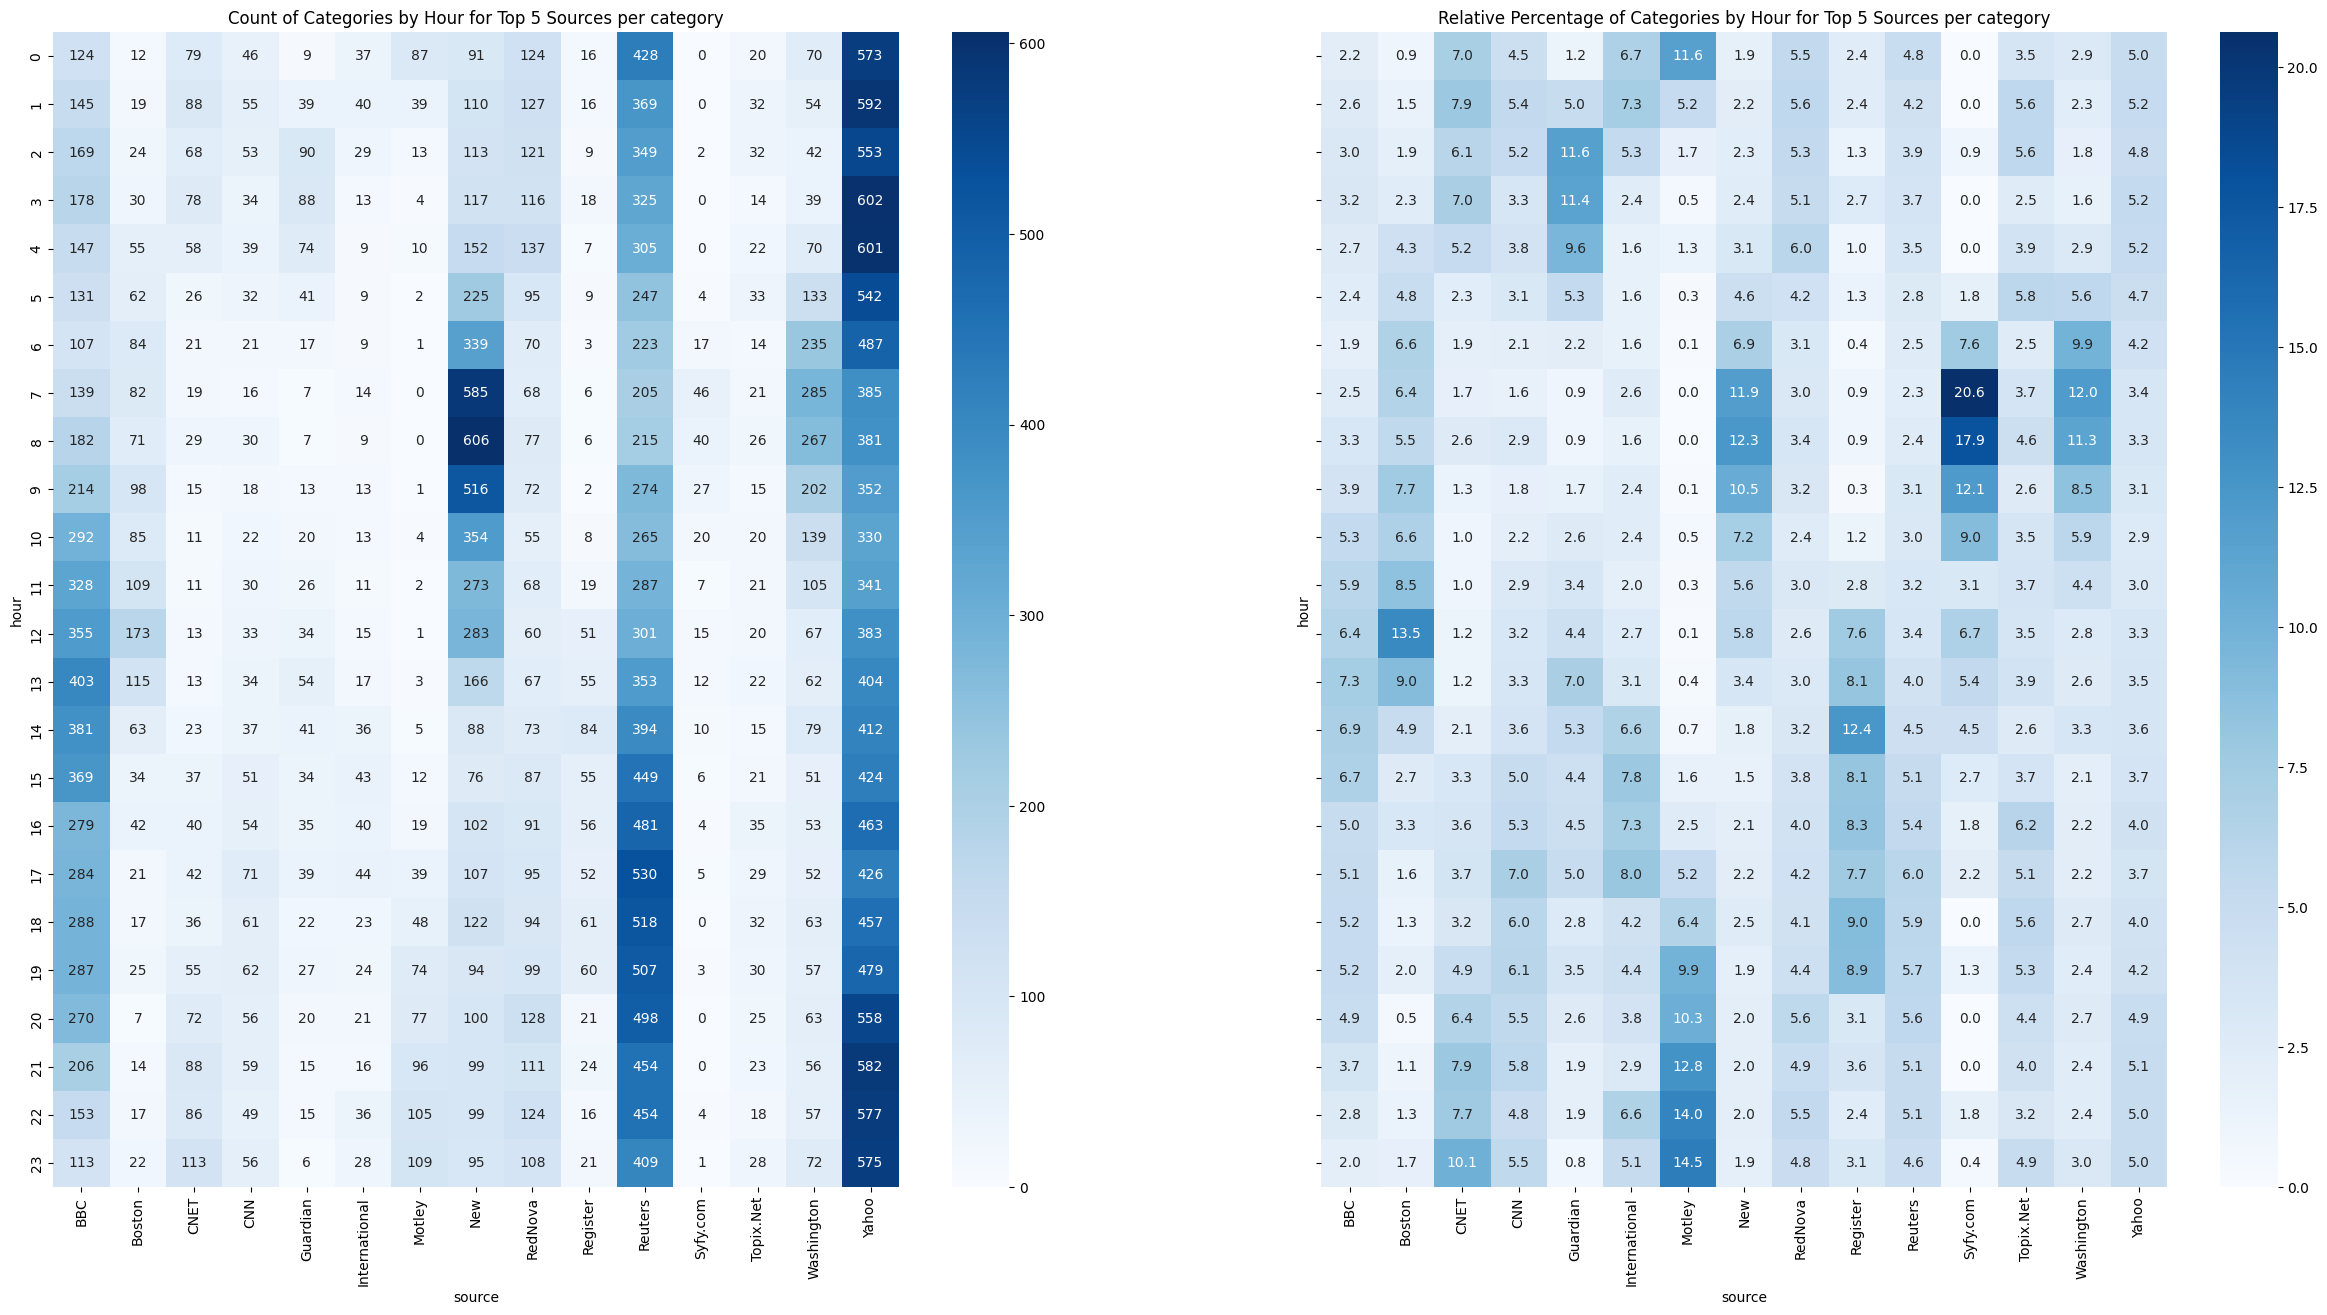

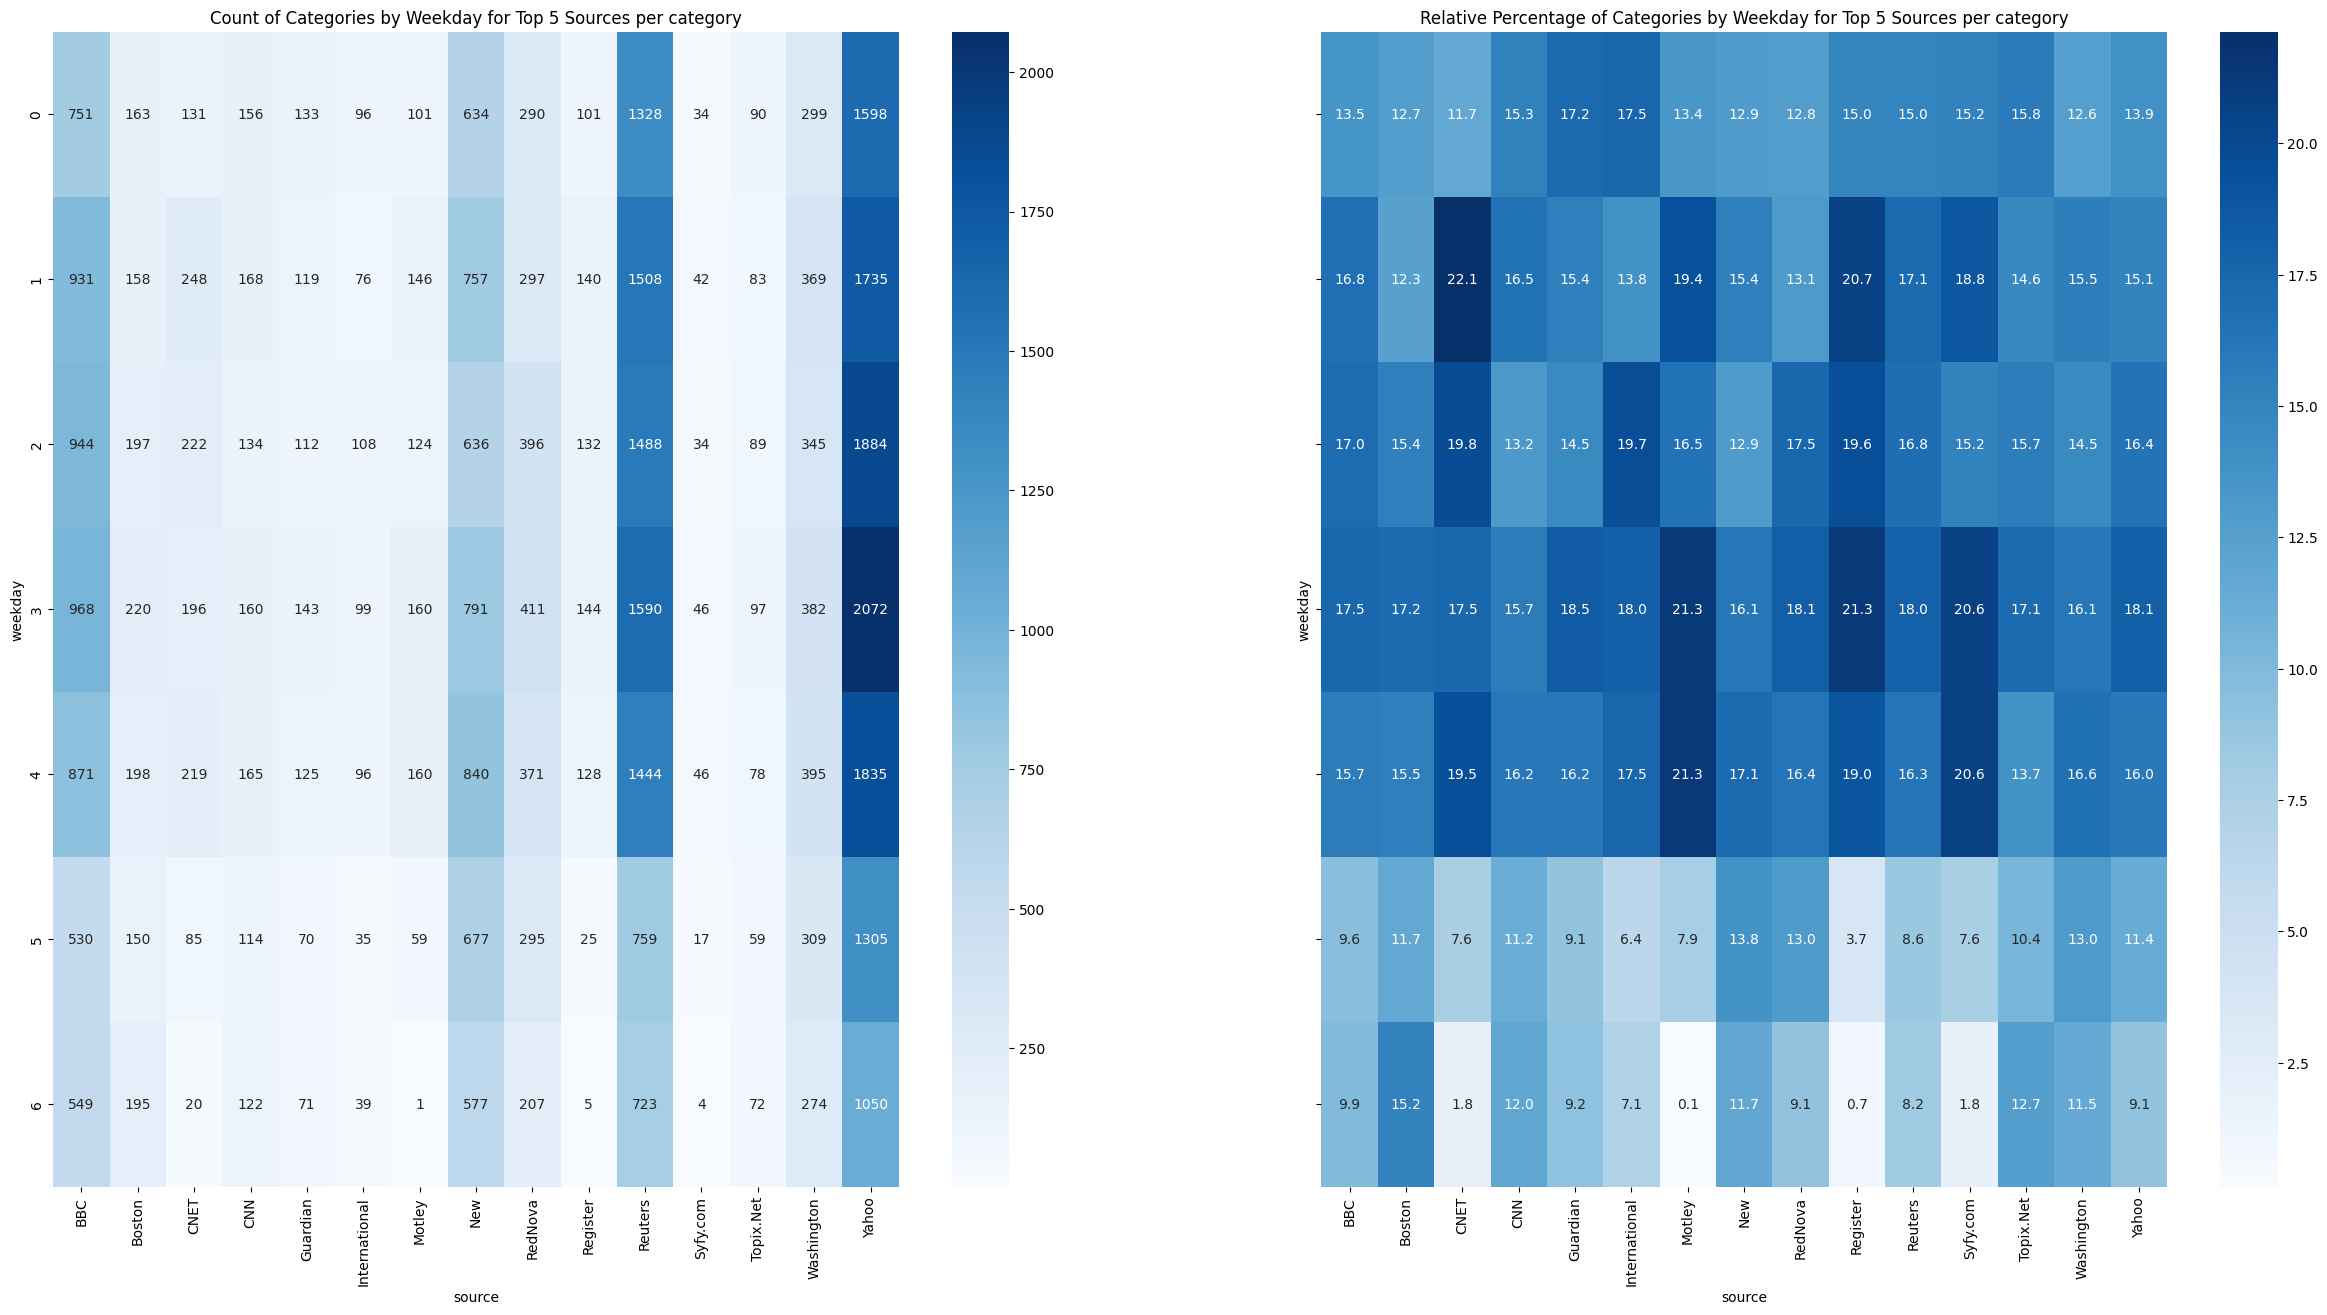

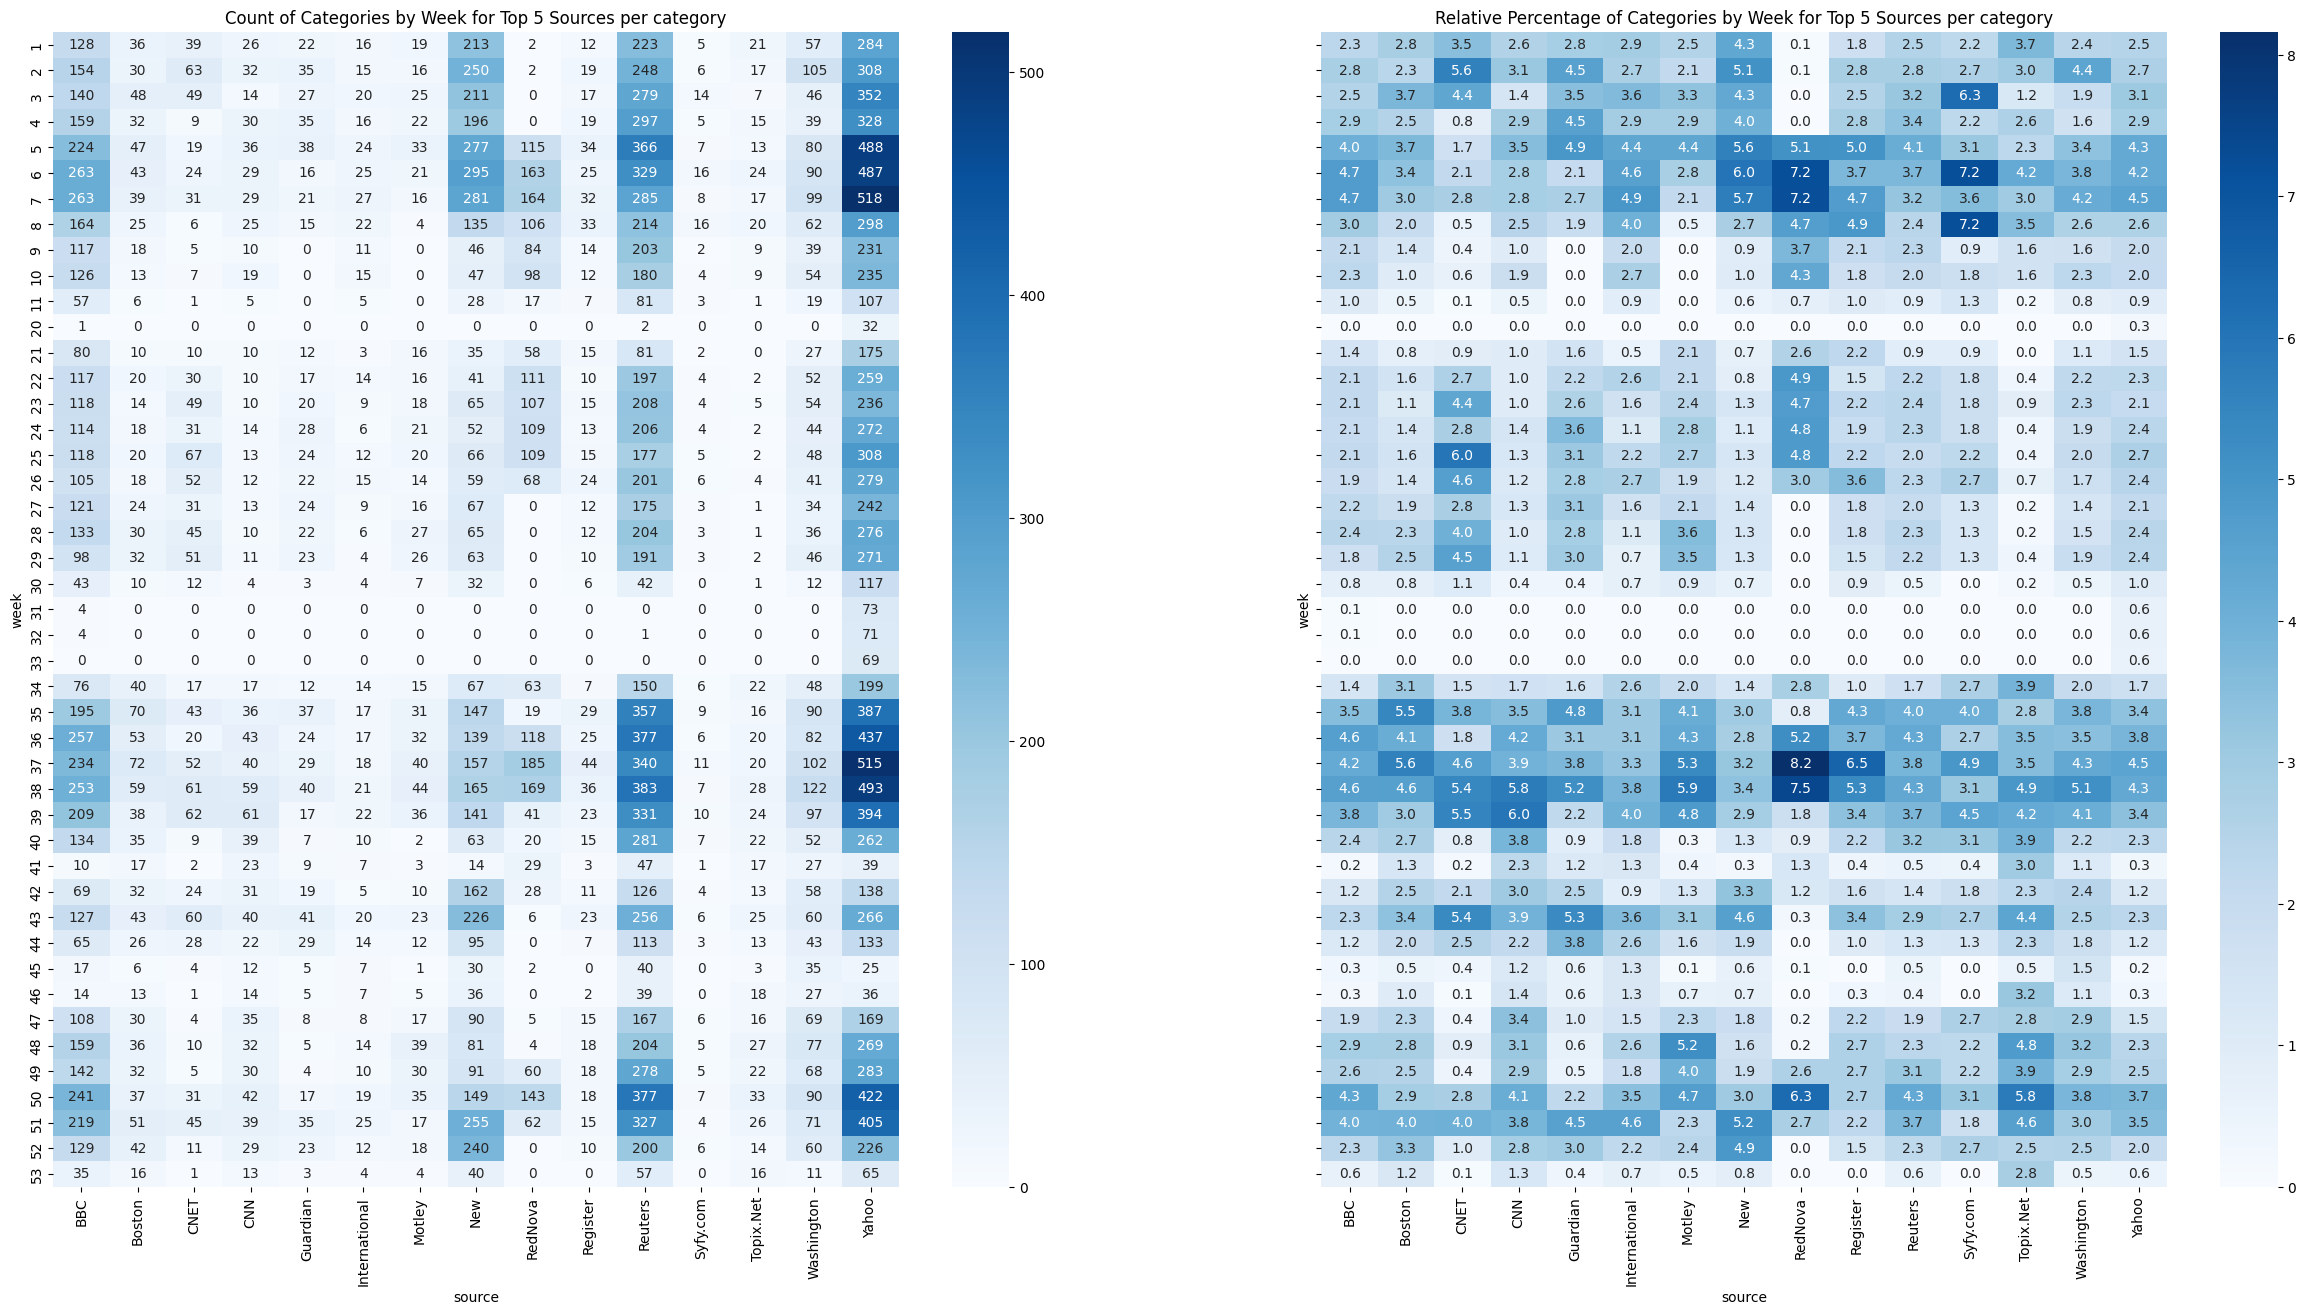

In [52]:
for col in ['year', 'month', 'day', 'hour', 'weekday', 'week']:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 15), sharey=True)
    
    matrix = dev_df_top_sources.groupby([col, 'source']).size().unstack(fill_value=0)
    relative_matrix = (matrix / matrix.sum(axis=0)) * 100
    
    sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', ax=ax1)
    sns.heatmap(relative_matrix, annot=True, fmt='.1f', cmap='Blues', ax=ax2)
    
    ax1.set_title(f'Count of Categories by {col.capitalize()} for Top 5 Sources per category')
    ax2.set_title(f'Relative Percentage of Categories by {col.capitalize()} for Top 5 Sources per category')

#### Top 5 sources by category

Text(0.5, 1.0, 'Relative Percentage of Categories by Week for Top 5 Sources per category')

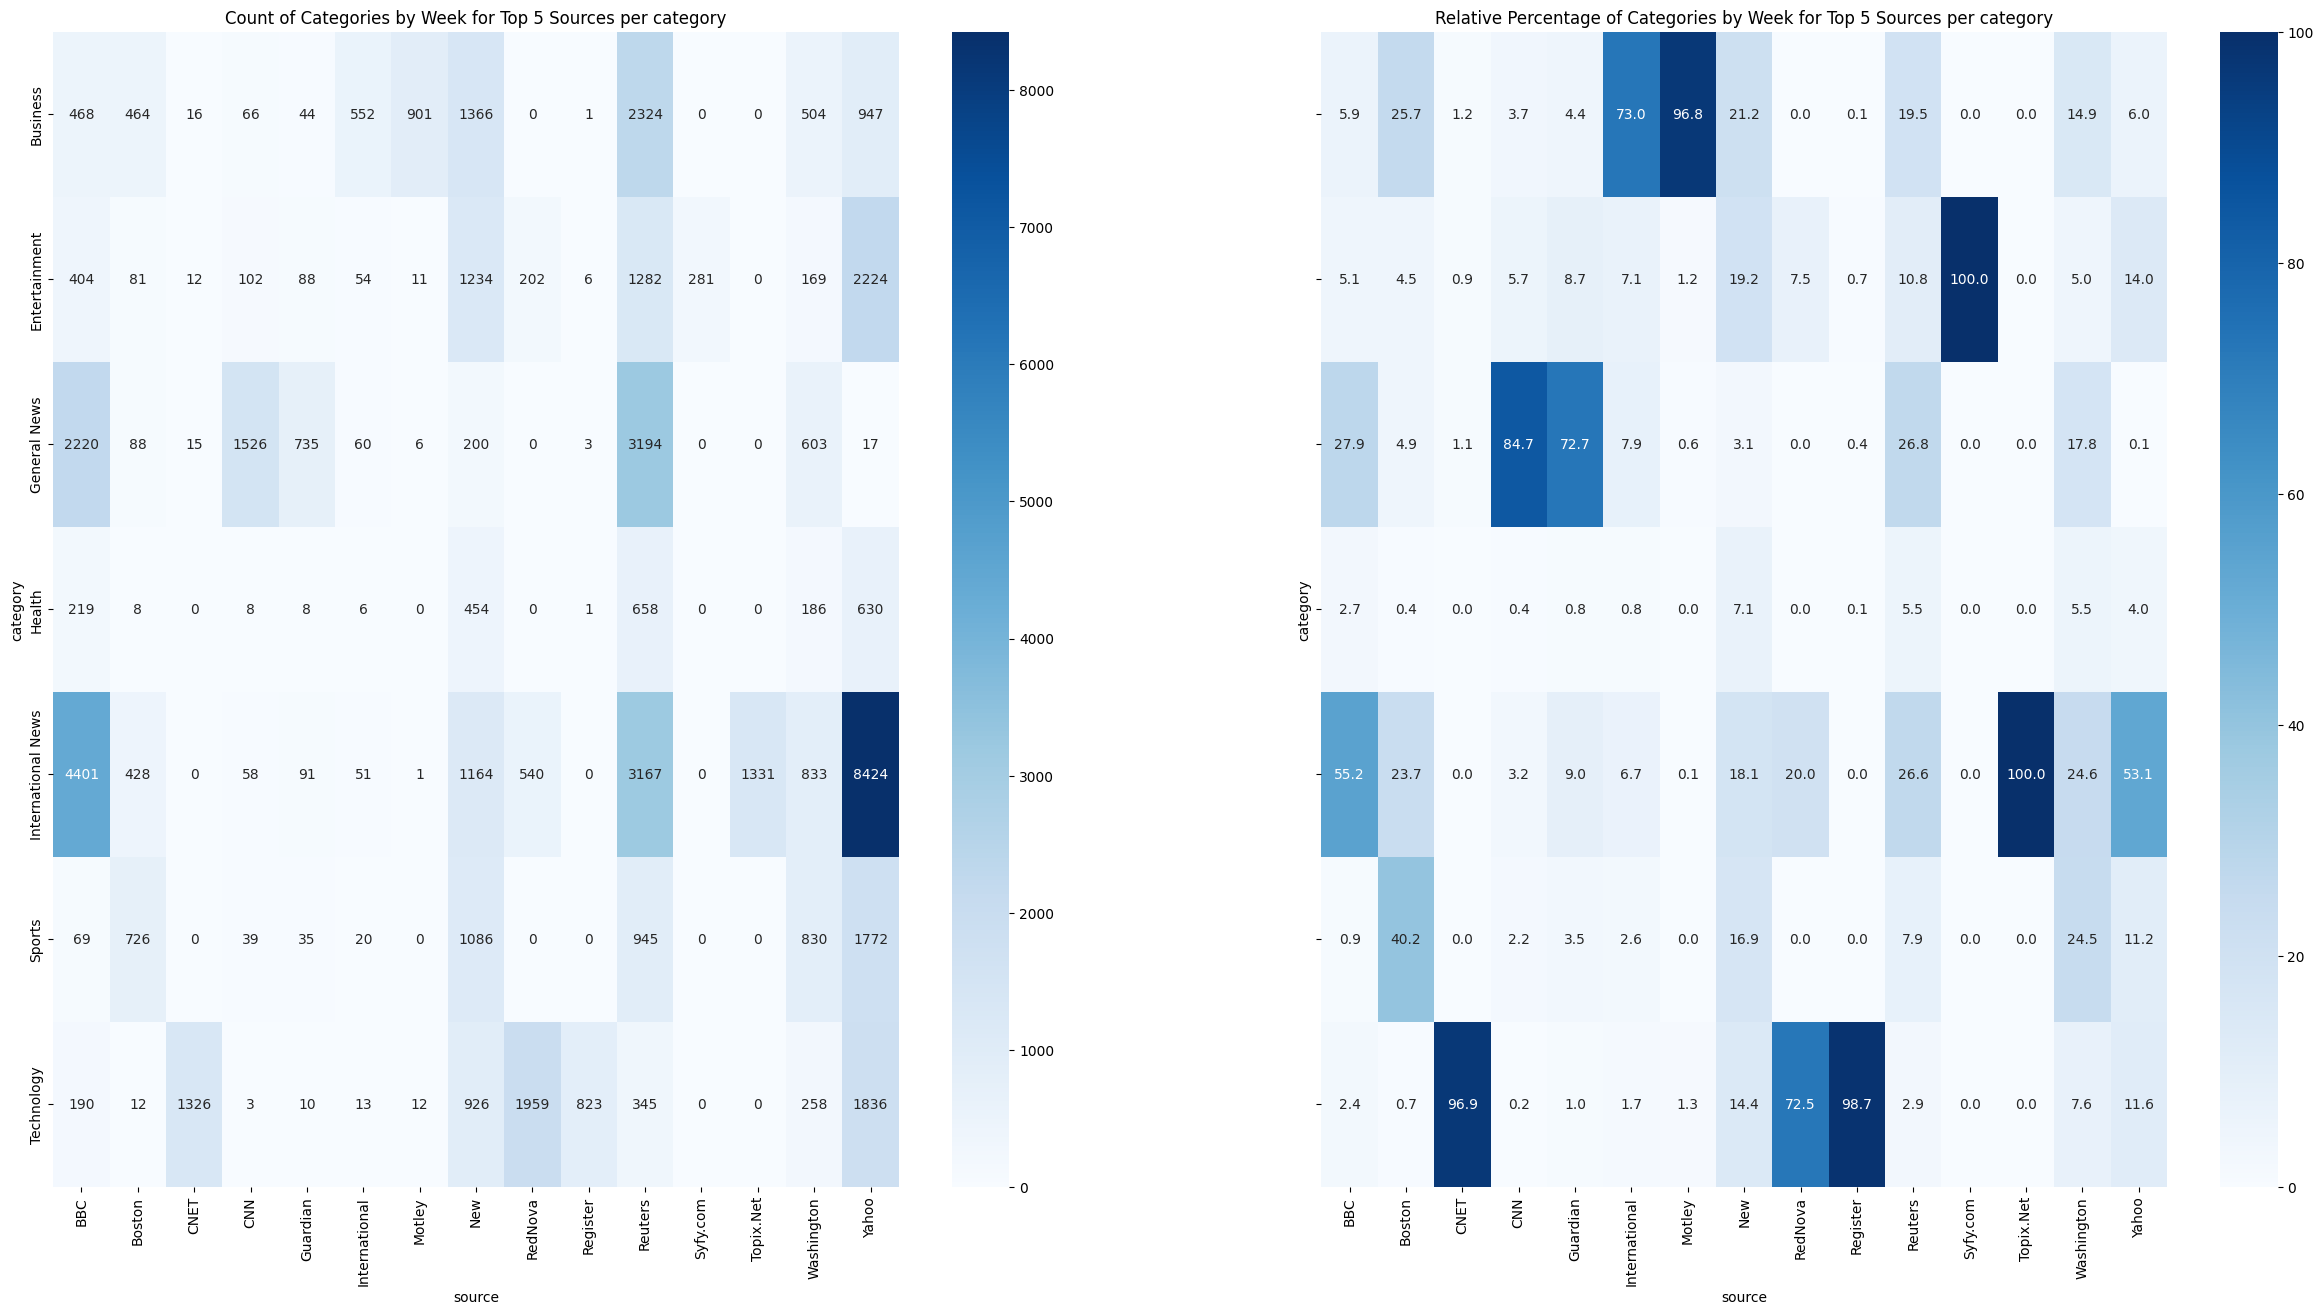

In [53]:
grouped = dev_df.groupby(by = ['category', 'source']).size()
top_5_sources = grouped.groupby(level=0, group_keys=False).nlargest(5)


top_5_sources = top_5_sources.reset_index(name='count')['source'].unique()

top_5_sources


dev_df_top_sources = dev_df[dev_df['source'].isin(top_5_sources)]


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 15), sharey=True)
matrix = dev_df_top_sources.groupby(['category', 'source']).size().unstack(fill_value=0)
relative_matrix = (matrix / matrix.sum(axis=0)) * 100
    
sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', ax=ax1)
sns.heatmap(relative_matrix, annot=True, fmt='.1f', cmap='Blues', ax=ax2)
    
ax1.set_title(f'Count of Categories by {col.capitalize()} for Top 5 Sources per category')
ax2.set_title(f'Relative Percentage of Categories by {col.capitalize()} for Top 5 Sources per category')

<Axes: title={'center': 'Category Distribution for Source: Wired'}, xlabel='category'>

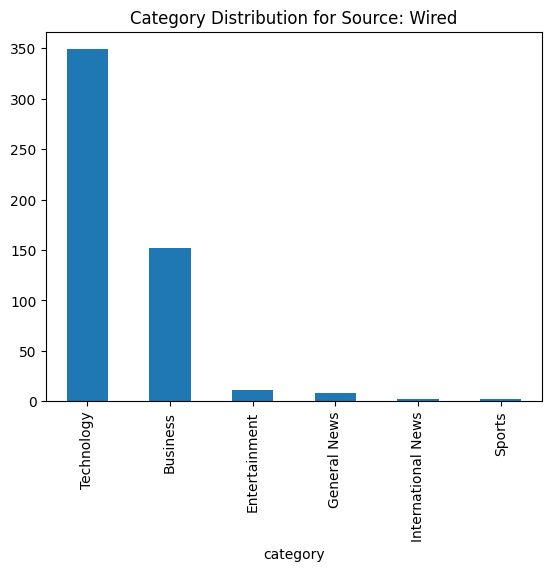

In [54]:
source = "Wired" 
#source = np.random.choice(dev_df['source'].unique(), size=1)[0]

dev_df[dev_df['source'] == source]['category'].value_counts().plot(kind='bar', title=f'Category Distribution for Source: {source}')

### Duplicates

#### Ok duplicates, i.e., same title, same source, same article, same label

In [55]:
small_dev_df = dev_df[['source','title','article','label']]
small_dev_df.duplicated().sum()

np.int64(1368)

In [56]:
grouped = small_dev_df.groupby(by = ['source','title','article', 'label'], as_index=False).size()
grouped[grouped['size'] >= 2].sort_values(by='size', ascending=False)

source                                              title  \
14202        CNN  ADV: Distance Learning Directory - Online Degrees   
14212        CNN       ADV: Health Insurance for the Self-Employed!   
14194        CNN        ADV: $150,000 Mortgage for Under $690/Month   
77198      Yahoo           Weather around the U.S.A. \\n    (AP)\\n   
14195        CNN        ADV: $175,000 Mortgage for Under $730/Month   
...          ...                                                ...   
30522        New       More Doctors in Texas After Malpractice Caps   
30528        New         More Questions for Producer of Flu Vaccine   
30529        New  More Testing of Seafood to Address Mercury Con...   
30546        New                    Mother Natureâs Restless Sons   
78622  swissinfo                     World unprepared for avian flu   

                                                 article  label  size  
14202  Bachelor, Master and Post-Grad degrees online ...      5    16  
14212  Affordable health, dental, and life insurance ...      5    15  
14194  Mortgage rates are at record lows. Save $1000s...      5    13  
77198                     AP - Weather around the U.S.A.      2    11  
14195  Mortgage rates are at record lows. Save $1000s...      5    10  
...                                                  ...    ...   ...  
30522  After Texas limited awards in medical malpract...      6     2  
30528  The F.D.A. is demanding that Chiron provide mo...      6     2  
30529  Some restaurants and retailers around the coun...      6     2  
30546  Sean Penn finds a kindred spirit in the hero o...      3     2  
78622  &quot;We believe with the current influenza va...      3     2  

[1131 rows x 5 columns]

In [57]:
dev_df[(dev_df['source'] == 'CNN') & (dev_df['title'] == 'ADV: Distance Learning Directory - Online Degrees') & (dev_df['article'] == "Bachelor, Master and Post-Grad degrees online from accredited colleges and universities. Business, Education, IT, Healthcare, more. Browse by degree or program. Request info and get started today.")].sort_values(by='label')

Id source                                              title  \
15603  15603    CNN  ADV: Distance Learning Directory - Online Degrees   
16212  16212    CNN  ADV: Distance Learning Directory - Online Degrees   
18737  18737    CNN  ADV: Distance Learning Directory - Online Degrees   
31551  31551    CNN  ADV: Distance Learning Directory - Online Degrees   
44852  44852    CNN  ADV: Distance Learning Directory - Online Degrees   
45703  45703    CNN  ADV: Distance Learning Directory - Online Degrees   
46395  46395    CNN  ADV: Distance Learning Directory - Online Degrees   
46440  46440    CNN  ADV: Distance Learning Directory - Online Degrees   
48399  48399    CNN  ADV: Distance Learning Directory - Online Degrees   
50293  50293    CNN  ADV: Distance Learning Directory - Online Degrees   
54076  54076    CNN  ADV: Distance Learning Directory - Online Degrees   
65801  65801    CNN  ADV: Distance Learning Directory - Online Degrees   
74520  74520    CNN  ADV: Distance Learning Directory - Online Degrees   
74950  74950    CNN  ADV: Distance Learning Directory - Online Degrees   
75313  75313    CNN  ADV: Distance Learning Directory - Online Degrees   
78232  78232    CNN  ADV: Distance Learning Directory - Online Degrees   

                                                 article  page_rank  \
15603  Bachelor, Master and Post-Grad degrees online ...          5   
16212  Bachelor, Master and Post-Grad degrees online ...          5   
18737  Bachelor, Master and Post-Grad degrees online ...          5   
31551  Bachelor, Master and Post-Grad degrees online ...          5   
44852  Bachelor, Master and Post-Grad degrees online ...          5   
45703  Bachelor, Master and Post-Grad degrees online ...          5   
46395  Bachelor, Master and Post-Grad degrees online ...          5   
46440  Bachelor, Master and Post-Grad degrees online ...          5   
48399  Bachelor, Master and Post-Grad degrees online ...          5   
50293  Bachelor, Master and Post-Grad degrees online ...          5   
54076  Bachelor, Master and Post-Grad degrees online ...          5   
65801  Bachelor, Master and Post-Grad degrees online ...          5   
74520  Bachelor, Master and Post-Grad degrees online ...          5   
74950  Bachelor, Master and Post-Grad degrees online ...          5   
75313  Bachelor, Master and Post-Grad degrees online ...          5   
78232  Bachelor, Master and Post-Grad degrees online ...          5   

                 timestamp  label      category       timestamp_new  year  \
15603  0000-00-00 00:00:00      5  General News                 NaT  <NA>   
16212  2004-10-02 18:22:59      5  General News 2004-10-02 18:22:59  2004   
18737  2004-08-21 05:23:30      5  General News 2004-08-21 05:23:30  2004   
31551  2004-10-25 10:02:00      5  General News 2004-10-25 10:02:00  2004   
44852  0000-00-00 00:00:00      5  General News                 NaT  <NA>   
45703  0000-00-00 00:00:00      5  General News                 NaT  <NA>   
46395  2004-10-03 05:27:22      5  General News 2004-10-03 05:27:22  2004   
46440  0000-00-00 00:00:00      5  General News                 NaT  <NA>   
48399  0000-00-00 00:00:00      5  General News                 NaT  <NA>   
50293  2004-11-20 19:59:57      5  General News 2004-11-20 19:59:57  2004   
54076  2004-11-18 01:21:03      5  General News 2004-11-18 01:21:03  2004   
65801  0000-00-00 00:00:00      5  General News                 NaT  <NA>   
74520  0000-00-00 00:00:00      5  General News                 NaT  <NA>   
74950  0000-00-00 00:00:00      5  General News                 NaT  <NA>   
75313  2004-11-11 20:43:51      5  General News 2004-11-11 20:43:51  2004   
78232  2004-09-26 01:03:08      5  General News 2004-09-26 01:03:08  2004   

       month   day  hour  weekday  week  
15603   <NA>  <NA>  <NA>     <NA>  <NA>  
16212     10     2    18        5    40  
18737      8    21     5        5    34  
31551     10    25    10        0    44  
44852   <NA>  <NA>  <NA

#### Non-oj duplicates, i.e., same title, same source, same article, different label

In [58]:
grouped = small_dev_df.groupby(by = ['source','title','article'], as_index=False)['label'].agg({'nunique'})
grouped[grouped['nunique'] >= 2].sort_values(by='nunique', ascending=False)

source                                              title  \
45614       Reuters      Paris Hilton starts serving jail term: lawyer   
30589           New            Radioâs Challenge: Counting the Young   
25510        Motley                               Is Apple Photogenic?   
41567       Reuters  Father of Indian Reforms, Former PM Rao Dies a...   
3479            BBC                   Czech anger at caged beds report   
...             ...                                                ...   
17509  DMeurope.com                   JFK assassination game draws ire   
17507  DMeurope.com  Global mobile handset sales up 35% in second q...   
17502            DM        Microsoft Delays New Windows Search Feature   
17481     Cybercast  Democratic National Committee &#39;Action Aler...   
77102     swissinfo                                  Myanmar PM ousted   

                                                 article  nunique  
45614  LOS ANGELES (Reuters) - Admitting she was frig...        3  
30589  The electronic audience measurement tool, the ...        3  
25510  With competitors avidly trying to nibble at th...        3  
41567  Former Indian Prime Minister PV Narasimha Rao,...        3  
3479   A Czech minister says a BBC report on caged be...        3  
...                                                  ...      ...  
17509  A video game released to coincide with the 41s...        2  
17507  Worldwide mobile phone sales surpassed 156.4m ...        2  
17502  Microsoft will release its long-awaited update...        2  
17481  Back in February, President Bush sat down in t...        2  
77102  Khin Nyunt&#39;s removal, yet to be confirmed ...        2  

[1472 rows x 4 columns]

In [59]:
dev_df[(dev_df['source'] == 'Reuters') & (dev_df['title'] == 'Paris Hilton starts serving jail term: lawyer')].sort_values(by='label')

Id   source                                          title  \
7089    7089  Reuters  Paris Hilton starts serving jail term: lawyer   
29992  29992  Reuters  Paris Hilton starts serving jail term: lawyer   
15754  15754  Reuters  Paris Hilton starts serving jail term: lawyer   
44170  44170  Reuters  Paris Hilton starts serving jail term: lawyer   

                                                 article  page_rank  \
7089   LOS ANGELES (Reuters) - Admitting she was frig...          5   
29992  LOS ANGELES (Reuters) - Admitting she was frig...          5   
15754  LOS ANGELES (Reuters) - Admitting she was frig...          5   
44170  LOS ANGELES (Reuters) - Admitting she was frig...          5   

                 timestamp  label            category       timestamp_new  \
7089   2007-06-04 12:46:32      0  International News 2007-06-04 12:46:32   
29992  2007-06-04 23:43:02      3       Entertainment 2007-06-04 23:43:02   
15754  2007-06-04 17:27:53      5        General News 2007-06-04 17:27:53   
44170  2007-06-04 17:39:37      5        General News 2007-06-04 17:39:37   

       year  month  day  hour  weekday  week  
7089   2007      6    4    12        0    23  
29992  2007      6    4    23        0    23  
15754  2007      6    4    17        0    23  
44170  2007      6    4    17        0    23

### Length distributions

In [60]:
dev_df['article_clean'] = dev_df['article'].apply(clean_text)
dev_df['article_length'] = dev_df['article_clean'].apply(lambda x: len(x.split()) if isinstance(x, str) else 0)

In [67]:
dev_df

Id            source  \
0          0     AllAfrica.com   
1          1            Xinhua   
2          2             Yahoo   
3          3               BBC   
4          4             Yahoo   
...      ...               ...   
79992  79992             Yahoo   
79993  79993  All-Baseball.com   
79994  79994             Yahoo   
79995  79995             Voice   
79996  79996             Yahoo   

                                                   title  \
0      OPEC Boosts Nigeria&#39;s Oil Revenue By .82m Bpd   
1      Yearender: Mideast peace roadmap reaches dead-...   
2      Battleground Dispatches for Oct. 5 \\n    (CQP...   
3                       Air best to resuscitate newborns   
4      High tech German train crash kills at least on...   
...                                                  ...   
79992  Italy's embattled Prodi faces vote of confiden...   
79993                        Ding Dong, the Deal is Dead   
79994  Two bombs discovered in Sardinia after Berlusc...   
79995  Red Cross Report Alleges US Detainee Abuse at ...   
79996  UN: Myanmar allows early visit by envoy \\n   ...   

                                                 article  page_rank  \
0      THE Organisation of Petroleum Exporting Countr...          5   
1      Looking back at the major events that took pla...          5   
2      CQPolitics.com - Here are today's Battleground...          5   
3      Air rather than oxygen should be used to resus...          5   
4      <p><a href="://us.rd.yahoo.com/dailynewshttp/r...          5   
...                                                  ...        ...   
79992  <p><a href="http://us.rd.yahoo.com/dailynews/r...          5   
79993  As yesterday began, there was widespread antic...          5   
79994  AFP - Police discovered two bombs near the Sar...          5   
79995  A report by the International Committee of the...          5   
79996  <p><a href="http://us.rd.yahoo.com/dailynews/r...          5   

                 timestamp  label            category       timestamp_new  \
0      2004-09-16 22:39:53      5        General News 2004-09-16 22:39:53   
1      2004-12-17 19:01:14      0  International News 2004-12-17 19:01:14   
2      2006-10-05 18:42:29      0  International News 2006-10-05 18:42:29   
3      0000-00-00 00:00:00      0  International News                 NaT   
4      2006-09-22 17:28:57      0  International News 2006-09-22 17:28:57   
...                    ...    ...                 ...                 ...   
79992  2008-01-23 11:39:35      0  International News 2008-01-23 11:39:35   
79993  0000-00-00 00:00:00      4              Sports                 NaT   
79994  0000-00-00 00:00:00      0  International News                 NaT   
79995  0000-00-00 00:00:00      3       Entertainment                 NaT   
79996  2007-10-24 17:15:44      0  International News 2007-10-24 17:15:44   

       year  month   day  hour  weekday  week  \
0      2004      9    16    22        3    38   
1      2004     12    17    19        4    51   
2      2006     10     5    18        3    40   
3      <NA>   <NA>  <NA>  <NA>     <NA>  <NA>   
4      2006      9    22    17        4    38   
...     ...    ...   ...   ...      ...   ...   
79992  2008      1    23    11        2     4   
79993  <NA>   <NA>  <NA>  <NA>     <NA>  <NA>   
79994  <NA>   <NA>  <NA>  <NA>     <NA>  <NA>   
79995  <NA>   <NA>  <NA>  <NA>     <NA>  <NA>   
79996  2007     10    24    17        2    43   

                                           article_clean  article_length  \
0      the organisation of petroleum exporting countr...              37   
1      looking back at the major events that took pla...              28   
2      cqpolitics com here are today s battleground d...              31   
3      air rather than oxygen should be used to resus...              18   
4      reuters a high tech german train carrying 29 p...              38   
...                                                  ... 

In [61]:
bins = [0, 10, 100, 180, np.inf]
label = ['Very Short', 'Short', 'Medium', 'Long']
dev_df['article_length_category'] = pd.cut(dev_df['article_length'], bins=bins, labels=label)

Text(0.5, 1.0, 'Relative Percentage of Categories by article lenght')

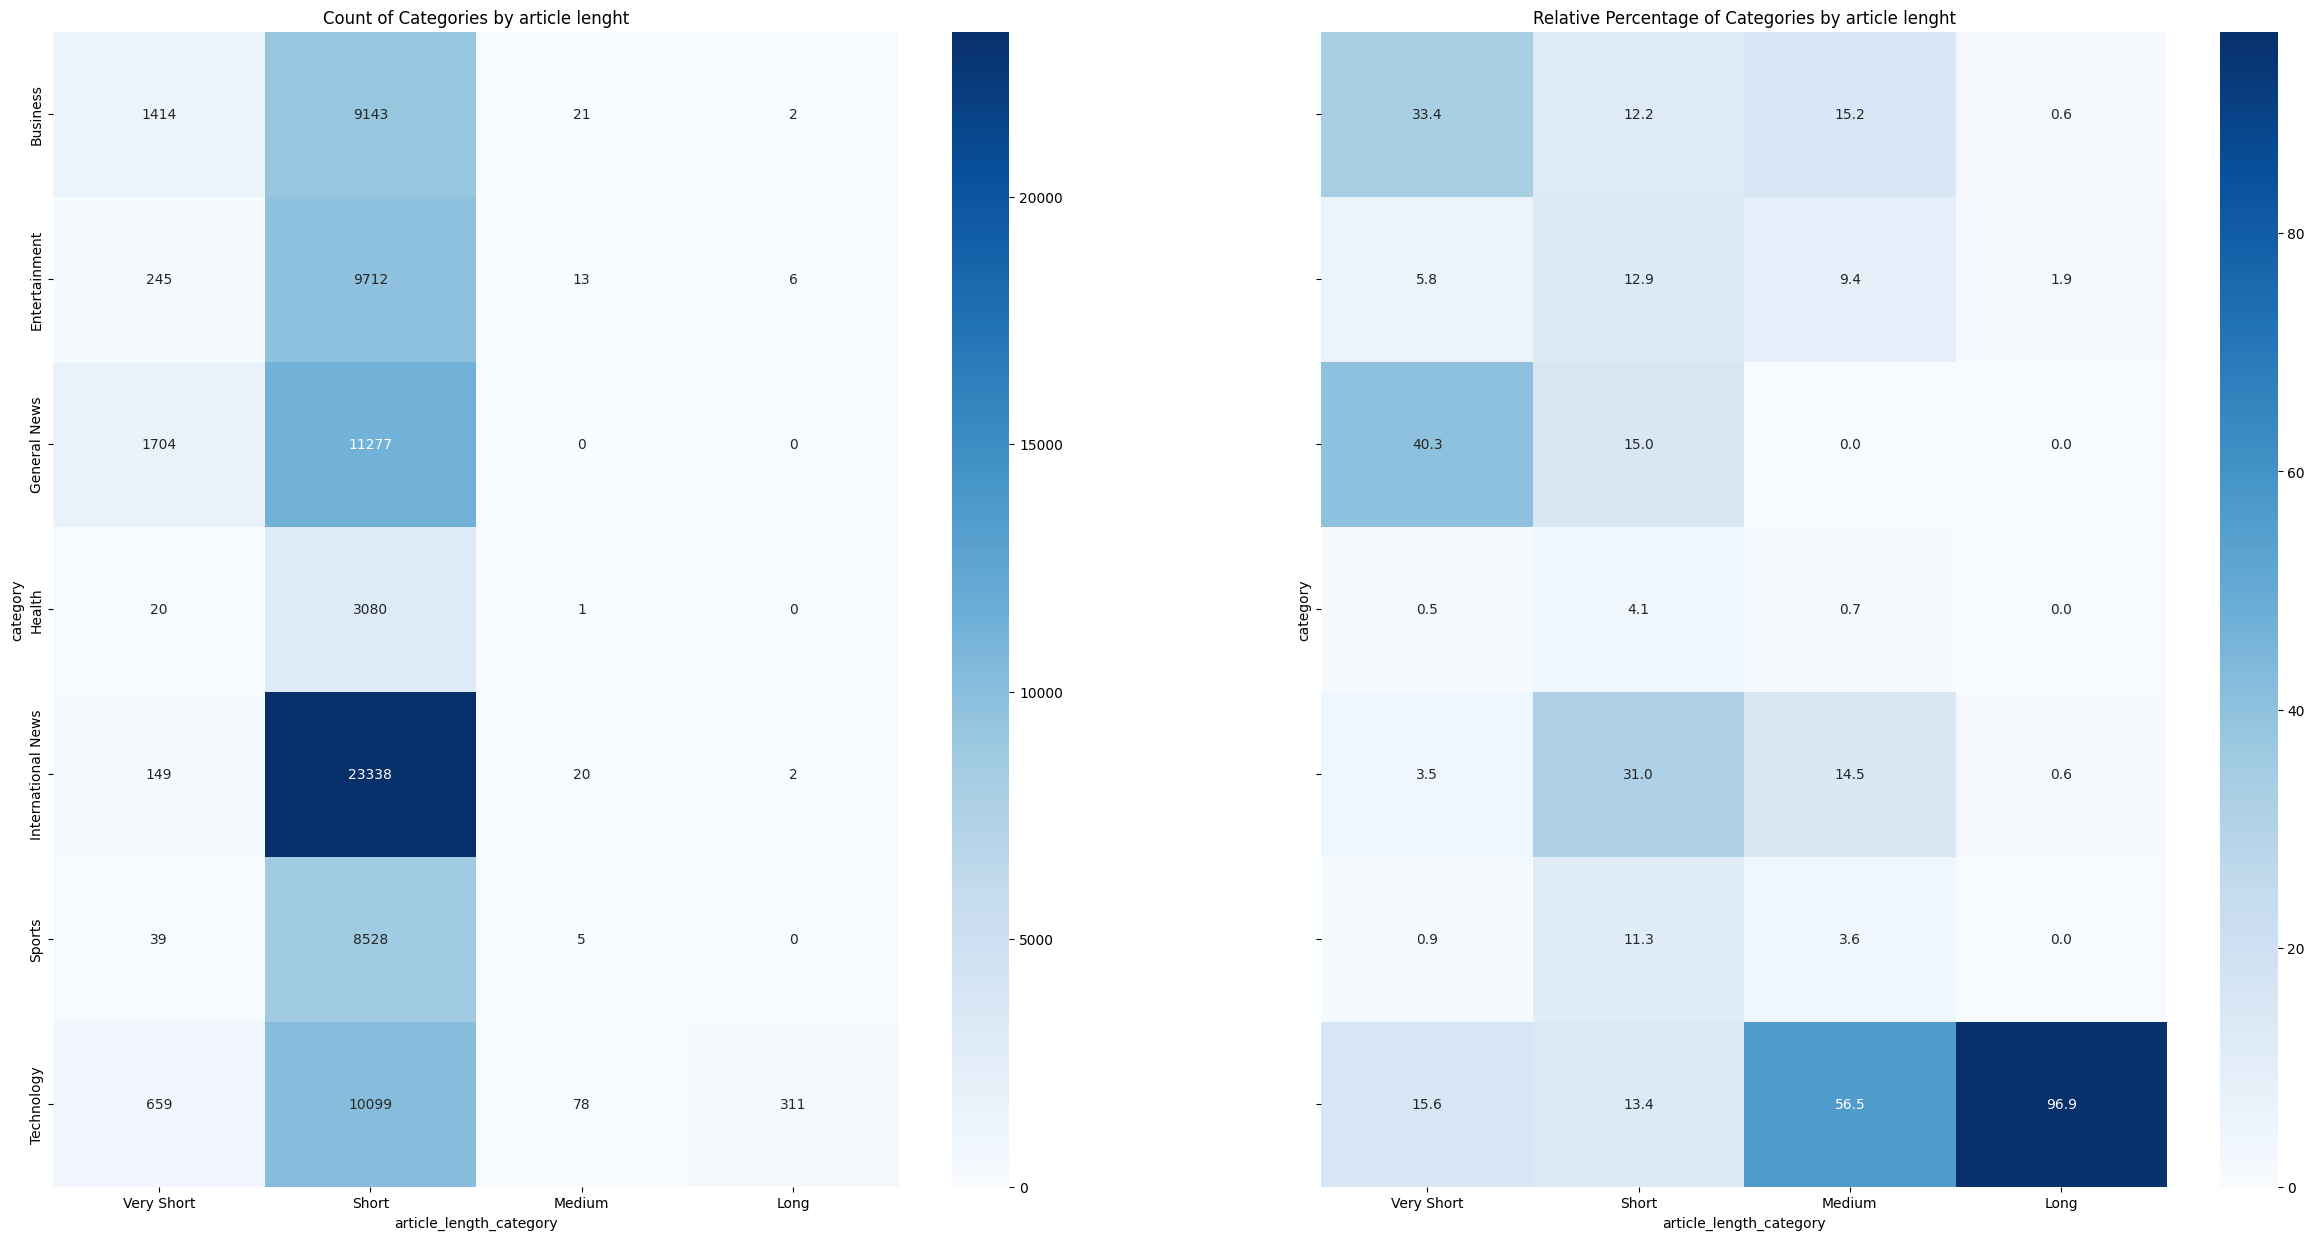

In [62]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 15), sharey=True)
matrix = dev_df.groupby(['category', 'article_length_category']).size().unstack(fill_value=0)
relative_matrix = (matrix / matrix.sum(axis=0)) * 100
    
sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', ax=ax1)
sns.heatmap(relative_matrix, annot=True, fmt='.1f', cmap='Blues', ax=ax2)
    
ax1.set_title(f'Count of Categories by article lenght')
ax2.set_title(f'Relative Percentage of Categories by article lenght')

<Axes: xlabel='article_length', ylabel='category'>

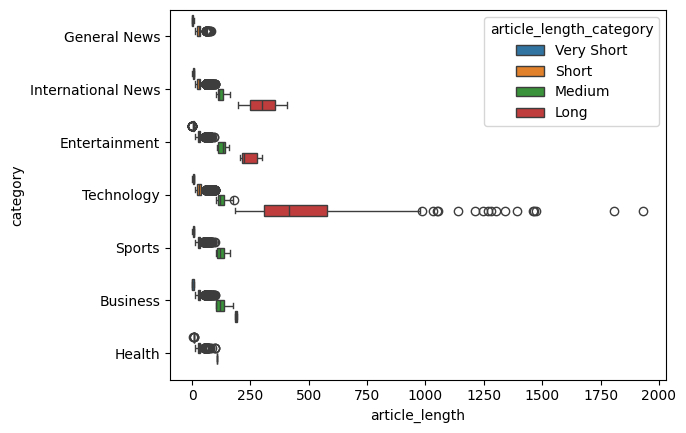

In [70]:
sns.boxplot(data = dev_df, x='article_length', y='category', hue='article_length_category')

In [72]:
dev_df[dev_df['article_length'] > 1900]['article_clean']

50498    infoworld andreas or simply andy bechtolsheim ...
Name: article_clean, dtype: str

In [65]:
import sys
sys.exit(0)

SystemExit: 0

/Users/mottad/Library/CloudStorage/OneDrive-LuxotticaGroupS.p.A/Desktop/news_classification /venv/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3709: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


## Text discovery

Generating word cloud for category: International News


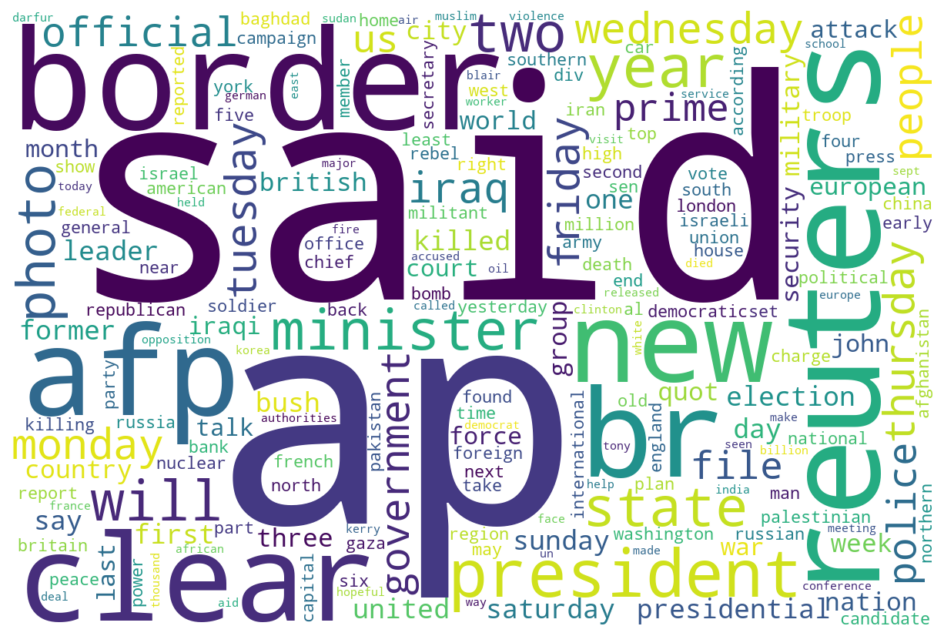

Generating word cloud for category: Business


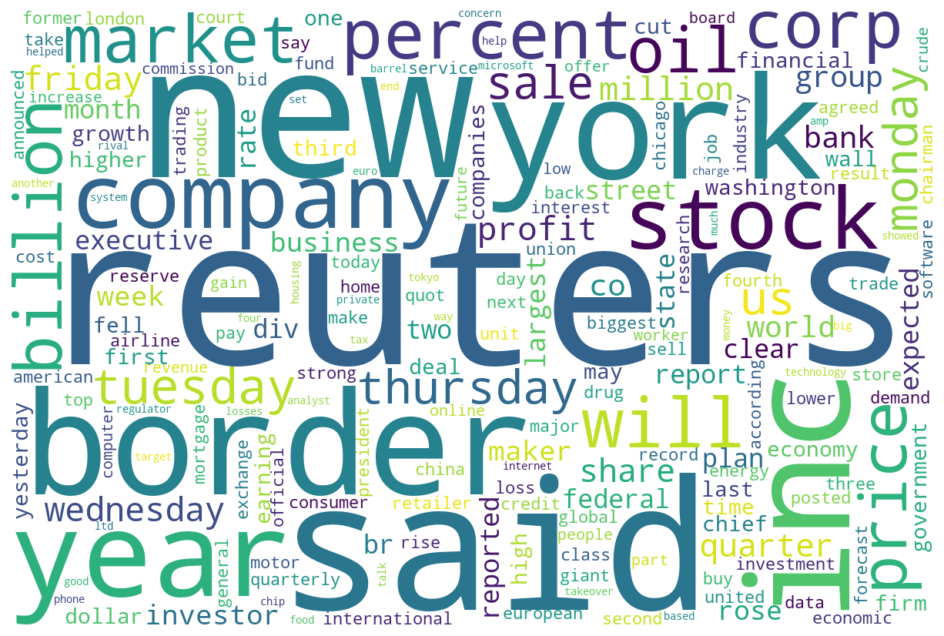

Generating word cloud for category: Technology


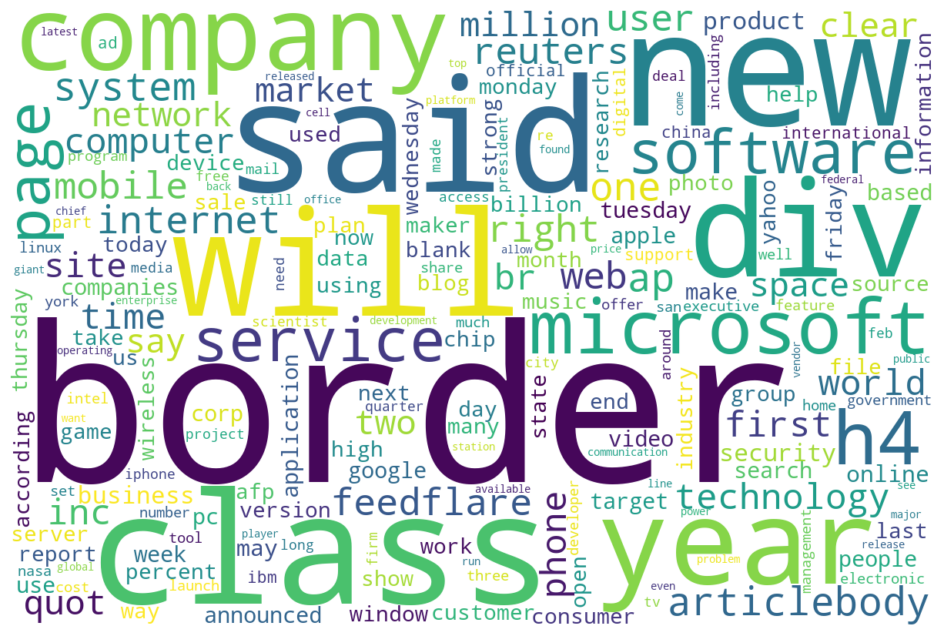

Generating word cloud for category: Entertainment


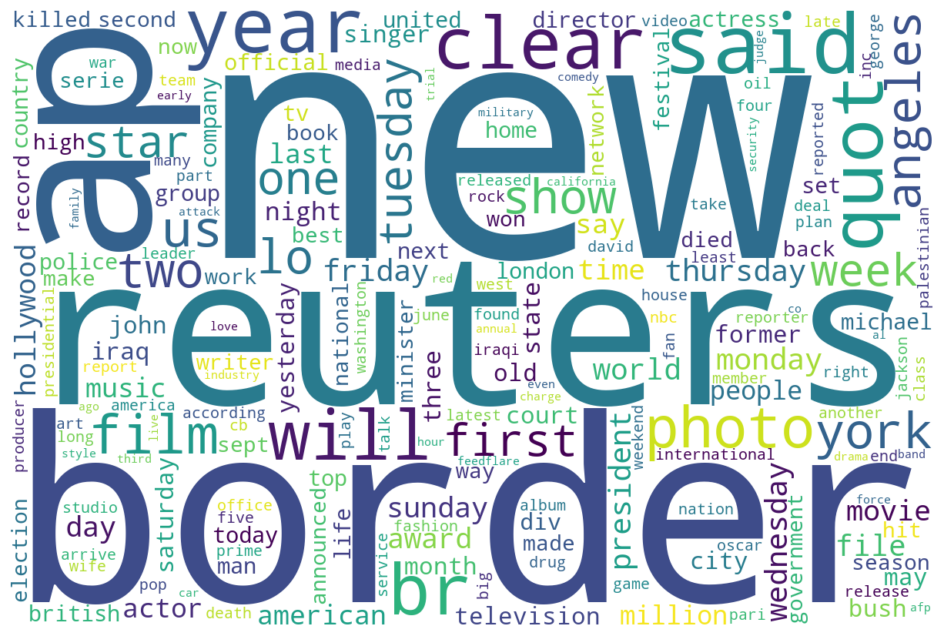

Generating word cloud for category: Sports


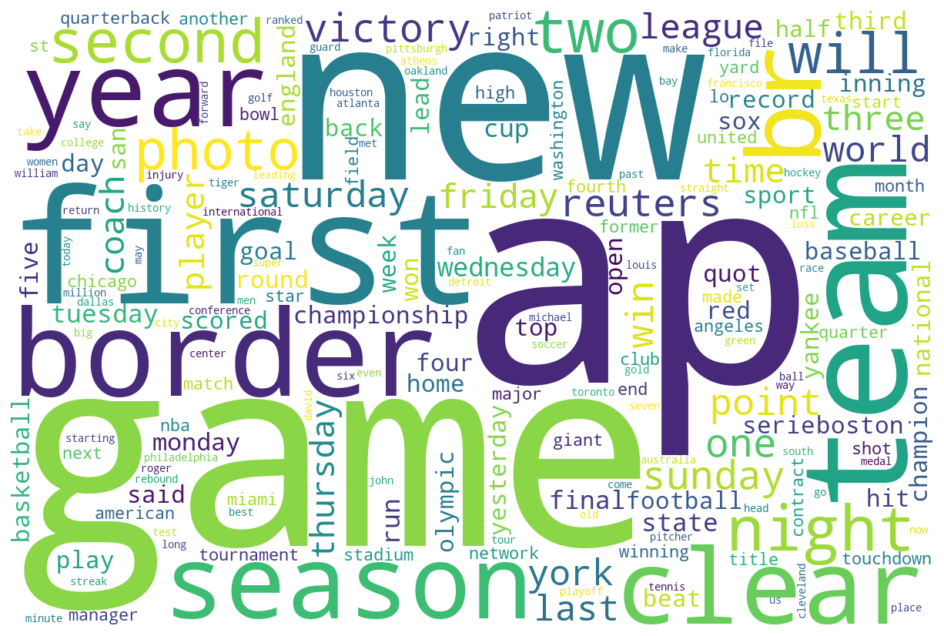

Generating word cloud for category: General News


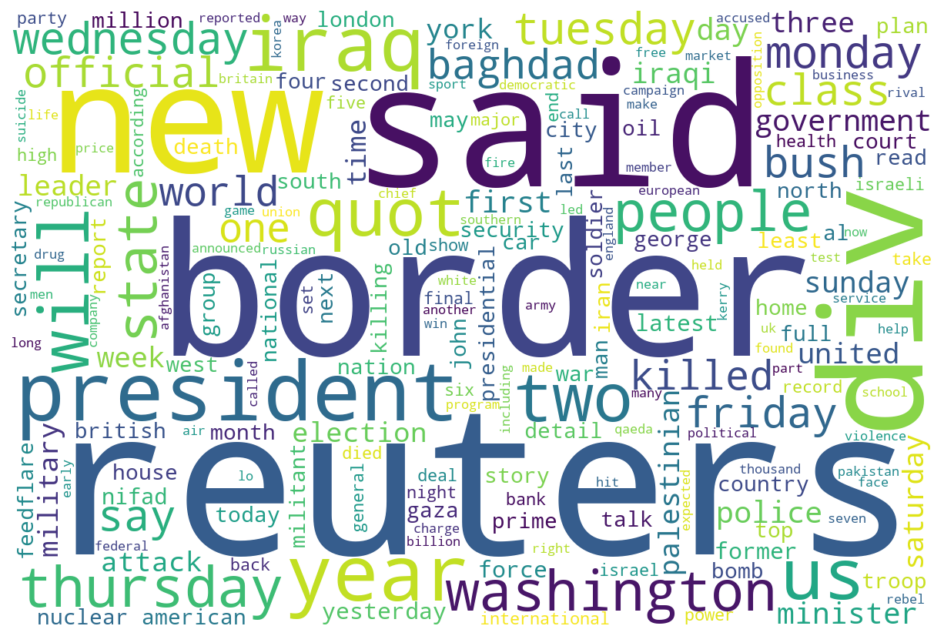

Generating word cloud for category: Health


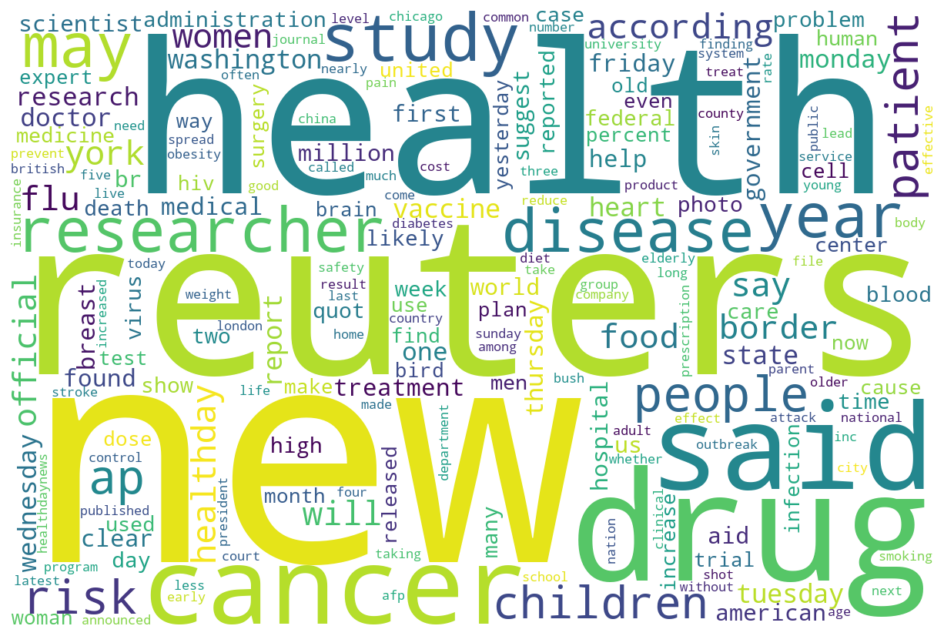

In [123]:
from wordcloud import WordCloud, STOPWORDS
import re


def clean_text(text: str) -> str:
    
    if pd.isna(text) or text is None:
        return ""
    

    text = str(text)
    

    text = text.lower()
    
    
    text = re.sub(r'https?://\S+|www\.\S+', ' ', text)
    
 
    text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)
    
  
    text = re.sub(r'\s+', ' ', text).strip()
    

    text = re.sub(r'\b\w{1}\b', '', text)
    

    text = re.sub(r'\b(href|src|img|height|width|alt|align|left)\b', '', text)
    
    return text



for i in range(len(LABEL_NAMES)):
    category = LABEL_NAMES[i]
    dev_df_clean_category = dev_df_clean[dev_df_clean['category'] == category]
    text = " ".join(dev_df_clean_category['clean_article'].tolist())
    print(f"Generating word cloud for category: {category}")

    wc = WordCloud(
        width=1200,
        height=800,
        background_color="white",
        stopwords=STOPWORDS,
        collocations=False,  
        max_words=200,
        
    ).generate(text)

    plt.figure(figsize=(12, 8))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()

### Title suffixes
I noticed that some title contain suffixews between brackets at the end of the text, e.g. "(AP)", "(Reuters)",  etc. It would be interesting to see the distribution of these suffixes. And if some of them could be predictive of the label.

/Users/mottad/Library/CloudStorage/OneDrive-LuxotticaGroupS.p.A/Desktop/news_classification /venv/lib/python3.11/site-packages/seaborn/utils.py:61: UserWarning: Glyph 128 (\x80) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/Users/mottad/Library/CloudStorage/OneDrive-LuxotticaGroupS.p.A/Desktop/news_classification /venv/lib/python3.11/site-packages/seaborn/utils.py:61: UserWarning: Glyph 147 (\x93) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/Users/mottad/Library/CloudStorage/OneDrive-LuxotticaGroupS.p.A/Desktop/news_classification /venv/lib/python3.11/site-packages/seaborn/utils.py:61: UserWarning: Glyph 128 (\x80) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/Users/mottad/Library/CloudStorage/OneDrive-LuxotticaGroupS.p.A/Desktop/news_classification /venv/lib/python3.11/site-packages/seaborn/utils.py:61: UserWarning: Glyph 147 (\x93) missing from font(s) DejaVu Sans.
  fig.canvas.draw()


Text(0.5, 1.0, 'Relative Percentage of Categories by Week for Top 5 title_suffixs per category')

/Users/mottad/Library/CloudStorage/OneDrive-LuxotticaGroupS.p.A/Desktop/news_classification /venv/lib/python3.11/site-packages/IPython/core/events.py:96: UserWarning: Glyph 128 (\x80) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/Users/mottad/Library/CloudStorage/OneDrive-LuxotticaGroupS.p.A/Desktop/news_classification /venv/lib/python3.11/site-packages/IPython/core/events.py:96: UserWarning: Glyph 147 (\x93) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/Users/mottad/Library/CloudStorage/OneDrive-LuxotticaGroupS.p.A/Desktop/news_classification /venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128 (\x80) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/mottad/Library/CloudStorage/OneDrive-LuxotticaGroupS.p.A/Desktop/news_classification /venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 147 (\x93) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(by

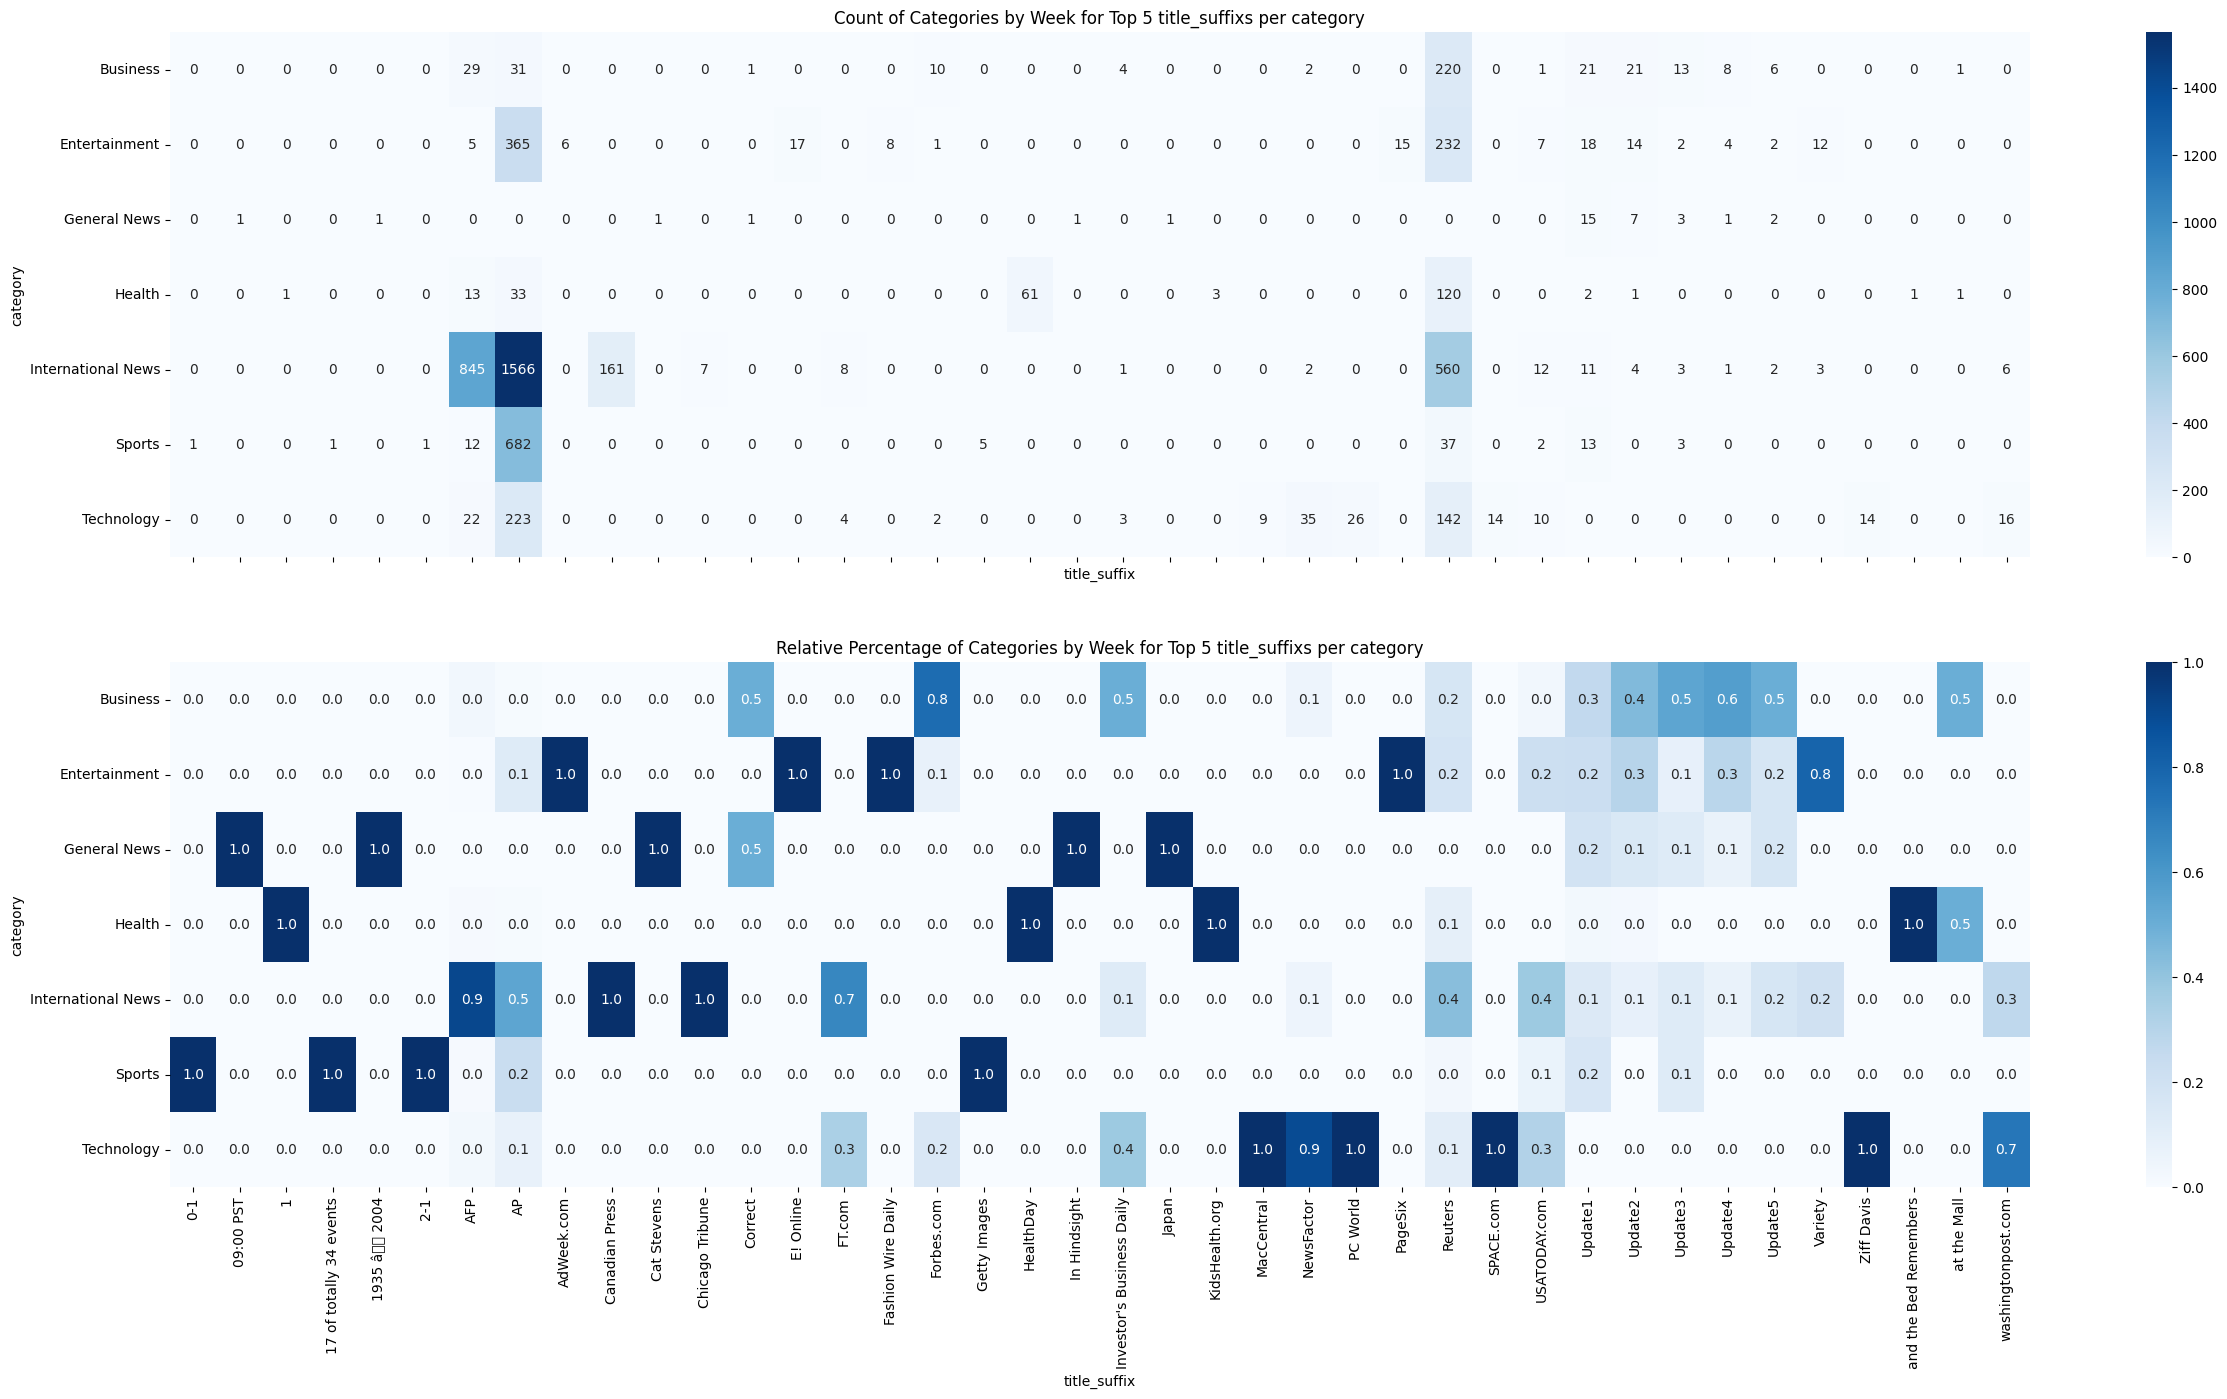

In [118]:


def extract_title_suffix_features(title: str):
    
    if isinstance(title, float):
        return None
    # Find words between brackets
    suffix_pattern = r'\(([^)]+)\)\s*$' #$ is usefull to find only at the end of the string
    match = re.search(suffix_pattern, title)
    title_clean = re.sub(suffix_pattern, '', title).strip() if match else title
    
    return match.group(1) if match else None
    
def apply_title_extraction(df):
    df['title_suffix'] = df['title'].apply(extract_title_suffix_features)
    return df


dev_df_title_suff = apply_title_extraction(dev_df)
dev_title_suffix_small = dev_df_title_suff[['title_suffix', 'category']]
dev_title_suffix_small = dev_title_suffix_small.dropna()

# Top 5 most common title suffixes for each category
grouped = dev_title_suffix_small.groupby(by = ['category', 'title_suffix']).size()
top_5_title_suff = grouped.groupby(level=0, group_keys=False).nlargest()


top_5_title_suff = top_5_title_suff.reset_index(name='count')['title_suffix'].unique()


dev_df_top_title_suffixs = dev_df[dev_df['title_suffix'].isin(top_5_title_suff)]


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(30, 15), sharex=True)
matrix = dev_df_top_title_suffixs.groupby(['category', 'title_suffix']).size().unstack(fill_value=0)
relative_matrix = (matrix / matrix.sum(axis=0)) 
    
sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', ax=ax1)
sns.heatmap(relative_matrix, annot=True, fmt='.1f', cmap='Blues', ax=ax2)
    
ax1.set_title(f'Count of Categories by {col.capitalize()} for Top 5 title_suffixs per category')
ax2.set_title(f'Relative Percentage of Categories by {col.capitalize()} for Top 5 title_suffixs per category')



    




Let's create the top suffixes for each category. Let's use the best from the above . We do no include business and general news due to the poor informative value of these categories.

In [122]:
tech_suffixes = ['PC World', 'NewsFactor', 'MacCentral', 'SPACE.com','Ziff Davis', 'washingtonpost.com']
    
sport_suffixes = ['Getty Images'] # The others seem scores to me

int_news_suffixes = ['AFP','Canadian Press','Chicago Tribune']

health_suffixes = ['HealthDay', 'KidsHealth.org']

ent_health_suffixes = ['AdWeek.com', 'E! Online', 'Fashion Wire Daily', 'PageSix','Variety', 'Playbill']

suffix_dict = {
    'is_tech_suffix': tech_suffixes,
    'is_sport_suffix': sport_suffixes,
    'is_int_news_suffix': int_news_suffixes,
    'is_health_suffix': health_suffixes,
    'is_ent_suffix': ent_health_suffixes
}

# Create binary columns for each suffix type
for col_name, suffix_list in suffix_dict.items():
    dev_df[col_name] = dev_df['title_suffix'].isin(suffix_list).astype(int)

# Top 5 most common title suffixes for each category
grouped = dev_title_suffix_small.groupby(by = ['category', 'title_suffix']).size()
top_5_title_suff = grouped.groupby(level=0, group_keys=False).nlargest()


top_5_title_suff = top_5_title_suff.reset_index(name='count')['title_suffix'].unique()


dev_df_top_title_suffixs = dev_df[dev_df['title_suffix'].isin(top_5_title_suff)]


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(30, 15), sharex=True)
matrix = dev_df_top_title_suffixs.groupby(['category', 'title_suffix']).size().unstack(fill_value=0)
relative_matrix = (matrix / matrix.sum(axis=0)) 
    
sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', ax=ax1)
sns.heatmap(relative_matrix, annot=True, fmt='.1f', cmap='Blues', ax=ax2)
    
ax1.set_title(f'Count of Categories by {col.capitalize()} for Top 5 title_suffixs per category')
ax2.set_title(f'Relative Percentage of Categories by {col.capitalize()} for Top 5 title_suffixs per category')






Id            source  \
0          0     AllAfrica.com   
1          1            Xinhua   
2          2             Yahoo   
3          3               BBC   
4          4             Yahoo   
...      ...               ...   
79992  79992             Yahoo   
79993  79993  All-Baseball.com   
79994  79994             Yahoo   
79995  79995             Voice   
79996  79996             Yahoo   

                                                   title  \
0      OPEC Boosts Nigeria&#39;s Oil Revenue By .82m Bpd   
1      Yearender: Mideast peace roadmap reaches dead-...   
2      Battleground Dispatches for Oct. 5 \\n    (CQP...   
3                       Air best to resuscitate newborns   
4      High tech German train crash kills at least on...   
...                                                  ...   
79992  Italy's embattled Prodi faces vote of confiden...   
79993                        Ding Dong, the Deal is Dead   
79994  Two bombs discovered in Sardinia after Berlusc...   
79995  Red Cross Report Alleges US Detainee Abuse at ...   
79996  UN: Myanmar allows early visit by envoy \\n   ...   

                                                 article  page_rank  \
0      THE Organisation of Petroleum Exporting Countr...          5   
1      Looking back at the major events that took pla...          5   
2      CQPolitics.com - Here are today's Battleground...          5   
3      Air rather than oxygen should be used to resus...          5   
4      <p><a href="http://us.rd.yahoo.com/dailynews/r...          5   
...                                                  ...        ...   
79992  <p><a href="http://us.rd.yahoo.com/dailynews/r...          5   
79993  As yesterday began, there was widespread antic...          5   
79994  AFP - Police discovered two bombs near the Sar...          5   
79995  A report by the International Committee of the...          5   
79996  <p><a href="http://us.rd.yahoo.com/dailynews/r...          5   

                 timestamp  label            category       timestamp_new  \
0      2004-09-16 22:39:53      5        General News 2004-09-16 22:39:53   
1      2004-12-17 19:01:14      0  International News 2004-12-17 19:01:14   
2      2006-10-05 18:42:29      0  International News 2006-10-05 18:42:29   
3      0000-00-00 00:00:00      0  International News                 NaT   
4      2006-09-22 17:28:57      0  International News 2006-09-22 17:28:57   
...                    ...    ...                 ...                 ...   
79992  2008-01-23 11:39:35      0  International News 2008-01-23 11:39:35   
79993  0000-00-00 00:00:00      4              Sports                 NaT   
79994  0000-00-00 00:00:00      0  International News                 NaT   
79995  0000-00-00 00:00:00      3       Entertainment                 NaT   
79996  2007-10-24 17:15:44      0  International News 2007-10-24 17:15:44   

       year  ...  week  article_length  article_length_category  title_suffix  \
0      2004  ...    38              35                    Short           NaN   
1      2004  ...    51              27                    Short           NaN   
2      2006  ...    40              30                    Short           NaN   
3      <NA>  ...  <NA>              18                    Short           NaN   
4      2006  ...    38              79                    Short           NaN   
...     ...  ...   ...             ...                      ...           ...   
79992  2008  ...     4              75                    Short           NaN   
79993  <NA>  ...  <NA>              33                    Short           NaN   
79994  <NA>  ...  <NA>              34                    Short           AFP   
79995  <NA>  ...  <NA>              31                    Short           NaN   
79996  2007  ...    43              93                    Short           NaN   

       is_tech_suffix  is_sport_suffix is_int_news_suffix is_health_suffix  \
0                   0                0             

### Article Discovery (link focuses)
I noticed that some articles contain one ore more links (web pages, images, videos, etc). It would be interesting to see the distribution of these links. And if some of them could be predictive of the label. Maybe I can discover something by categorizing the types of urls (feed, news, social media, etc).

In [163]:
from urllib.parse import urlparse
from collections import Counter

def extract_link(article: str, first_only=False):
    if pd.isna(article) or article is None:
        return None

    if not isinstance(article, str):
        article = str(article)
    
    url_pattern = r'https?://[^\s<>"{}|\\^`\[\]]+'
    
    match = re.findall(url_pattern, article)
    article_clean = re.sub(url_pattern, '', article).strip() if match else article
    
    if first_only:
        return match[0] if match else None
    return match if match else None

def extract_domain(link: str):
    if pd.isna(link) or link is None:
        return None
    parsed = urlparse(link)
    domain = parsed.netloc.replace('www.', '')
    return domain 


def categorize_link(link: str):
    link_lower = link.lower()
    
    image_extensions = ['.jpg', '.jpeg', '.png', '.gif', '.bmp', '.webp', '.svg', '.ico']
    image_domains = ['yimg.com', 'img.', 'images.', 'static.']
    feed_patterns = ['feeds.', 'rss.', 'feed.', 'feedburner']
    ad_domains = ['doubleclick', 'adlog', 'pheedo', 'ad.']
    
    # images
    for ext in image_extensions:
        if ext in link_lower:
            return 'image'
    
    # Images
    for img_dom in image_domains:
        if img_dom in link_lower:
            return 'image'
    
    # Feed RSS
    for feed in feed_patterns:
        if feed in link_lower:
            return 'feed'
    
    # Advertising
    for ad in ad_domains:
        if ad in link_lower:
            return 'ad'
    
    return 'content'
    
    
    
    
    
links = extract_link("<p><a href=""://us.rd.yahoo.com/dailynewshttp/rss/europe/*http://news.yahoo.com/s/nm/20060922/wl_nm/transport_germany_accident_dc""><img src=""http://d.yimg.com/us.yimg.com/p/rids/20060922/i/r83709231.jpg?x=47&y=130&sig=dF38yH9MhxP9zBLqrj3SMw--"" align=""left"" height=""130"" width=""47"" alt=""An aerial view shows the crash site of a Transrapid high-speed train in the northern German region of Emsland near the town of Lathen, September 22, 2006. REUTERS/Bodo Marks"" border=""0"" /></a>Reuters - A high tech German train \
carrying 29 people smashed into a maintenance vehicle on a \
trial run in northern Germany on Friday, killing at least one \
and trapping 10 more in the wreckage, a local official said.</p><br clear=""all""/>")
print(links)


for link in links:
    domain = extract_domain(link)
    category = categorize_link(link)
    print(f"Link: {link}, Domain: {domain}, Category: {category}")


['http://news.yahoo.com/s/nm/20060922/wl_nm/transport_germany_accident_dc', 'http://d.yimg.com/us.yimg.com/p/rids/20060922/i/r83709231.jpg?x=47&y=130&sig=dF38yH9MhxP9zBLqrj3SMw--']
Link: http://news.yahoo.com/s/nm/20060922/wl_nm/transport_germany_accident_dc, Domain: news.yahoo.com, Category: content
Link: http://d.yimg.com/us.yimg.com/p/rids/20060922/i/r83709231.jpg?x=47&y=130&sig=dF38yH9MhxP9zBLqrj3SMw--, Domain: d.yimg.com, Category: image


In [157]:
for cat in dev_df['category'].unique():
    print("="*20)
    print(f"Category {cat}")
    dev_df_cat = dev_df[dev_df['category'] == cat]
    all_links = dev_df_cat['article'].apply(extract_link).dropna().tolist()
    print("Average number of links per article:", np.mean([len(links) for links in all_links]))
    
    flat_links = [link for sublist in all_links for link in sublist]
    domains = [extract_domain(link) for link in flat_links]
    domain_counts = Counter(domains)
    print(f"Top 10 domains: {domain_counts.most_common(10)}")
    
    cat_links = [categorize_link(link) for link in flat_links]
    cat_counts = Counter(cat_links)
    print(f"Top 10 domains: {cat_counts.most_common(10)}")
    
    
    

    print()


Category General News
Average number of links per article: 3.445580276608539
Top 10 domains: [('rss.cnn.com', 3814), ('pheedo.com', 776), ('feeds.feedburner.com', 452), ('newsisfree.com', 397), ('feeds.reuters.com', 279), ('investor.reuters.com', 9), ('indianexpress.com', 1), ('ire.org', 1), ('download.', 1)]
Top 10 domains: [('feed', 4545), ('content', 401), ('image', 395), ('ad', 389)]

Category International News
Average number of links per article: 2.354738015607581
Top 10 domains: [('us.rd.yahoo.com', 3742), ('d.yimg.com', 3544), ('rss.csmonitor.com', 1697), ('feeds.reuters.com', 585), ('feeds.feedburner.com', 340), ('us.news3.yimg.com', 198), ('ad.doubleclick.net', 196), ('topix.net', 164), ('pheedo.com', 63), ('investor.reuters.com', 10)]
Top 10 domains: [('content', 3933), ('image', 3785), ('feed', 2622), ('ad', 221)]

Category Entertainment
Average number of links per article: 3.233798195242002
Top 10 domains: [('us.rd.yahoo.com', 1022), ('d.yimg.com', 961), ('rss.csmonitor.co

Text(0.5, 1.0, 'Relative Percentage of Categories by Week for Top 5 first_link_domain per category')

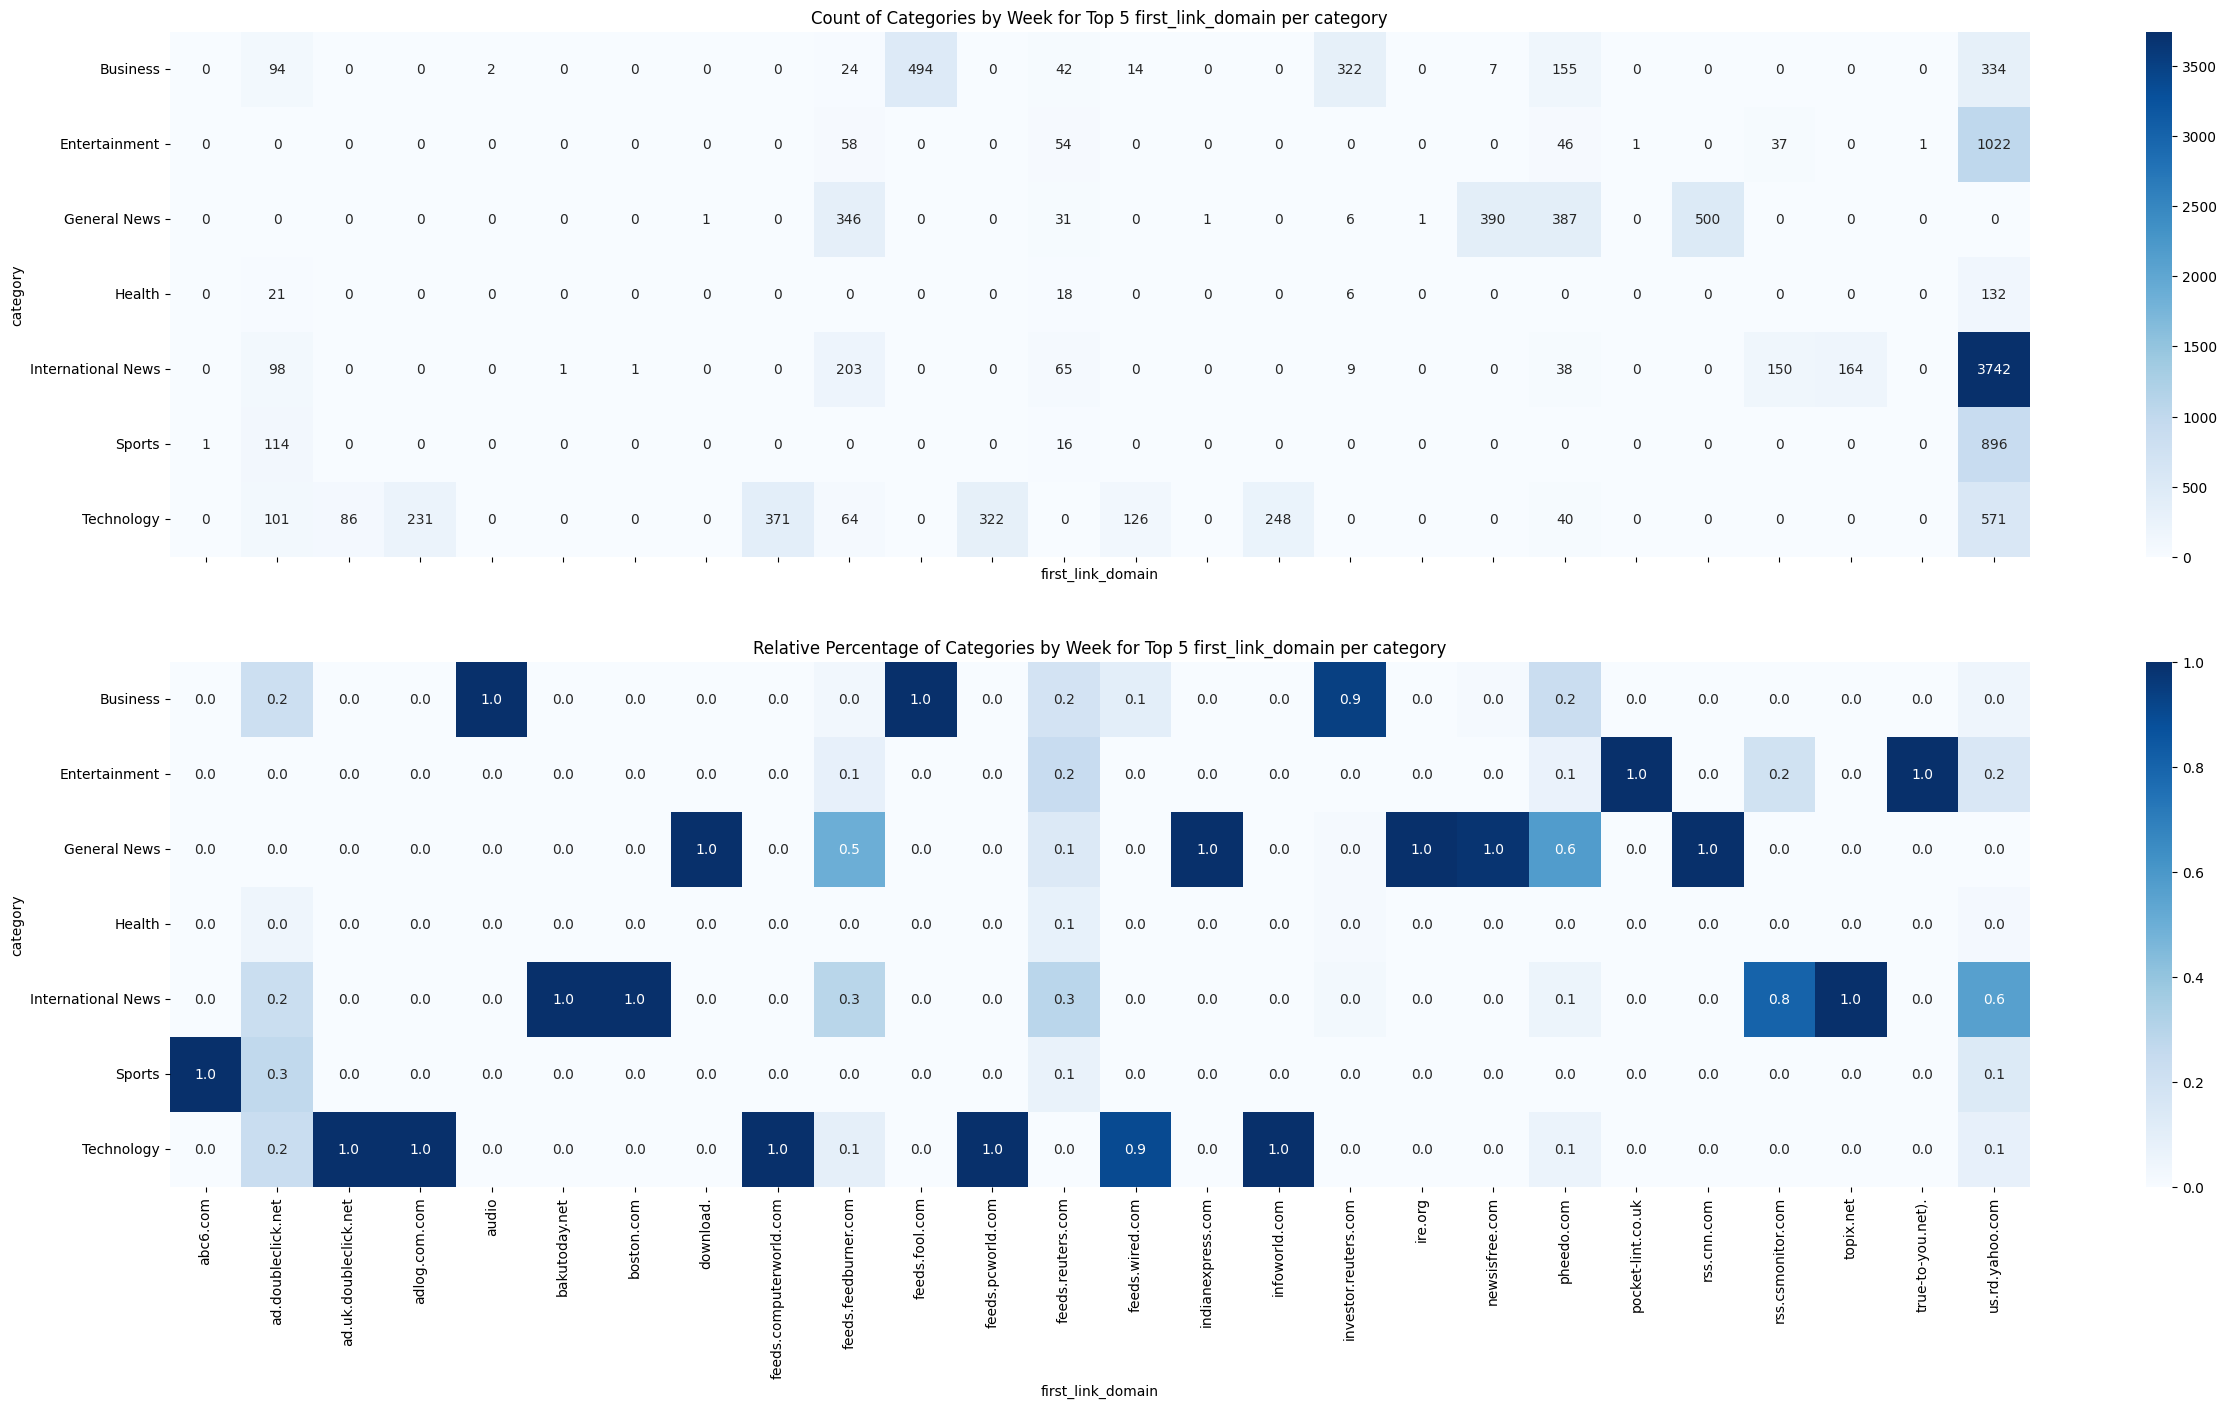

In [168]:
def apply_domain_extraction(df):
    df['first_link_domain'] = df['article'].apply(lambda row: extract_link(row, first_only=True)).apply(extract_domain) 
    return df 

dev_df_domain = apply_domain_extraction(dev_df)


# Top 5 most common title suffixes for each category
grouped = dev_df_domain.groupby(by = ['category', 'first_link_domain']).size()
top_5_title_suff = grouped.groupby(level=0, group_keys=False).nlargest(10)


top_5_title_suff = top_5_title_suff.reset_index(name='count')['first_link_domain'].unique()


dev_df_top_title_suffixs = dev_df[dev_df['first_link_domain'].isin(top_5_title_suff)]


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(30, 15), sharex=True)
matrix = dev_df_top_title_suffixs.groupby(['category', 'first_link_domain']).size().unstack(fill_value=0)
relative_matrix = (matrix / matrix.sum(axis=0)) 
    
sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', ax=ax1)
sns.heatmap(relative_matrix, annot=True, fmt='.1f', cmap='Blues', ax=ax2)
    
ax1.set_title(f'Count of Categories by {col.capitalize()} for Top 5 first_link_domain per category')
ax2.set_title(f'Relative Percentage of Categories by {col.capitalize()} for Top 5 first_link_domain per category')

In [172]:
for cat in relative_matrix.index:
    print("="*20)
    print(f"Category {cat}")
    cat_links = relative_matrix.loc[cat]
    print(cat_links[cat_links > 0.95].sort_values(ascending=False))
    print()

Category Business
first_link_domain
audio             1.0
feeds.fool.com    1.0
Name: Business, dtype: float64

Category Entertainment
first_link_domain
pocket-lint.co.uk    1.0
true-to-you.net).    1.0
Name: Entertainment, dtype: float64

Category General News
first_link_domain
download.            1.000000
indianexpress.com    1.000000
ire.org              1.000000
rss.cnn.com          1.000000
newsisfree.com       0.982368
Name: General News, dtype: float64

Category Health
Series([], Name: Health, dtype: float64)

Category International News
first_link_domain
bakutoday.net    1.0
boston.com       1.0
topix.net        1.0
Name: International News, dtype: float64

Category Sports
first_link_domain
abc6.com    1.0
Name: Sports, dtype: float64

Category Technology
first_link_domain
ad.uk.doubleclick.net      1.0
adlog.com.com              1.0
feeds.computerworld.com    1.0
feeds.pcworld.com          1.0
infoworld.com              1.0
Name: Technology, dtype: float64



In [185]:
tech_domains = ["ad.uk.doubleclick.net", "adlog.com.com", "feeds.computerworld.com", "feeds.pcworld.com", "infoworld.com"]

int_news_domains = ["bakutoday.net", "boston.com", "topix.net"]

gen_news_domains = ["rss.cnn.com", "newsisfree.com"] 

business_domains = ["feeds.fool.com"]


suffix_dict = {
    'is_tech_domains': tech_domains,
    'is_gen_news_domains': gen_news_domains,
    'is_int_news_domains': int_news_domains,
    'is_business_domains': business_domains
}

# Create binary columns for each suffix type
for col_name, suffix_list in suffix_dict.items():
    dev_df_domain[col_name] = dev_df_domain['first_link_domain'].isin(suffix_list).astype(int)

Id            source  \
0          0     AllAfrica.com   
1          1            Xinhua   
2          2             Yahoo   
3          3               BBC   
4          4             Yahoo   
...      ...               ...   
79992  79992             Yahoo   
79993  79993  All-Baseball.com   
79994  79994             Yahoo   
79995  79995             Voice   
79996  79996             Yahoo   

                                                   title  \
0      OPEC Boosts Nigeria&#39;s Oil Revenue By .82m Bpd   
1      Yearender: Mideast peace roadmap reaches dead-...   
2      Battleground Dispatches for Oct. 5 \\n    (CQP...   
3                       Air best to resuscitate newborns   
4      High tech German train crash kills at least on...   
...                                                  ...   
79992  Italy's embattled Prodi faces vote of confiden...   
79993                        Ding Dong, the Deal is Dead   
79994  Two bombs discovered in Sardinia after Berlusc...   
79995  Red Cross Report Alleges US Detainee Abuse at ...   
79996  UN: Myanmar allows early visit by envoy \\n   ...   

                                                 article  page_rank  \
0      THE Organisation of Petroleum Exporting Countr...          5   
1      Looking back at the major events that took pla...          5   
2      CQPolitics.com - Here are today's Battleground...          5   
3      Air rather than oxygen should be used to resus...          5   
4      <p><a href="http://us.rd.yahoo.com/dailynews/r...          5   
...                                                  ...        ...   
79992  <p><a href="http://us.rd.yahoo.com/dailynews/r...          5   
79993  As yesterday began, there was widespread antic...          5   
79994  AFP - Police discovered two bombs near the Sar...          5   
79995  A report by the International Committee of the...          5   
79996  <p><a href="http://us.rd.yahoo.com/dailynews/r...          5   

                 timestamp  label            category       timestamp_new  \
0      2004-09-16 22:39:53      5        General News 2004-09-16 22:39:53   
1      2004-12-17 19:01:14      0  International News 2004-12-17 19:01:14   
2      2006-10-05 18:42:29      0  International News 2006-10-05 18:42:29   
3      0000-00-00 00:00:00      0  International News                 NaT   
4      2006-09-22 17:28:57      0  International News 2006-09-22 17:28:57   
...                    ...    ...                 ...                 ...   
79992  2008-01-23 11:39:35      0  International News 2008-01-23 11:39:35   
79993  0000-00-00 00:00:00      4              Sports                 NaT   
79994  0000-00-00 00:00:00      0  International News                 NaT   
79995  0000-00-00 00:00:00      3       Entertainment                 NaT   
79996  2007-10-24 17:15:44      0  International News 2007-10-24 17:15:44   

       year  ...  is_sport_suffix  is_int_news_suffix  is_health_suffix  \
0      2004  ...                0                   0                 0   
1      2004  ...                0                   0                 0   
2      2006  ...                0                   0                 0   
3      <NA>  ...                0                   0                 0   
4      2006  ...                0                   0                 0   
...     ...  ...              ...                 ...               ...   
79992  2008  ...                0                   0                 0   
79993  <NA>  ...                0                   0                 0   
79994  <NA>  ...                0                   1                 0   
79995  <NA>  ...                0                   0                 0   
79996  2007  ...                0                   0                 0   

       is_ent_news_suffix  is_ent_suffix  first_link_domain is_tech_domains  \
0                       0              0                NaN               0   
1                       0              0   

In [186]:
dev_df_domain['n_links'] = dev_df_domain['article'].apply(lambda x: len(extract_link(x)) if extract_link(x) is not None else 0)

In [188]:
dev_df_domain['n_images'] = dev_df_domain['article'].apply(lambda x: len([link for link in extract_link(x) if categorize_link(link) == 'image']) if extract_link(x) is not None else 0)
dev_df_domain['n_ads'] = dev_df_domain['article'].apply(lambda x: len([link for link in extract_link(x) if categorize_link(link) == 'ad']) if extract_link(x) is not None else 0)
dev_df_domain['n_feeds'] = dev_df_domain['article'].apply(lambda x: len([link for link in extract_link(x) if categorize_link(link) == 'feed']) if extract_link(x) is not None else 0)

In [189]:
dev_df_domain

Id            source  \
0          0     AllAfrica.com   
1          1            Xinhua   
2          2             Yahoo   
3          3               BBC   
4          4             Yahoo   
...      ...               ...   
79992  79992             Yahoo   
79993  79993  All-Baseball.com   
79994  79994             Yahoo   
79995  79995             Voice   
79996  79996             Yahoo   

                                                   title  \
0      OPEC Boosts Nigeria&#39;s Oil Revenue By .82m Bpd   
1      Yearender: Mideast peace roadmap reaches dead-...   
2      Battleground Dispatches for Oct. 5 \\n    (CQP...   
3                       Air best to resuscitate newborns   
4      High tech German train crash kills at least on...   
...                                                  ...   
79992  Italy's embattled Prodi faces vote of confiden...   
79993                        Ding Dong, the Deal is Dead   
79994  Two bombs discovered in Sardinia after Berlusc...   
79995  Red Cross Report Alleges US Detainee Abuse at ...   
79996  UN: Myanmar allows early visit by envoy \\n   ...   

                                                 article  page_rank  \
0      THE Organisation of Petroleum Exporting Countr...          5   
1      Looking back at the major events that took pla...          5   
2      CQPolitics.com - Here are today's Battleground...          5   
3      Air rather than oxygen should be used to resus...          5   
4      <p><a href="http://us.rd.yahoo.com/dailynews/r...          5   
...                                                  ...        ...   
79992  <p><a href="http://us.rd.yahoo.com/dailynews/r...          5   
79993  As yesterday began, there was widespread antic...          5   
79994  AFP - Police discovered two bombs near the Sar...          5   
79995  A report by the International Committee of the...          5   
79996  <p><a href="http://us.rd.yahoo.com/dailynews/r...          5   

                 timestamp  label            category       timestamp_new  \
0      2004-09-16 22:39:53      5        General News 2004-09-16 22:39:53   
1      2004-12-17 19:01:14      0  International News 2004-12-17 19:01:14   
2      2006-10-05 18:42:29      0  International News 2006-10-05 18:42:29   
3      0000-00-00 00:00:00      0  International News                 NaT   
4      2006-09-22 17:28:57      0  International News 2006-09-22 17:28:57   
...                    ...    ...                 ...                 ...   
79992  2008-01-23 11:39:35      0  International News 2008-01-23 11:39:35   
79993  0000-00-00 00:00:00      4              Sports                 NaT   
79994  0000-00-00 00:00:00      0  International News                 NaT   
79995  0000-00-00 00:00:00      3       Entertainment                 NaT   
79996  2007-10-24 17:15:44      0  International News 2007-10-24 17:15:44   

       year  ...  is_ent_suffix  first_link_domain  is_tech_domains  \
0      2004  ...              0                NaN                0   
1      2004  ...              0                NaN                0   
2      2006  ...              0                NaN                0   
3      <NA>  ...              0                NaN                0   
4      2006  ...              0    us.rd.yahoo.com                0   
...     ...  ...            ...                ...              ...   
79992  2008  ...              0    us.rd.yahoo.com                0   
79993  <NA>  ...              0                NaN                0   
79994  <NA>  ...              0                NaN                0   
79995  <NA>  ...              0                NaN                0   
79996  2007  ...              0    us.rd.yahoo.com                0   

       is_gen_news_domains  is_int_news_domains  is_business_domains n_links  \
0                        0                    0                    0       0   
1                        0                    0                    0       0   
2        

In [191]:
dev_df_domain.sort_values(by=['source', 'title', 'article', 'label', 'timestamp_new'], 
                          ascending=[True, True, True, True, False], inplace=True)

# Drop duplicates, keeping the first occurrence (which will be the one with a valid timestamp_new if possible)
dev_df_domain.drop_duplicates(subset=['source', 'title', 'article', 'label'], inplace=True)

In [211]:
grouped = dev_df_domain.groupby(by = ['source','title','article'], as_index=False)['label'].agg({'nunique'})
index = grouped[grouped['nunique'] >= 2].sort_values(by='nunique', ascending=False).index

dev_df_domain.iloc[~dev_df_domain.index.isin(index)].drop(columns=['Id','timestamp', 'is_ent_news_suffix']).sample(frac=0.95).to_csv("data/data.csv", index=False)